<a href="https://colab.research.google.com/github/RajeshworM/Yield_Modelling_Automation/blob/main/FEIS_10092025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='Blue'> <font size='6'> **NEW Start FEIS**

<font color='Blue'> <font size='4'> **Zone_cluster 4**

Upload your CSV file (must include yield_val).


Saving data1.csv to data1 (4).csv

Data prepared: (3612, 209) years 2005 to 2025
Zone clusters available: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Working on zone_cluster 4: train=504, val=28, forecast=56

=== STEP A: Economic Variable Selection ===
 Econ econ_inc_rev1: coef=0.021641, p=0.0000
 -> selected first econ econ_inc_rev1
 Econ econ_inc_rev2: coef=0.020479, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev2'] -> coef=0.021111, p=0.0000, vs current p=0.0000
 -> kept econ_inc_rev2 in econ group
 Econ econ_inc_rev3: coef=0.021031, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev2', 'econ_inc_rev3'] -> coef=0.021346, p=0.0000, vs current p=0.0000
 -> kept econ_inc_rev3 in econ group
 Econ econ_inc_rev4: coef=0.020218, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev2', 'econ_inc_rev3', 'econ_inc_rev4'] -> coef=0.021218, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev5: coef=0.022078, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev2',

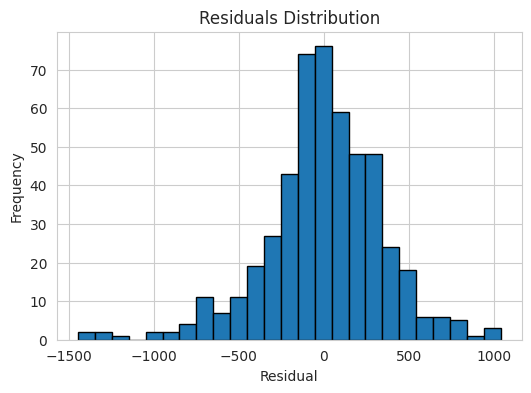

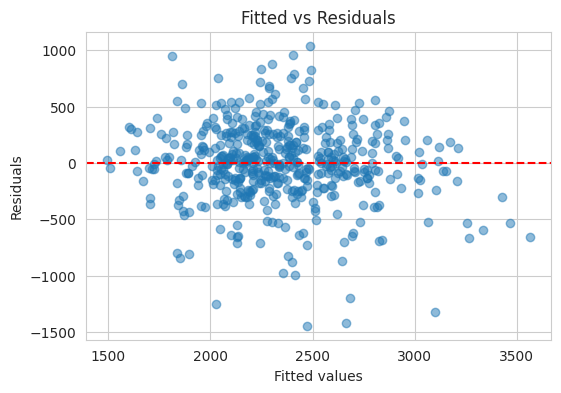

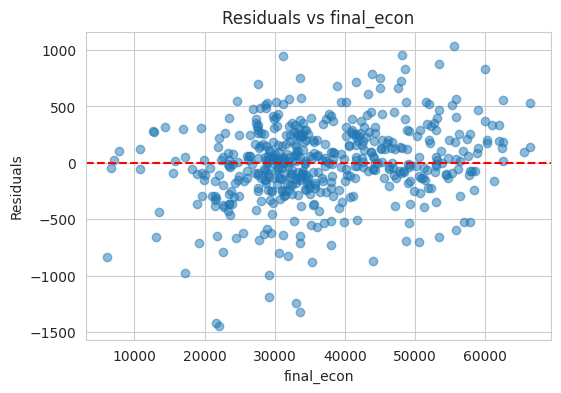

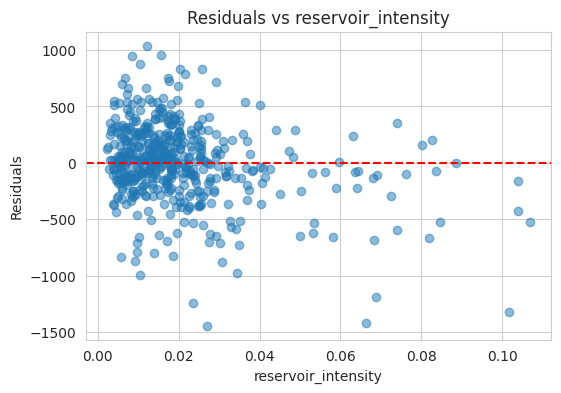

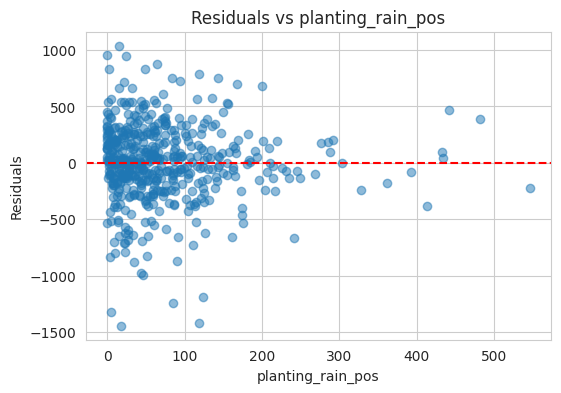

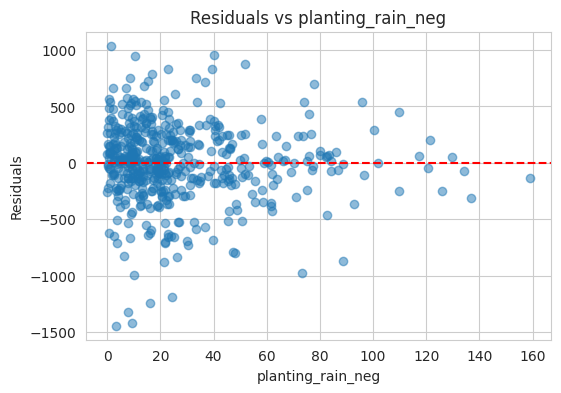

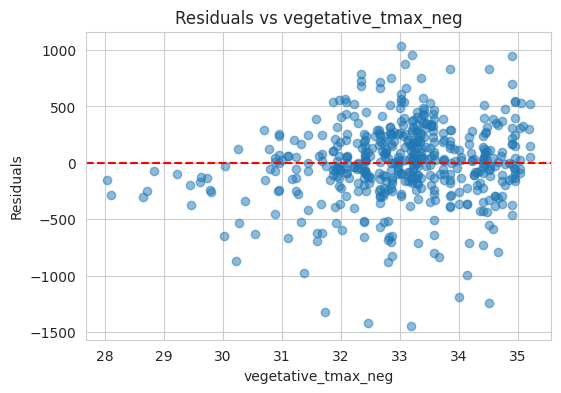

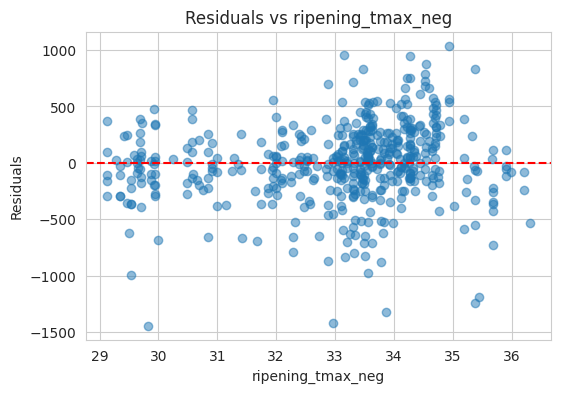

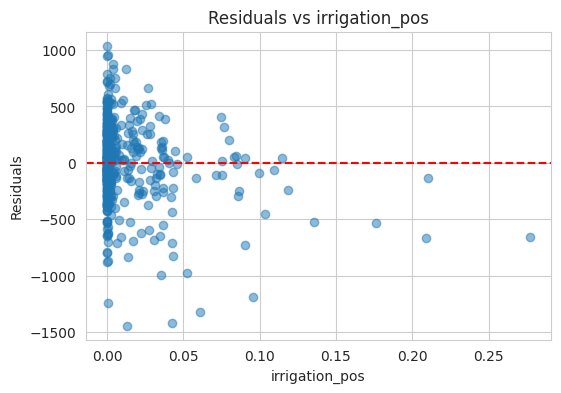


Shapiro-Wilk test: stat=0.9693, p=0.0000
Residuals deviate from normality

RMSE per district (sample period):
District 101: RMSE = 226.881
District 110: RMSE = 331.703
District 112: RMSE = 420.090
District 130: RMSE = 222.947
District 14: RMSE = 175.078
District 145: RMSE = 271.602
District 146: RMSE = 271.706
District 156: RMSE = 299.011
District 157: RMSE = 256.688
District 16: RMSE = 160.567
District 162: RMSE = 850.919
District 164: RMSE = 385.658
District 170: RMSE = 249.635
District 18: RMSE = 279.819
District 19: RMSE = 409.500
District 25: RMSE = 304.832
District 35: RMSE = 295.553
District 42: RMSE = 375.470
District 48: RMSE = 266.282
District 5: RMSE = 304.152
District 60: RMSE = 299.876
District 61: RMSE = 206.722
District 62: RMSE = 611.674
District 7: RMSE = 396.529
District 79: RMSE = 212.859
District 8: RMSE = 334.701
District 92: RMSE = 221.639
District 97: RMSE = 275.072

Overall RMSE (sample period, used rows): 346.470
Saved sample actual vs predicted to sample_actu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Step M: Regenerate features in val & forecast (auto) ===

=== Validation (2023) prediction ===


Validation RMSE (2023): 367.687
Saved validation file to validation_2023_actual_vs_predicted.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Forecast (2024-2025) prediction ===
                  yield_predicted
district_id year                 
101         2024      2836.597170
            2025      2727.054916
110         2024      2552.519271
            2025      2415.445743
112         2024      3056.397770
            2025      3042.279021
130         2024      2672.232703
            2025      2624.756625
14          2024      2570.273052
            2025      2433.372132
145         2024      2941.957925
            2025      2820.507513
146         2024      3260.303962
            2025      3331.823623
156         2024      2928.141369
            2025      2729.929313
157         2024      2986.952429
            2025      2777.991241
16          2024      2931.101136
            2025      2696.590598
162         2024      3198.059543
            2025      3250.485174
164         2024      2804.796896
            2025      2742.166276
170         2024      2892.567021
            2025      2907.582412
18     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Pipeline finished. Final variables used: ['final_econ', 'reservoir_intensity', 'planting_rain_pos', 'planting_rain_neg', 'vegetative_rain_pos', 'vegetative_tmax_neg', 'ripening_tmax_neg', 'irrigation_pos', 'irrigation_neg']
Feature map keys (sample): ['final_econ', 'reservoir_intensity', 'planting_rain_pos', 'planting_rain_neg', 'vegetative_rain_pos', 'vegetative_tmax_neg', 'ripening_tmax_neg', 'irrigation_pos', 'irrigation_neg']


In [ ]:
# =================== FULL FEIS PIPELINE (robust, feature_map integrated) ===================
# NOTE: Run in a single Colab cell.

!pip install linearmodels --quiet

# ------------------- Imports -------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# ------------------- User Config -------------------
ZONE_CLUSTER = 4       # change as needed
P_SIGN = 0.10
VIF_THRESH = 10.0
TRAIN_YEARS = list(range(2005,2023))
VAL_YEAR = 2023
FORECAST_YEARS = [2024, 2025]

# ------------------- Upload Data -------------------
from google.colab import files
print("Upload your CSV file (must include yield_val).")
uploaded = files.upload()
fn = list(uploaded.keys())[0]
df = pd.read_csv(fn)

# ------------------- Standardize Columns -------------------
required_cols = ['district_id','year','zone_cluster','yield_val']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df = df[(df['year'] >= 2005) & (df['year'] <= 2025)].copy()
df['district_id'] = df['district_id'].astype(str)
df['year'] = df['year'].astype(int)
df['zone_cluster'] = df['zone_cluster'].astype(int)

# ------------------- Candidate variable groups (auto-detect) -------------------
econ_candidates_all = [f for f in df.columns if 'econ' in f.lower()]
irrigation_vars_all = [c for c in ['gw_reciprocal','reservoir_intensity','canal_intensity',
                                   'well_intensity','tank_intensity','oth_intensity'] if c in df.columns]
stress_vars_all = [c for c in ['heat_stress','drought'] if c in df.columns]
rain_weeks_all = [f'rf_week{i}' for i in range(20,43) if f'rf_week{i}' in df.columns]
tmax_weeks_all = [f'tmax_week{i}' for i in range(20,43) if f'tmax_week{i}' in df.columns]
tmin_weeks_all = [f'tmin_week{i}' for i in range(20,43) if f'tmin_week{i}' in df.columns]

all_candidates = list(set(econ_candidates_all + irrigation_vars_all +
                          stress_vars_all + rain_weeks_all +
                          tmax_weeks_all + tmin_weeks_all))

# ------------------- Impute Missing Values (within-district ffill/bfill then median) -------------------
if all_candidates:
    df[all_candidates] = df.groupby('district_id')[all_candidates].transform(lambda g: g.ffill().bfill())
    for col in all_candidates:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)

# Keep districts with at least 2 years
district_counts = df.groupby('district_id')['year'].nunique()
df = df[df['district_id'].isin(district_counts[district_counts >= 2].index)]

print("\nData prepared:", df.shape, "years", df['year'].min(), "to", df['year'].max())
print("Zone clusters available:", sorted(df['zone_cluster'].unique()))

# ------------------- Cluster Subset -------------------
cluster = df[df['zone_cluster'] == ZONE_CLUSTER].copy()
if cluster.empty:
    raise ValueError(f"No data for zone_cluster={ZONE_CLUSTER}")

train = cluster[cluster['year'].isin(TRAIN_YEARS)].copy()
val = cluster[cluster['year'] == VAL_YEAR].copy()
forecast_df = cluster[cluster['year'].isin(FORECAST_YEARS)].copy()

if train.empty:
    raise ValueError(f"No training data for zone_cluster={ZONE_CLUSTER}")

print(f"\nWorking on zone_cluster {ZONE_CLUSTER}: train={len(train)}, val={len(val)}, forecast={len(forecast_df)}")

# ------------------- Helper Functions -------------------
def feis_fit(y, X, data):
    """Panel FEIS fit (entity + time effects). X is list of column names in data."""
    try:
        panel = data.set_index(['district_id','year'])
        exog = sm.add_constant(panel[X], has_constant='add')
        mod = PanelOLS(panel[y], exog, entity_effects=True, time_effects=True)
        res = mod.fit(cov_type="robust")
        return res
    except Exception:
        return None

def safe_fit(formula, df):
    try:
        model = sm.OLS.from_formula(formula, df).fit()
        return model
    except Exception:
        return None

# ------------------- Structures to record feature_map & groups -------------------
feature_map = {}
rain_groups = {}
temp_groups = {}
irrig_pos_list, irrig_neg_list = [], []
interaction_kept = []
quad_kept = []

# ------------------- STEP A: Economic Variables -------------------
print("\n=== STEP A: Economic Variable Selection ===")
econ_candidates = econ_candidates_all.copy()
selected_econ = []

for var in econ_candidates:
    if var not in train.columns:
        continue
    res = feis_fit('yield_val', [var], train)
    if res is None:
        continue
    coef = res.params.get(var, np.nan)
    p = res.pvalues.get(var, np.nan)
    print(f" Econ {var}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN) and (coef > 0):
        if not selected_econ:
            selected_econ = [var]
            print(f" -> selected first econ {var}")
        else:
            avg_name = "econ_avg_temp"
            train[avg_name] = train[selected_econ + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', [avg_name], train)
            if res_avg:
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                coef_avg = res_avg.params.get(avg_name, np.nan)
                cur_avg = "econ_avg_current"
                train[cur_avg] = train[selected_econ].mean(axis=1)
                res_current = feis_fit('yield_val', [cur_avg], train)
                p_current = res_current.pvalues.get(cur_avg, np.nan) if res_current else np.nan
                train.drop(columns=[cur_avg], inplace=True, errors='ignore')
                print(f" Averaged {selected_econ + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, vs current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_econ.append(var)
                    print(f" -> kept {var} in econ group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

if selected_econ:
    train['final_econ'] = train[selected_econ].mean(axis=1)
    if not val.empty:
        val['final_econ'] = val[selected_econ].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['final_econ'] = forecast_df[selected_econ].mean(axis=1)
    base_features = ['final_econ']
    feature_map['final_econ'] = list(selected_econ)
else:
    base_features = []
print("Selected economic vars:", selected_econ)

# ------------------- STEP B: GW & Reservoir -------------------
print("\n=== STEP B: GW reciprocal & Reservoir ===")
gw_candidates = ['gw_reciprocal','reservoir_intensity']
for v in gw_candidates:
    if v in train.columns:
        features_to_test = base_features + [v]
        res = feis_fit('yield_val', features_to_test, train)
        if res is None:
            continue
        coef = res.params.get(v, np.nan)
        p = res.pvalues.get(v, np.nan)
        print(f" {v}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(v)
            feature_map[v] = ('raw', v)
            print(f" -> kept {v}")

print("Base features after Step B:", base_features)

# ------------------- STEP C: Rainfall Weekly -------------------
print("\n=== STEP C: Rainfall Weekly Selection ===")
stage_weeks = {
    'planting': list(range(20,29)),
    'vegetative': list(range(29,34)),
    'reproductive': list(range(34,39)),
    'ripening': list(range(39,43))
}

for stage, weeks in stage_weeks.items():
    weekly_cols = [f"rf_week{i}" for i in weeks if f"rf_week{i}" in train.columns]
    if not weekly_cols:
        print(f" No weekly rain cols for {stage}, skipping")
        continue

    print(f"\nTesting {stage} weekly cols: {weekly_cols}")
    pos_candidates, neg_candidates = [], []

    for col in weekly_cols:
        res = feis_fit('yield_val', base_features + [col], train)
        if res is None:
            continue
        coef = res.params.get(col, np.nan)
        p = res.pvalues.get(col, np.nan)
        print(f" {col}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            if coef > 0:
                pos_candidates.append(col)
                print(f"  -> {col} added to positive candidates")
            else:
                neg_candidates.append(col)
                print(f"  -> {col} added to negative candidates")

    # positive sequential averaging
    selected_pos = []
    for var in pos_candidates:
        if not selected_pos:
            selected_pos = [var]
            print(f" -> Selected first positive var for {stage}: {var}")
        else:
            avg_name = f'{stage}_pos_avg_temp'
            train[avg_name] = train[selected_pos + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_pos) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_pos[0]], train)
                    p_current = res_current.pvalues.get(selected_pos[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_pos_avg'
                    train[cur_avg_name] = train[selected_pos].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_pos.append(var)
                    print(f" -> kept {var} in positive group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # negative sequential averaging
    selected_neg = []
    for var in neg_candidates:
        if not selected_neg:
            selected_neg = [var]
            print(f" -> Selected first negative var for {stage}: {var}")
        else:
            avg_name = f'{stage}_neg_avg_temp'
            train[avg_name] = train[selected_neg + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_neg) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_neg[0]], train)
                    p_current = res_current.pvalues.get(selected_neg[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_neg_avg'
                    train[cur_avg_name] = train[selected_neg].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and (p_avg < p_current):
                    selected_neg.append(var)
                    print(f" -> kept {var} in negative group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # Create aggregated variables and record into feature_map
    rain_groups[stage] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

    if selected_pos:
        cname = f"{stage}_rain_pos"
        train[cname] = train[selected_pos].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_pos].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_pos)

    if selected_neg:
        cname = f"{stage}_rain_neg"
        train[cname] = train[selected_neg].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_neg].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_neg)

print("Base features after Step C:", base_features)

# ------------------- STEP D: Temperature Weekly -------------------
print("\n=== STEP D: Temperature Weekly ===")
for temp in ['tmax','tmin']:
    week_cols = [f"{temp}_week{i}" for i in range(20,43) if f"{temp}_week{i}" in train.columns]
    if not week_cols:
        print(f" No weekly {temp} data found, skipping {temp}")
        continue

    for stage, weeks in stage_weeks.items():
        cols = [f"{temp}_week{i}" for i in weeks if f"{temp}_week{i}" in train.columns]
        if not cols:
            continue

        print(f"\nTesting {temp} for stage {stage}: {cols}")
        pos_candidates, neg_candidates = [], []

        for col in cols:
            res = feis_fit('yield_val', base_features + [col], train)
            if res is None:
                continue
            coef = res.params.get(col, np.nan)
            p = res.pvalues.get(col, np.nan)
            print(f" {col}: coef={coef:.6f}, p={p:.4f}")
            if (not np.isnan(p)) and (p < P_SIGN):
                if coef > 0:
                    pos_candidates.append(col)
                    print(f"  -> {col} added to positive candidates")
                else:
                    neg_candidates.append(col)
                    print(f"  -> {col} added to negative candidates")

        # positive sequential averaging
        selected_pos = []
        for var in pos_candidates:
            if not selected_pos:
                selected_pos = [var]
                print(f" -> Selected first positive {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_pos_avg_temp'
                train[avg_name] = train[selected_pos + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_pos] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_pos:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and prev_ok:
                        selected_pos.append(var)
                        print(f" -> kept {var} in positive group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # negative sequential averaging
        selected_neg = []
        for var in neg_candidates:
            if not selected_neg:
                selected_neg = [var]
                print(f" -> Selected first negative {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_neg_avg_temp'
                train[avg_name] = train[selected_neg + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_neg] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_neg:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and prev_ok:
                        selected_neg.append(var)
                        print(f" -> kept {var} in negative group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # Aggregate and record
        key = (stage, temp)
        temp_groups[key] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

        if selected_pos:
            cname = f"{stage}_{temp}_pos"
            train[cname] = train[selected_pos].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_pos].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_pos)

        if selected_neg:
            cname = f"{stage}_{temp}_neg"
            train[cname] = train[selected_neg].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_neg].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_neg)

print("Base features after Step D (Temp):", base_features)

# ------------------- STEP E: Irrigation -------------------
print("\n=== STEP E: Irrigation ===")
irrig_pos_list, irrig_neg_list = [], []
irr_vars = [v for v in ['canal_intensity','well_intensity','tank_intensity','oth_intensity'] if v in train.columns]

for v in irr_vars:
    features_to_test = [f for f in base_features if f not in irrig_pos_list + irrig_neg_list] + [v]
    res = feis_fit('yield_val', features_to_test, train)
    if res is None:
        continue
    coef = res.params.get(v, np.nan)
    p = res.pvalues.get(v, np.nan)
    print(f" {v}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN):
        if coef > 0:
            irrig_pos_list.append(v)
            print(f" -> added to irrigation_pos: {v}")
        else:
            irrig_neg_list.append(v)
            print(f" -> added to irrigation_neg: {v}")

if irrig_pos_list:
    train['irrigation_pos'] = train[irrig_pos_list].mean(axis=1)
    if not val.empty:
        val['irrigation_pos'] = val[irrig_pos_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_pos'] = forecast_df[irrig_pos_list].mean(axis=1)
    base_features.append('irrigation_pos')
    feature_map['irrigation_pos'] = list(irrig_pos_list)

if irrig_neg_list:
    train['irrigation_neg'] = train[irrig_neg_list].mean(axis=1)
    if not val.empty:
        val['irrigation_neg'] = val[irrig_neg_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_neg'] = forecast_df[irrig_neg_list].mean(axis=1)
    base_features.append('irrigation_neg')
    feature_map['irrigation_neg'] = list(irrig_neg_list)

print("Irrigation pos:", irrig_pos_list, "neg:", irrig_neg_list)
print("Base features after irrigation:", base_features)

# ------------------- STEP F: Stress Variables -------------------
print("\n=== STEP F: Stress Variables ===")
for s in ['heat_stress','drought']:
    if s in train.columns:
        res = feis_fit('yield_val', base_features + [s], train)
        if res is None:
            continue
        coef = res.params.get(s, np.nan)
        p = res.pvalues.get(s, np.nan)
        print(f" {s}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(s)
            feature_map[s] = ('raw', s)
            print(f" -> kept {s}")

print("Base features after stress vars:", base_features)

# ------------------- STEP J: Interactions -------------------
print("\n=== STEP J: Interaction testing ===")
current_vars = base_features.copy()

rain_cols = [c for c in current_vars if '_rain_' in c]
irr_cols = [c for c in current_vars if c.startswith('irrigation_')]
reservoir_col = 'reservoir_intensity' if 'reservoir_intensity' in train.columns else None

interaction_candidates = []
for r in rain_cols:
    for i in irr_cols:
        interaction_candidates.append((r, i))
if reservoir_col:
    for r in rain_cols:
        interaction_candidates.append((r, reservoir_col))
    for i in irr_cols:
        interaction_candidates.append((i, reservoir_col))

for var1, var2 in interaction_candidates:
    # guard: both vars must exist in train (sometimes groups missing)
    if var1 not in train.columns or var2 not in train.columns:
        continue
    name = f"{var1}_x_{var2}"
    train[name] = train[var1] * train[var2]
    if not val.empty:
        val[name] = val[var1] * val[var2]
    if not forecast_df.empty:
        forecast_df[name] = forecast_df[var1] * forecast_df[var2]

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [name]), train)
    p_val = res.pvalues.get(name, np.nan) if res is not None else np.nan
    print(f" Interaction {name}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(name)
        interaction_kept.append(name)
        feature_map[name] = ('interaction', var1, var2)
        print(f" -> kept interaction {name}")
    else:
        train.drop(columns=[name], inplace=True, errors='ignore')
        val.drop(columns=[name], inplace=True, errors='ignore')
        forecast_df.drop(columns=[name], inplace=True, errors='ignore')

print("Interactions kept:", interaction_kept)

# ------------------- STEP K: Quadratic Rain -------------------
print("\n=== STEP K: Quadratic rain terms ===")
quad_kept = []
# use current_vars because interactions may have extended it
rain_cols = [c for c in current_vars if '_rain_' in c]
for rcol in rain_cols:
    if rcol not in train.columns:
        continue
    qname = f"{rcol}_sq"
    train[qname] = train[rcol] ** 2
    if not val.empty:
        val[qname] = val[rcol] ** 2
    if not forecast_df.empty:
        forecast_df[qname] = forecast_df[rcol] ** 2

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [qname]), train)
    p_val = res.pvalues.get(qname, np.nan) if res is not None else np.nan
    print(f" Quadratic {qname}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(qname)
        quad_kept.append(qname)
        feature_map[qname] = ('sq', rcol)
        print(f" -> kept quadratic {qname}")
    else:
        train.drop(columns=[qname], inplace=True, errors='ignore')
        val.drop(columns=[qname], inplace=True, errors='ignore')
        forecast_df.drop(columns=[qname], inplace=True, errors='ignore')

print("Quadratic kept:", quad_kept)

# ------------------- STEP L: VIF & p-value pruning -------------------
print("\n=== STEP L: VIF & p-value pruning ===")
final_vars = current_vars.copy()
train_panel = train.set_index(['district_id','year']).sort_index()

def calculate_vif(df, vars_list):
    try:
        X = sm.add_constant(df[vars_list], has_constant='add')
        vif_data = pd.DataFrame()
        vif_data['variable'] = vars_list
        vifs = []
        for i in range(len(vars_list)):
            try:
                vifs.append(variance_inflation_factor(X.values, i+1))
            except Exception:
                vifs.append(np.nan)
        vif_data['VIF'] = vifs
        return vif_data
    except Exception as e:
        return pd.DataFrame({'variable': vars_list, 'VIF': [np.nan]*len(vars_list)})

iteration = 0
while True:
    iteration += 1
    print(f"\nIteration {iteration}: computing VIF")
    vif_df = calculate_vif(train_panel, final_vars)
    print(vif_df)
    # handle all-NaN VIF_df
    if vif_df['VIF'].dropna().empty:
        print("VIFs not available / all NaN; stop VIF pruning.")
        break
    max_vif = vif_df['VIF'].max()
    if max_vif > VIF_THRESH:
        drop_var = vif_df.loc[vif_df['VIF'] == max_vif, 'variable'].values[0]
        print(f" -> dropping {drop_var} due to high VIF {max_vif:.2f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue

    # Fit PanelOLS and check p-values
    X_tmp = sm.add_constant(train_panel[final_vars], has_constant='add')
    y_tmp = train_panel['yield_val']
    try:
        model = PanelOLS(y_tmp, X_tmp, entity_effects=True, time_effects=True).fit(cov_type='robust')
    except Exception as e:
        print(" PanelOLS error during pruning:", e)
        break

    pvals = model.pvalues.drop('const', errors='ignore')
    if (pvals >= P_SIGN).any():
        drop_var = pvals.idxmax()
        print(f" -> dropping {drop_var} due to high p-value {pvals[drop_var]:.4f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue
    else:
        print("All VIFs and p-values OK")
        break

print("\nFinal selected variables (auto-detected):", final_vars)

# ------------------- Final FEIS Model -------------------
print("\n=== Fitting final FEIS model ===")
train_panel = train.set_index(['district_id','year']).sort_index()
# ensure final_vars exist in train_panel (if not, remove missing)
final_vars = [v for v in final_vars if v in train_panel.columns]
X_final = sm.add_constant(train_panel[final_vars], has_constant='add')
y_final = train_panel['yield_val']
res_final = PanelOLS(y_final, X_final, entity_effects=True, time_effects=True).fit(cov_type='robust')
print(res_final.summary)

# ------------------- SAFE Residual Diagnostics & RMSE -------------------
# Build X_full and y_full then determine used rows (no-NaN)
X_full = sm.add_constant(train_panel[final_vars], has_constant='add')
y_full = train_panel['yield_val']
used_mask = X_full.notnull().all(axis=1) & y_full.notnull()
used_index = X_full.index[used_mask]

if len(used_index) == 0:
    raise ValueError("No usable rows for diagnostics after filtering missing values.")

# Fitted using params (only for used_index)
fitted_used = pd.Series(X_full.loc[used_index].dot(res_final.params), index=used_index, name='fitted')

# Create fitted aligned to full train_panel index (NaNs where not available)
fitted = fitted_used.reindex(train_panel.index)

# Residuals (NaN where fitted missing)
residuals = y_full - fitted

print("\nResidual summary statistics (used rows only):")
print(residuals.dropna().describe())

# Plots (drop NaNs where appropriate)
plt.figure(figsize=(6,4))
plt.hist(residuals.dropna(), bins=25, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(fitted.dropna(), residuals.dropna(), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Fitted vs Residuals")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

for var in final_vars:
    if var in X_final.columns:
        plt.figure(figsize=(6,4))
        # align predictor to same index subset
        plt.scatter(X_final[var].loc[fitted.dropna().index], residuals.dropna(), alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f"Residuals vs {var}")
        plt.xlabel(var)
        plt.ylabel("Residuals")
        plt.show()

# Shapiro-Wilk
resid_nonan = residuals.dropna()
if len(resid_nonan) >= 3:
    stat, p_sw = shapiro(resid_nonan)
    print(f"\nShapiro-Wilk test: stat={stat:.4f}, p={p_sw:.4f}")
    print("Residuals roughly normal" if p_sw > 0.05 else "Residuals deviate from normality")
else:
    print("\nNot enough residuals for Shapiro-Wilk test (need >=3).")

# RMSE per district (safe drop NaNs)
rmse_dict = {}
for d in train_panel.index.get_level_values('district_id').unique():
    y_true = y_full.xs(d, level='district_id')
    y_pred = fitted.xs(d, level='district_id')
    df_tmp = pd.concat([y_true, y_pred], axis=1, keys=['y_true','y_pred']).dropna()
    if not df_tmp.empty:
        rmse_dict[d] = np.sqrt(mean_squared_error(df_tmp['y_true'], df_tmp['y_pred']))

print("\nRMSE per district (sample period):")
for d, r in rmse_dict.items():
    print(f"District {d}: RMSE = {r:.3f}")

# Overall RMSE (drop NaNs)
df_all = pd.concat([y_full, fitted], axis=1, keys=['y_true', 'y_pred']).dropna()
overall_rmse = np.sqrt(mean_squared_error(df_all['y_true'], df_all['y_pred']))
print(f"\nOverall RMSE (sample period, used rows): {overall_rmse:.3f}")

# ------------------- Save sample actual vs predicted CSV -------------------
df_sample = df_all.reset_index()[['district_id','year','y_true','y_pred']].rename(columns={'y_true':'yield_actual','y_pred':'yield_predicted'})
out_sample = "sample_actual_vs_predicted.csv"
df_sample.to_csv(out_sample, index=False)
print(f"Saved sample actual vs predicted to {out_sample}")
try:
    files.download(out_sample)
except Exception:
    pass

# ------------------- Feature Regeneration Utility -------------------
def regenerate_features(df_in, feature_map, fill_value=0.0, max_iters=20):
    """Rebuild derived features for df_in using the feature_map.
       Safe: missing raw columns are filled with fill_value (scalar)."""
    df = df_in.copy()
    # prefill missing raw columns referenced in feature_map with fill_value
    for rule in feature_map.values():
        if isinstance(rule, list):
            for c in rule:
                if c not in df.columns:
                    df[c] = fill_value
        elif isinstance(rule, tuple) and rule[0] == 'raw':
            col = rule[1]
            if col not in df.columns:
                df[col] = fill_value

    it = 0
    while it < max_iters:
        it += 1
        changed = False
        for feat, rule in feature_map.items():
            if feat in df.columns:
                continue
            try:
                if isinstance(rule, list):
                    if all([c in df.columns for c in rule]):
                        df[feat] = df[rule].mean(axis=1)
                        changed = True
                elif isinstance(rule, tuple):
                    if rule[0] == 'sq' and rule[1] in df.columns:
                        df[feat] = df[rule[1]] ** 2
                        changed = True
                    elif rule[0] == 'interaction':
                        v1, v2 = rule[1], rule[2]
                        if v1 in df.columns and v2 in df.columns:
                            df[feat] = df[v1] * df[v2]
                            changed = True
                    elif rule[0] == 'raw' and rule[1] in df.columns:
                        df[feat] = df[rule[1]]
                        changed = True
                else:
                    # if rule is string (alias)
                    if isinstance(rule, str) and rule in df.columns:
                        df[feat] = df[rule]
                        changed = True
            except Exception:
                pass
        if not changed:
            break
    return df

# -------------------- Step M: Regenerate features in val & forecast --------------------
print("\n=== Step M: Regenerate features in val & forecast (auto) ===")
if not val.empty:
    val = regenerate_features(val, feature_map)
if not forecast_df.empty:
    forecast_df = regenerate_features(forecast_df, feature_map)

# Ensure all final_vars present in val & forecast (fill with median from train or 0)
for col in final_vars:
    if not val.empty and col not in val.columns:
        val[col] = train[col].median() if col in train.columns else 0.0
    if not forecast_df.empty and col not in forecast_df.columns:
        forecast_df[col] = train[col].median() if col in train.columns else 0.0

# ------------------- Validation (2023) prediction -------------------
print("\n=== Validation (2023) prediction ===")
if not val.empty and VAL_YEAR in val['year'].unique():
    val_panel = val.set_index(['district_id','year']).sort_index()
    X_val = sm.add_constant(val_panel[final_vars], has_constant='add')
    # ensure all params columns exist in X_val
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_val.columns:
            X_val[col] = 0.0
    X_val = X_val[res_final.params.index]  # reorder to match params
    y_val = val_panel['yield_val']
    y_pred_val = pd.Series(X_val.dot(res_final.params), index=X_val.index, name='yield_predicted')

    # align and drop NaNs for RMSE & plotting
    df_val_check = pd.concat([y_val, y_pred_val], axis=1).dropna()
    if df_val_check.empty:
        print("No valid validation rows after alignment (all NaN).")
    else:
        plt.figure(figsize=(6,6))
        plt.scatter(df_val_check.iloc[:,0], df_val_check.iloc[:,1], alpha=0.6)
        mn = min(df_val_check.iloc[:,0].min(), df_val_check.iloc[:,1].min())
        mx = max(df_val_check.iloc[:,0].max(), df_val_check.iloc[:,1].max())
        plt.plot([mn,mx],[mn,mx],'r--')
        plt.xlabel("Observed Yield (2023)")
        plt.ylabel("Predicted Yield (2023)")
        plt.title(f"Validation: Observed vs Predicted ({VAL_YEAR})")
        plt.show()

        val_rmse = np.sqrt(mean_squared_error(df_val_check.iloc[:,0], df_val_check.iloc[:,1]))
        print(f"Validation RMSE (2023): {val_rmse:.3f}")

    # Save validation CSV (actual + predicted)
    df_val_out = df_val_check.reset_index().rename(columns={df_val_check.columns[0]:'yield_actual', df_val_check.columns[1]:'yield_predicted'})
    out_val = "validation_2023_actual_vs_predicted.csv"
    df_val_out.to_csv(out_val, index=False)
    print(f"Saved validation file to {out_val}")
    try:
        files.download(out_val)
    except Exception:
        pass

# ------------------- Forecast (2024-2025) prediction -------------------
print("\n=== Forecast (2024-2025) prediction ===")
if not forecast_df.empty:
    forecast_panel = forecast_df.set_index(['district_id','year']).sort_index()
    X_fore = sm.add_constant(forecast_panel[final_vars], has_constant='add')
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_fore.columns:
            X_fore[col] = 0.0
    X_fore = X_fore[res_final.params.index]
    y_fore_pred = pd.Series(X_fore.dot(res_final.params), index=X_fore.index, name='yield_predicted')

    # attach forecast predictions back to panel
    forecast_out = forecast_panel.copy()
    forecast_out['yield_predicted'] = np.nan
    forecast_out.loc[y_fore_pred.index, 'yield_predicted'] = y_fore_pred.values

    print(forecast_out[['yield_predicted']].dropna().head(40))

    # Save forecast CSV
    df_fore_out = forecast_out.reset_index()[['district_id','year','yield_predicted']]
    out_fore = "forecast_2024_2025_predicted.csv"
    df_fore_out.to_csv(out_fore, index=False)
    print(f"Saved forecast file to {out_fore}")
    try:
        files.download(out_fore)
    except Exception:
        pass

# ------------------- Done -------------------
print("\nPipeline finished. Final variables used:", final_vars)
print("Feature map keys (sample):", list(feature_map.keys())[:40])


<font color ='blue'> <font size ='5'> **Zone_cluster =5**

Upload your CSV file (must include yield_val).


Saving data1.csv to data1 (5).csv

Data prepared: (3612, 209) years 2005 to 2025
Zone clusters available: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Working on zone_cluster 5: train=378, val=21, forecast=42

=== STEP A: Economic Variable Selection ===
 Econ econ_inc_rev1: coef=0.020320, p=0.0000
 -> selected first econ econ_inc_rev1
 Econ econ_inc_rev2: coef=0.018234, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev2'] -> coef=0.019274, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev3: coef=0.021172, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev3'] -> coef=0.020898, p=0.0000, vs current p=0.0000
 -> kept econ_inc_rev3 in econ group
 Econ econ_inc_rev4: coef=0.019397, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev3', 'econ_inc_rev4'] -> coef=0.020606, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev5: coef=0.020471, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev3', 'econ_inc_rev5'] -> coef=0.020888, p=0.0000, vs current p=0.0000
 Econ

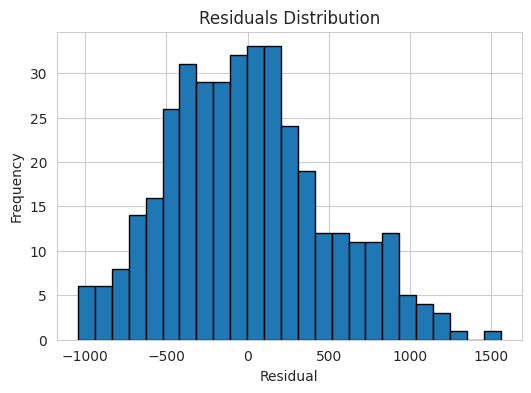

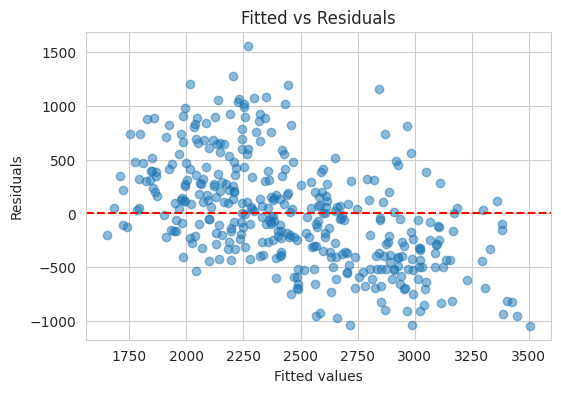

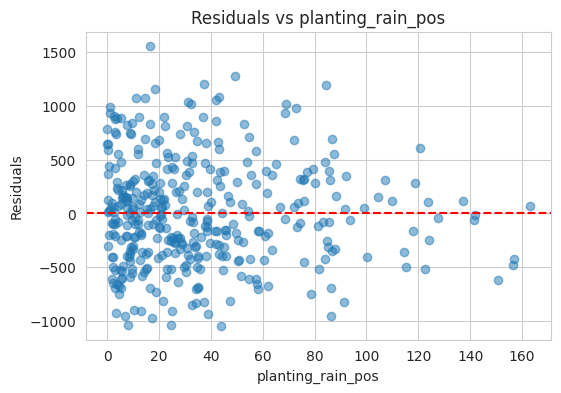

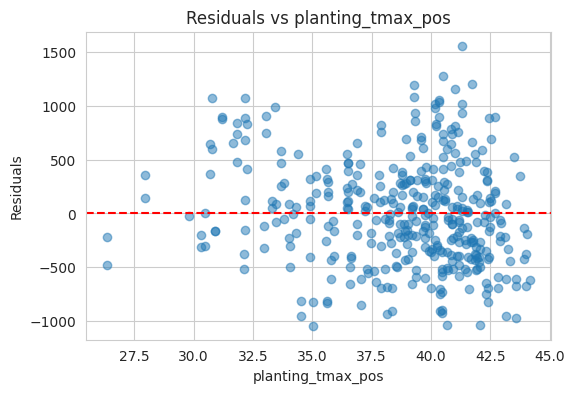

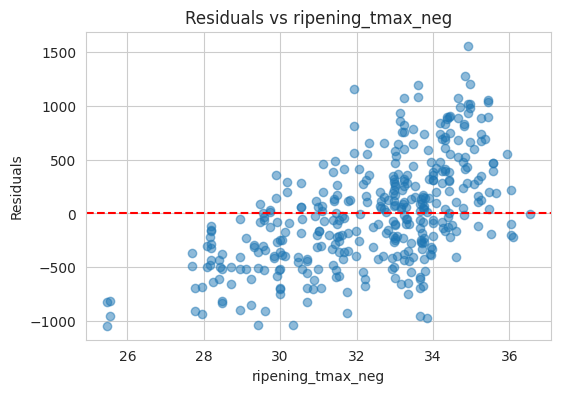

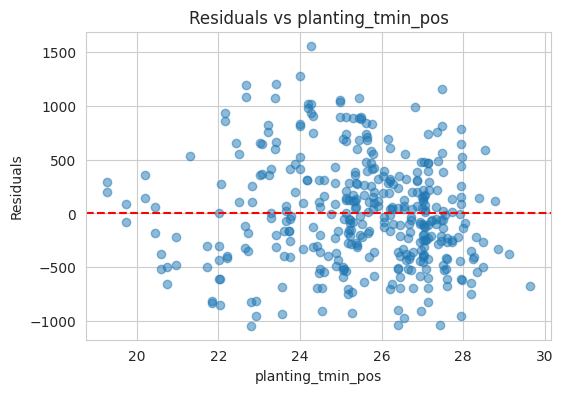

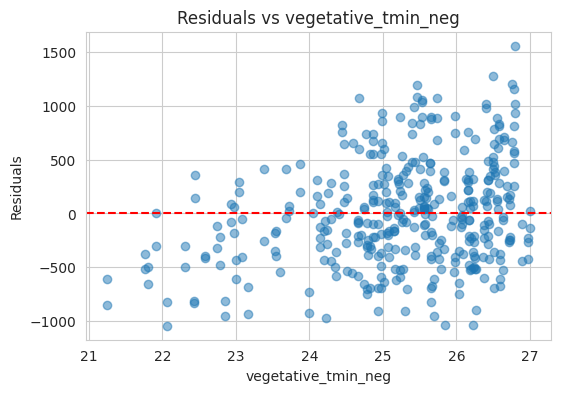

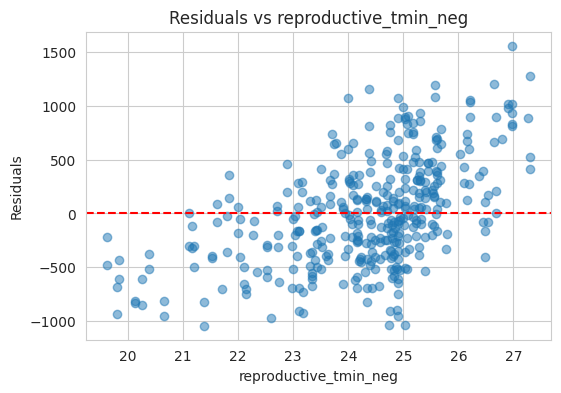


Shapiro-Wilk test: stat=0.9879, p=0.0031
Residuals deviate from normality

RMSE per district (sample period):
District 114: RMSE = 469.296
District 117: RMSE = 411.130
District 129: RMSE = 522.100
District 131: RMSE = 401.527
District 134: RMSE = 438.811
District 141: RMSE = 597.681
District 151: RMSE = 644.382
District 161: RMSE = 450.531
District 169: RMSE = 483.201
District 21: RMSE = 465.520
District 22: RMSE = 540.007
District 31: RMSE = 473.826
District 32: RMSE = 414.007
District 51: RMSE = 549.379
District 54: RMSE = 500.765
District 70: RMSE = 435.696
District 85: RMSE = 587.372
District 86: RMSE = 501.660
District 87: RMSE = 484.241
District 95: RMSE = 445.348
District 99: RMSE = 433.807

Overall RMSE (sample period, used rows): 492.267
Saved sample actual vs predicted to sample_actual_vs_predicted.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Step M: Regenerate features in val & forecast (auto) ===

=== Validation (2023) prediction ===


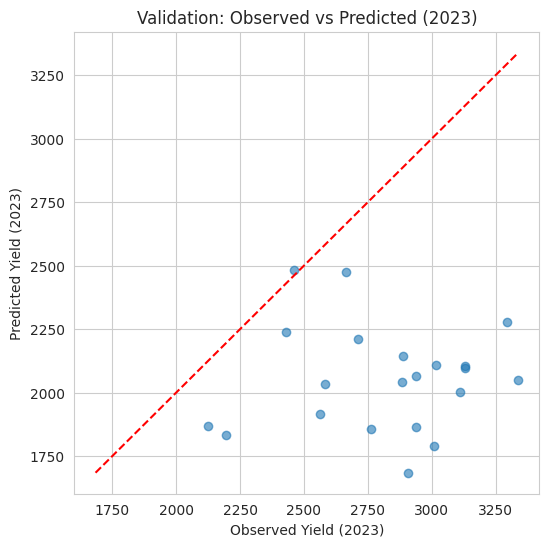

Validation RMSE (2023): 846.906
Saved validation file to validation_2023_actual_vs_predicted.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Forecast (2024-2025) prediction ===
                  yield_predicted
district_id year                 
114         2024      2778.429046
            2025      2620.852444
117         2024      2753.162613
            2025      2745.822089
129         2024      2854.109414
            2025      2653.831860
131         2024      2802.624420
            2025      2633.722560
134         2024      2944.606234
            2025      2821.682930
141         2024      2919.900992
            2025      3027.637627
151         2024      2976.847030
            2025      2699.532074
161         2024      2870.844166
            2025      2618.063024
169         2024      2689.309071
            2025      2410.621203
21          2024      2864.646406
            2025      2663.503083
22          2024      3024.852785
            2025      2809.386602
31          2024      2929.298884
            2025      3070.011241
32          2024      2614.396739
            2025      2393.325526
51     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Pipeline finished. Final variables used: ['final_econ', 'planting_rain_pos', 'reproductive_rain_neg', 'planting_tmax_pos', 'ripening_tmax_neg', 'planting_tmin_pos', 'vegetative_tmin_neg', 'reproductive_tmin_neg']
Feature map keys (sample): ['final_econ', 'planting_rain_pos', 'reproductive_rain_neg', 'planting_tmax_pos', 'ripening_tmax_neg', 'planting_tmin_pos', 'vegetative_tmin_neg', 'reproductive_tmin_neg']


In [ ]:
# =================== FULL FEIS PIPELINE (robust, feature_map integrated) ===================
# NOTE: Run in a single Colab cell.

!pip install linearmodels --quiet

# ------------------- Imports -------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# ------------------- User Config -------------------
ZONE_CLUSTER = 5       # change as needed
P_SIGN = 0.10
VIF_THRESH = 10.0
TRAIN_YEARS = list(range(2005,2023))
VAL_YEAR = 2023
FORECAST_YEARS = [2024, 2025]

# ------------------- Upload Data -------------------
from google.colab import files
print("Upload your CSV file (must include yield_val).")
uploaded = files.upload()
fn = list(uploaded.keys())[0]
df = pd.read_csv(fn)

# ------------------- Standardize Columns -------------------
required_cols = ['district_id','year','zone_cluster','yield_val']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df = df[(df['year'] >= 2005) & (df['year'] <= 2025)].copy()
df['district_id'] = df['district_id'].astype(str)
df['year'] = df['year'].astype(int)
df['zone_cluster'] = df['zone_cluster'].astype(int)

# ------------------- Candidate variable groups (auto-detect) -------------------
econ_candidates_all = [f for f in df.columns if 'econ' in f.lower()]
irrigation_vars_all = [c for c in ['gw_reciprocal','reservoir_intensity','canal_intensity',
                                   'well_intensity','tank_intensity','oth_intensity'] if c in df.columns]
stress_vars_all = [c for c in ['heat_stress','drought'] if c in df.columns]
rain_weeks_all = [f'rf_week{i}' for i in range(20,43) if f'rf_week{i}' in df.columns]
tmax_weeks_all = [f'tmax_week{i}' for i in range(20,43) if f'tmax_week{i}' in df.columns]
tmin_weeks_all = [f'tmin_week{i}' for i in range(20,43) if f'tmin_week{i}' in df.columns]

all_candidates = list(set(econ_candidates_all + irrigation_vars_all +
                          stress_vars_all + rain_weeks_all +
                          tmax_weeks_all + tmin_weeks_all))

# ------------------- Impute Missing Values (within-district ffill/bfill then median) -------------------
if all_candidates:
    df[all_candidates] = df.groupby('district_id')[all_candidates].transform(lambda g: g.ffill().bfill())
    for col in all_candidates:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)

# Keep districts with at least 2 years
district_counts = df.groupby('district_id')['year'].nunique()
df = df[df['district_id'].isin(district_counts[district_counts >= 2].index)]

print("\nData prepared:", df.shape, "years", df['year'].min(), "to", df['year'].max())
print("Zone clusters available:", sorted(df['zone_cluster'].unique()))

# ------------------- Cluster Subset -------------------
cluster = df[df['zone_cluster'] == ZONE_CLUSTER].copy()
if cluster.empty:
    raise ValueError(f"No data for zone_cluster={ZONE_CLUSTER}")

train = cluster[cluster['year'].isin(TRAIN_YEARS)].copy()
val = cluster[cluster['year'] == VAL_YEAR].copy()
forecast_df = cluster[cluster['year'].isin(FORECAST_YEARS)].copy()

if train.empty:
    raise ValueError(f"No training data for zone_cluster={ZONE_CLUSTER}")

print(f"\nWorking on zone_cluster {ZONE_CLUSTER}: train={len(train)}, val={len(val)}, forecast={len(forecast_df)}")

# ------------------- Helper Functions -------------------
def feis_fit(y, X, data):
    """Panel FEIS fit (entity + time effects). X is list of column names in data."""
    try:
        panel = data.set_index(['district_id','year'])
        exog = sm.add_constant(panel[X], has_constant='add')
        mod = PanelOLS(panel[y], exog, entity_effects=True, time_effects=True)
        res = mod.fit(cov_type="robust")
        return res
    except Exception:
        return None

def safe_fit(formula, df):
    try:
        model = sm.OLS.from_formula(formula, df).fit()
        return model
    except Exception:
        return None

# ------------------- Structures to record feature_map & groups -------------------
feature_map = {}
rain_groups = {}
temp_groups = {}
irrig_pos_list, irrig_neg_list = [], []
interaction_kept = []
quad_kept = []

# ------------------- STEP A: Economic Variables -------------------
print("\n=== STEP A: Economic Variable Selection ===")
econ_candidates = econ_candidates_all.copy()
selected_econ = []

for var in econ_candidates:
    if var not in train.columns:
        continue
    res = feis_fit('yield_val', [var], train)
    if res is None:
        continue
    coef = res.params.get(var, np.nan)
    p = res.pvalues.get(var, np.nan)
    print(f" Econ {var}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN) and (coef > 0):
        if not selected_econ:
            selected_econ = [var]
            print(f" -> selected first econ {var}")
        else:
            avg_name = "econ_avg_temp"
            train[avg_name] = train[selected_econ + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', [avg_name], train)
            if res_avg:
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                coef_avg = res_avg.params.get(avg_name, np.nan)
                cur_avg = "econ_avg_current"
                train[cur_avg] = train[selected_econ].mean(axis=1)
                res_current = feis_fit('yield_val', [cur_avg], train)
                p_current = res_current.pvalues.get(cur_avg, np.nan) if res_current else np.nan
                train.drop(columns=[cur_avg], inplace=True, errors='ignore')
                print(f" Averaged {selected_econ + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, vs current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_econ.append(var)
                    print(f" -> kept {var} in econ group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

if selected_econ:
    train['final_econ'] = train[selected_econ].mean(axis=1)
    if not val.empty:
        val['final_econ'] = val[selected_econ].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['final_econ'] = forecast_df[selected_econ].mean(axis=1)
    base_features = ['final_econ']
    feature_map['final_econ'] = list(selected_econ)
else:
    base_features = []
print("Selected economic vars:", selected_econ)

# ------------------- STEP B: GW & Reservoir -------------------
print("\n=== STEP B: GW reciprocal & Reservoir ===")
gw_candidates = ['gw_reciprocal','reservoir_intensity']
for v in gw_candidates:
    if v in train.columns:
        features_to_test = base_features + [v]
        res = feis_fit('yield_val', features_to_test, train)
        if res is None:
            continue
        coef = res.params.get(v, np.nan)
        p = res.pvalues.get(v, np.nan)
        print(f" {v}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(v)
            feature_map[v] = ('raw', v)
            print(f" -> kept {v}")

print("Base features after Step B:", base_features)

# ------------------- STEP C: Rainfall Weekly -------------------
print("\n=== STEP C: Rainfall Weekly Selection ===")
stage_weeks = {
    'planting': list(range(20,29)),
    'vegetative': list(range(29,34)),
    'reproductive': list(range(34,39)),
    'ripening': list(range(39,43))
}

for stage, weeks in stage_weeks.items():
    weekly_cols = [f"rf_week{i}" for i in weeks if f"rf_week{i}" in train.columns]
    if not weekly_cols:
        print(f" No weekly rain cols for {stage}, skipping")
        continue

    print(f"\nTesting {stage} weekly cols: {weekly_cols}")
    pos_candidates, neg_candidates = [], []

    for col in weekly_cols:
        res = feis_fit('yield_val', base_features + [col], train)
        if res is None:
            continue
        coef = res.params.get(col, np.nan)
        p = res.pvalues.get(col, np.nan)
        print(f" {col}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            if coef > 0:
                pos_candidates.append(col)
                print(f"  -> {col} added to positive candidates")
            else:
                neg_candidates.append(col)
                print(f"  -> {col} added to negative candidates")

    # positive sequential averaging
    selected_pos = []
    for var in pos_candidates:
        if not selected_pos:
            selected_pos = [var]
            print(f" -> Selected first positive var for {stage}: {var}")
        else:
            avg_name = f'{stage}_pos_avg_temp'
            train[avg_name] = train[selected_pos + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_pos) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_pos[0]], train)
                    p_current = res_current.pvalues.get(selected_pos[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_pos_avg'
                    train[cur_avg_name] = train[selected_pos].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_pos.append(var)
                    print(f" -> kept {var} in positive group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # negative sequential averaging
    selected_neg = []
    for var in neg_candidates:
        if not selected_neg:
            selected_neg = [var]
            print(f" -> Selected first negative var for {stage}: {var}")
        else:
            avg_name = f'{stage}_neg_avg_temp'
            train[avg_name] = train[selected_neg + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_neg) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_neg[0]], train)
                    p_current = res_current.pvalues.get(selected_neg[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_neg_avg'
                    train[cur_avg_name] = train[selected_neg].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and (p_avg < p_current):
                    selected_neg.append(var)
                    print(f" -> kept {var} in negative group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # Create aggregated variables and record into feature_map
    rain_groups[stage] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

    if selected_pos:
        cname = f"{stage}_rain_pos"
        train[cname] = train[selected_pos].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_pos].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_pos)

    if selected_neg:
        cname = f"{stage}_rain_neg"
        train[cname] = train[selected_neg].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_neg].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_neg)

print("Base features after Step C:", base_features)

# ------------------- STEP D: Temperature Weekly -------------------
print("\n=== STEP D: Temperature Weekly ===")
for temp in ['tmax','tmin']:
    week_cols = [f"{temp}_week{i}" for i in range(20,43) if f"{temp}_week{i}" in train.columns]
    if not week_cols:
        print(f" No weekly {temp} data found, skipping {temp}")
        continue

    for stage, weeks in stage_weeks.items():
        cols = [f"{temp}_week{i}" for i in weeks if f"{temp}_week{i}" in train.columns]
        if not cols:
            continue

        print(f"\nTesting {temp} for stage {stage}: {cols}")
        pos_candidates, neg_candidates = [], []

        for col in cols:
            res = feis_fit('yield_val', base_features + [col], train)
            if res is None:
                continue
            coef = res.params.get(col, np.nan)
            p = res.pvalues.get(col, np.nan)
            print(f" {col}: coef={coef:.6f}, p={p:.4f}")
            if (not np.isnan(p)) and (p < P_SIGN):
                if coef > 0:
                    pos_candidates.append(col)
                    print(f"  -> {col} added to positive candidates")
                else:
                    neg_candidates.append(col)
                    print(f"  -> {col} added to negative candidates")

        # positive sequential averaging
        selected_pos = []
        for var in pos_candidates:
            if not selected_pos:
                selected_pos = [var]
                print(f" -> Selected first positive {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_pos_avg_temp'
                train[avg_name] = train[selected_pos + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_pos] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_pos:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and prev_ok:
                        selected_pos.append(var)
                        print(f" -> kept {var} in positive group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # negative sequential averaging
        selected_neg = []
        for var in neg_candidates:
            if not selected_neg:
                selected_neg = [var]
                print(f" -> Selected first negative {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_neg_avg_temp'
                train[avg_name] = train[selected_neg + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_neg] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_neg:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and prev_ok:
                        selected_neg.append(var)
                        print(f" -> kept {var} in negative group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # Aggregate and record
        key = (stage, temp)
        temp_groups[key] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

        if selected_pos:
            cname = f"{stage}_{temp}_pos"
            train[cname] = train[selected_pos].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_pos].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_pos)

        if selected_neg:
            cname = f"{stage}_{temp}_neg"
            train[cname] = train[selected_neg].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_neg].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_neg)

print("Base features after Step D (Temp):", base_features)

# ------------------- STEP E: Irrigation -------------------
print("\n=== STEP E: Irrigation ===")
irrig_pos_list, irrig_neg_list = [], []
irr_vars = [v for v in ['canal_intensity','well_intensity','tank_intensity','oth_intensity'] if v in train.columns]

for v in irr_vars:
    features_to_test = [f for f in base_features if f not in irrig_pos_list + irrig_neg_list] + [v]
    res = feis_fit('yield_val', features_to_test, train)
    if res is None:
        continue
    coef = res.params.get(v, np.nan)
    p = res.pvalues.get(v, np.nan)
    print(f" {v}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN):
        if coef > 0:
            irrig_pos_list.append(v)
            print(f" -> added to irrigation_pos: {v}")
        else:
            irrig_neg_list.append(v)
            print(f" -> added to irrigation_neg: {v}")

if irrig_pos_list:
    train['irrigation_pos'] = train[irrig_pos_list].mean(axis=1)
    if not val.empty:
        val['irrigation_pos'] = val[irrig_pos_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_pos'] = forecast_df[irrig_pos_list].mean(axis=1)
    base_features.append('irrigation_pos')
    feature_map['irrigation_pos'] = list(irrig_pos_list)

if irrig_neg_list:
    train['irrigation_neg'] = train[irrig_neg_list].mean(axis=1)
    if not val.empty:
        val['irrigation_neg'] = val[irrig_neg_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_neg'] = forecast_df[irrig_neg_list].mean(axis=1)
    base_features.append('irrigation_neg')
    feature_map['irrigation_neg'] = list(irrig_neg_list)

print("Irrigation pos:", irrig_pos_list, "neg:", irrig_neg_list)
print("Base features after irrigation:", base_features)

# ------------------- STEP F: Stress Variables -------------------
print("\n=== STEP F: Stress Variables ===")
for s in ['heat_stress','drought']:
    if s in train.columns:
        res = feis_fit('yield_val', base_features + [s], train)
        if res is None:
            continue
        coef = res.params.get(s, np.nan)
        p = res.pvalues.get(s, np.nan)
        print(f" {s}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(s)
            feature_map[s] = ('raw', s)
            print(f" -> kept {s}")

print("Base features after stress vars:", base_features)

# ------------------- STEP J: Interactions -------------------
print("\n=== STEP J: Interaction testing ===")
current_vars = base_features.copy()

rain_cols = [c for c in current_vars if '_rain_' in c]
irr_cols = [c for c in current_vars if c.startswith('irrigation_')]
reservoir_col = 'reservoir_intensity' if 'reservoir_intensity' in train.columns else None

interaction_candidates = []
for r in rain_cols:
    for i in irr_cols:
        interaction_candidates.append((r, i))
if reservoir_col:
    for r in rain_cols:
        interaction_candidates.append((r, reservoir_col))
    for i in irr_cols:
        interaction_candidates.append((i, reservoir_col))

for var1, var2 in interaction_candidates:
    # guard: both vars must exist in train (sometimes groups missing)
    if var1 not in train.columns or var2 not in train.columns:
        continue
    name = f"{var1}_x_{var2}"
    train[name] = train[var1] * train[var2]
    if not val.empty:
        val[name] = val[var1] * val[var2]
    if not forecast_df.empty:
        forecast_df[name] = forecast_df[var1] * forecast_df[var2]

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [name]), train)
    p_val = res.pvalues.get(name, np.nan) if res is not None else np.nan
    print(f" Interaction {name}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(name)
        interaction_kept.append(name)
        feature_map[name] = ('interaction', var1, var2)
        print(f" -> kept interaction {name}")
    else:
        train.drop(columns=[name], inplace=True, errors='ignore')
        val.drop(columns=[name], inplace=True, errors='ignore')
        forecast_df.drop(columns=[name], inplace=True, errors='ignore')

print("Interactions kept:", interaction_kept)

# ------------------- STEP K: Quadratic Rain -------------------
print("\n=== STEP K: Quadratic rain terms ===")
quad_kept = []
# use current_vars because interactions may have extended it
rain_cols = [c for c in current_vars if '_rain_' in c]
for rcol in rain_cols:
    if rcol not in train.columns:
        continue
    qname = f"{rcol}_sq"
    train[qname] = train[rcol] ** 2
    if not val.empty:
        val[qname] = val[rcol] ** 2
    if not forecast_df.empty:
        forecast_df[qname] = forecast_df[rcol] ** 2

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [qname]), train)
    p_val = res.pvalues.get(qname, np.nan) if res is not None else np.nan
    print(f" Quadratic {qname}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(qname)
        quad_kept.append(qname)
        feature_map[qname] = ('sq', rcol)
        print(f" -> kept quadratic {qname}")
    else:
        train.drop(columns=[qname], inplace=True, errors='ignore')
        val.drop(columns=[qname], inplace=True, errors='ignore')
        forecast_df.drop(columns=[qname], inplace=True, errors='ignore')

print("Quadratic kept:", quad_kept)

# ------------------- STEP L: VIF & p-value pruning -------------------
print("\n=== STEP L: VIF & p-value pruning ===")
final_vars = current_vars.copy()
train_panel = train.set_index(['district_id','year']).sort_index()

def calculate_vif(df, vars_list):
    try:
        X = sm.add_constant(df[vars_list], has_constant='add')
        vif_data = pd.DataFrame()
        vif_data['variable'] = vars_list
        vifs = []
        for i in range(len(vars_list)):
            try:
                vifs.append(variance_inflation_factor(X.values, i+1))
            except Exception:
                vifs.append(np.nan)
        vif_data['VIF'] = vifs
        return vif_data
    except Exception as e:
        return pd.DataFrame({'variable': vars_list, 'VIF': [np.nan]*len(vars_list)})

iteration = 0
while True:
    iteration += 1
    print(f"\nIteration {iteration}: computing VIF")
    vif_df = calculate_vif(train_panel, final_vars)
    print(vif_df)
    # handle all-NaN VIF_df
    if vif_df['VIF'].dropna().empty:
        print("VIFs not available / all NaN; stop VIF pruning.")
        break
    max_vif = vif_df['VIF'].max()
    if max_vif > VIF_THRESH:
        drop_var = vif_df.loc[vif_df['VIF'] == max_vif, 'variable'].values[0]
        print(f" -> dropping {drop_var} due to high VIF {max_vif:.2f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue

    # Fit PanelOLS and check p-values
    X_tmp = sm.add_constant(train_panel[final_vars], has_constant='add')
    y_tmp = train_panel['yield_val']
    try:
        model = PanelOLS(y_tmp, X_tmp, entity_effects=True, time_effects=True).fit(cov_type='robust')
    except Exception as e:
        print(" PanelOLS error during pruning:", e)
        break

    pvals = model.pvalues.drop('const', errors='ignore')
    if (pvals >= P_SIGN).any():
        drop_var = pvals.idxmax()
        print(f" -> dropping {drop_var} due to high p-value {pvals[drop_var]:.4f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue
    else:
        print("All VIFs and p-values OK")
        break

print("\nFinal selected variables (auto-detected):", final_vars)

# ------------------- Final FEIS Model -------------------
print("\n=== Fitting final FEIS model ===")
train_panel = train.set_index(['district_id','year']).sort_index()
# ensure final_vars exist in train_panel (if not, remove missing)
final_vars = [v for v in final_vars if v in train_panel.columns]
X_final = sm.add_constant(train_panel[final_vars], has_constant='add')
y_final = train_panel['yield_val']
res_final = PanelOLS(y_final, X_final, entity_effects=True, time_effects=True).fit(cov_type='robust')
print(res_final.summary)

# ------------------- SAFE Residual Diagnostics & RMSE -------------------
# Build X_full and y_full then determine used rows (no-NaN)
X_full = sm.add_constant(train_panel[final_vars], has_constant='add')
y_full = train_panel['yield_val']
used_mask = X_full.notnull().all(axis=1) & y_full.notnull()
used_index = X_full.index[used_mask]

if len(used_index) == 0:
    raise ValueError("No usable rows for diagnostics after filtering missing values.")

# Fitted using params (only for used_index)
fitted_used = pd.Series(X_full.loc[used_index].dot(res_final.params), index=used_index, name='fitted')

# Create fitted aligned to full train_panel index (NaNs where not available)
fitted = fitted_used.reindex(train_panel.index)

# Residuals (NaN where fitted missing)
residuals = y_full - fitted

print("\nResidual summary statistics (used rows only):")
print(residuals.dropna().describe())

# Plots (drop NaNs where appropriate)
plt.figure(figsize=(6,4))
plt.hist(residuals.dropna(), bins=25, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(fitted.dropna(), residuals.dropna(), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Fitted vs Residuals")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

for var in final_vars:
    if var in X_final.columns:
        plt.figure(figsize=(6,4))
        # align predictor to same index subset
        plt.scatter(X_final[var].loc[fitted.dropna().index], residuals.dropna(), alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f"Residuals vs {var}")
        plt.xlabel(var)
        plt.ylabel("Residuals")
        plt.show()

# Shapiro-Wilk
resid_nonan = residuals.dropna()
if len(resid_nonan) >= 3:
    stat, p_sw = shapiro(resid_nonan)
    print(f"\nShapiro-Wilk test: stat={stat:.4f}, p={p_sw:.4f}")
    print("Residuals roughly normal" if p_sw > 0.05 else "Residuals deviate from normality")
else:
    print("\nNot enough residuals for Shapiro-Wilk test (need >=3).")

# RMSE per district (safe drop NaNs)
rmse_dict = {}
for d in train_panel.index.get_level_values('district_id').unique():
    y_true = y_full.xs(d, level='district_id')
    y_pred = fitted.xs(d, level='district_id')
    df_tmp = pd.concat([y_true, y_pred], axis=1, keys=['y_true','y_pred']).dropna()
    if not df_tmp.empty:
        rmse_dict[d] = np.sqrt(mean_squared_error(df_tmp['y_true'], df_tmp['y_pred']))

print("\nRMSE per district (sample period):")
for d, r in rmse_dict.items():
    print(f"District {d}: RMSE = {r:.3f}")

# Overall RMSE (drop NaNs)
df_all = pd.concat([y_full, fitted], axis=1, keys=['y_true', 'y_pred']).dropna()
overall_rmse = np.sqrt(mean_squared_error(df_all['y_true'], df_all['y_pred']))
print(f"\nOverall RMSE (sample period, used rows): {overall_rmse:.3f}")

# ------------------- Save sample actual vs predicted CSV -------------------
df_sample = df_all.reset_index()[['district_id','year','y_true','y_pred']].rename(columns={'y_true':'yield_actual','y_pred':'yield_predicted'})
out_sample = "sample_actual_vs_predicted.csv"
df_sample.to_csv(out_sample, index=False)
print(f"Saved sample actual vs predicted to {out_sample}")
try:
    files.download(out_sample)
except Exception:
    pass

# ------------------- Feature Regeneration Utility -------------------
def regenerate_features(df_in, feature_map, fill_value=0.0, max_iters=20):
    """Rebuild derived features for df_in using the feature_map.
       Safe: missing raw columns are filled with fill_value (scalar)."""
    df = df_in.copy()
    # prefill missing raw columns referenced in feature_map with fill_value
    for rule in feature_map.values():
        if isinstance(rule, list):
            for c in rule:
                if c not in df.columns:
                    df[c] = fill_value
        elif isinstance(rule, tuple) and rule[0] == 'raw':
            col = rule[1]
            if col not in df.columns:
                df[col] = fill_value

    it = 0
    while it < max_iters:
        it += 1
        changed = False
        for feat, rule in feature_map.items():
            if feat in df.columns:
                continue
            try:
                if isinstance(rule, list):
                    if all([c in df.columns for c in rule]):
                        df[feat] = df[rule].mean(axis=1)
                        changed = True
                elif isinstance(rule, tuple):
                    if rule[0] == 'sq' and rule[1] in df.columns:
                        df[feat] = df[rule[1]] ** 2
                        changed = True
                    elif rule[0] == 'interaction':
                        v1, v2 = rule[1], rule[2]
                        if v1 in df.columns and v2 in df.columns:
                            df[feat] = df[v1] * df[v2]
                            changed = True
                    elif rule[0] == 'raw' and rule[1] in df.columns:
                        df[feat] = df[rule[1]]
                        changed = True
                else:
                    # if rule is string (alias)
                    if isinstance(rule, str) and rule in df.columns:
                        df[feat] = df[rule]
                        changed = True
            except Exception:
                pass
        if not changed:
            break
    return df

# -------------------- Step M: Regenerate features in val & forecast --------------------
print("\n=== Step M: Regenerate features in val & forecast (auto) ===")
if not val.empty:
    val = regenerate_features(val, feature_map)
if not forecast_df.empty:
    forecast_df = regenerate_features(forecast_df, feature_map)

# Ensure all final_vars present in val & forecast (fill with median from train or 0)
for col in final_vars:
    if not val.empty and col not in val.columns:
        val[col] = train[col].median() if col in train.columns else 0.0
    if not forecast_df.empty and col not in forecast_df.columns:
        forecast_df[col] = train[col].median() if col in train.columns else 0.0

# ------------------- Validation (2023) prediction -------------------
print("\n=== Validation (2023) prediction ===")
if not val.empty and VAL_YEAR in val['year'].unique():
    val_panel = val.set_index(['district_id','year']).sort_index()
    X_val = sm.add_constant(val_panel[final_vars], has_constant='add')
    # ensure all params columns exist in X_val
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_val.columns:
            X_val[col] = 0.0
    X_val = X_val[res_final.params.index]  # reorder to match params
    y_val = val_panel['yield_val']
    y_pred_val = pd.Series(X_val.dot(res_final.params), index=X_val.index, name='yield_predicted')

    # align and drop NaNs for RMSE & plotting
    df_val_check = pd.concat([y_val, y_pred_val], axis=1).dropna()
    if df_val_check.empty:
        print("No valid validation rows after alignment (all NaN).")
    else:
        plt.figure(figsize=(6,6))
        plt.scatter(df_val_check.iloc[:,0], df_val_check.iloc[:,1], alpha=0.6)
        mn = min(df_val_check.iloc[:,0].min(), df_val_check.iloc[:,1].min())
        mx = max(df_val_check.iloc[:,0].max(), df_val_check.iloc[:,1].max())
        plt.plot([mn,mx],[mn,mx],'r--')
        plt.xlabel("Observed Yield (2023)")
        plt.ylabel("Predicted Yield (2023)")
        plt.title(f"Validation: Observed vs Predicted ({VAL_YEAR})")
        plt.show()

        val_rmse = np.sqrt(mean_squared_error(df_val_check.iloc[:,0], df_val_check.iloc[:,1]))
        print(f"Validation RMSE (2023): {val_rmse:.3f}")

    # Save validation CSV (actual + predicted)
    df_val_out = df_val_check.reset_index().rename(columns={df_val_check.columns[0]:'yield_actual', df_val_check.columns[1]:'yield_predicted'})
    out_val = "validation_2023_actual_vs_predicted.csv"
    df_val_out.to_csv(out_val, index=False)
    print(f"Saved validation file to {out_val}")
    try:
        files.download(out_val)
    except Exception:
        pass

# ------------------- Forecast (2024-2025) prediction -------------------
print("\n=== Forecast (2024-2025) prediction ===")
if not forecast_df.empty:
    forecast_panel = forecast_df.set_index(['district_id','year']).sort_index()
    X_fore = sm.add_constant(forecast_panel[final_vars], has_constant='add')
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_fore.columns:
            X_fore[col] = 0.0
    X_fore = X_fore[res_final.params.index]
    y_fore_pred = pd.Series(X_fore.dot(res_final.params), index=X_fore.index, name='yield_predicted')

    # attach forecast predictions back to panel
    forecast_out = forecast_panel.copy()
    forecast_out['yield_predicted'] = np.nan
    forecast_out.loc[y_fore_pred.index, 'yield_predicted'] = y_fore_pred.values

    print(forecast_out[['yield_predicted']].dropna().head(40))

    # Save forecast CSV
    df_fore_out = forecast_out.reset_index()[['district_id','year','yield_predicted']]
    out_fore = "forecast_2024_2025_predicted.csv"
    df_fore_out.to_csv(out_fore, index=False)
    print(f"Saved forecast file to {out_fore}")
    try:
        files.download(out_fore)
    except Exception:
        pass

# ------------------- Done -------------------
print("\nPipeline finished. Final variables used:", final_vars)
print("Feature map keys (sample):", list(feature_map.keys())[:40])


<font color ='blue'> <font size ='5'> **Zone_cluster = 6**

Upload your CSV file (must include yield_val).


Saving data1.csv to data1 (6).csv

Data prepared: (3612, 209) years 2005 to 2025
Zone clusters available: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Working on zone_cluster 6: train=810, val=45, forecast=90

=== STEP A: Economic Variable Selection ===
 Econ econ_inc_rev1: coef=0.011246, p=0.0000
 -> selected first econ econ_inc_rev1
 Econ econ_inc_rev2: coef=0.010157, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev2'] -> coef=0.010748, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev3: coef=0.011326, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev3'] -> coef=0.011520, p=0.0000, vs current p=0.0000
 -> kept econ_inc_rev3 in econ group
 Econ econ_inc_rev4: coef=0.009805, p=0.0001
 Averaged ['econ_inc_rev1', 'econ_inc_rev3', 'econ_inc_rev4'] -> coef=0.011247, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev5: coef=0.010766, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev3', 'econ_inc_rev5'] -> coef=0.011490, p=0.0000, vs current p=0.0000
 Econ

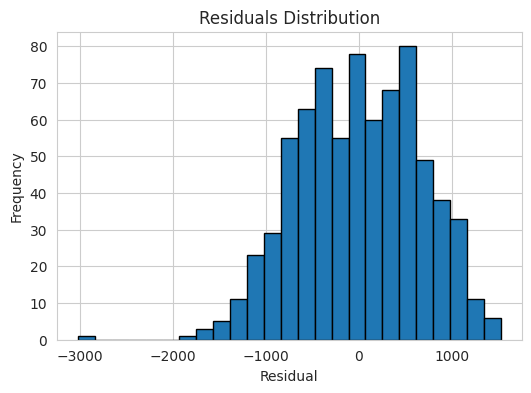

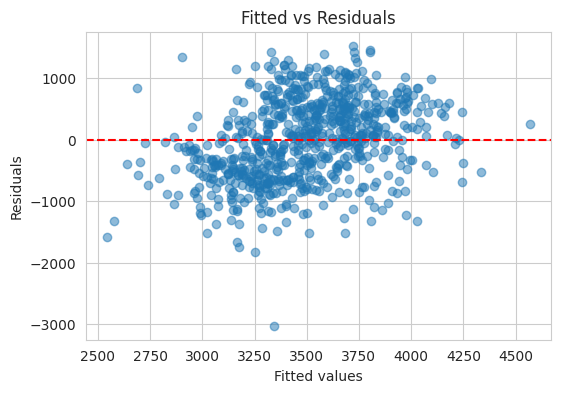

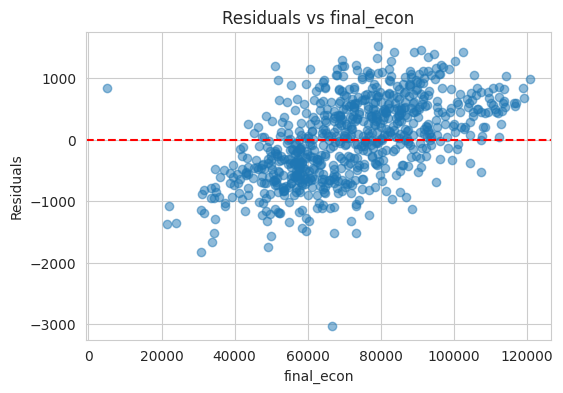

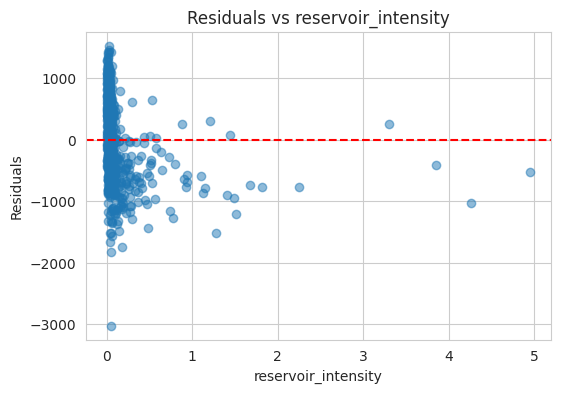

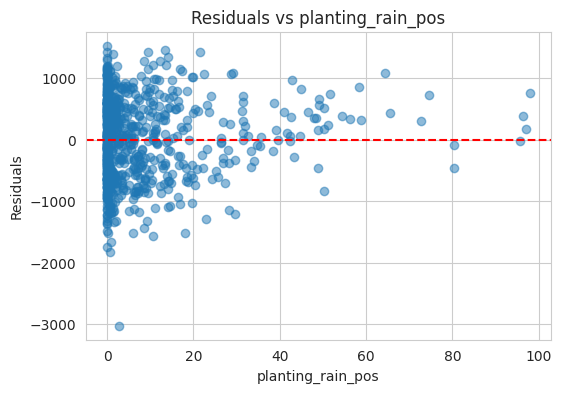

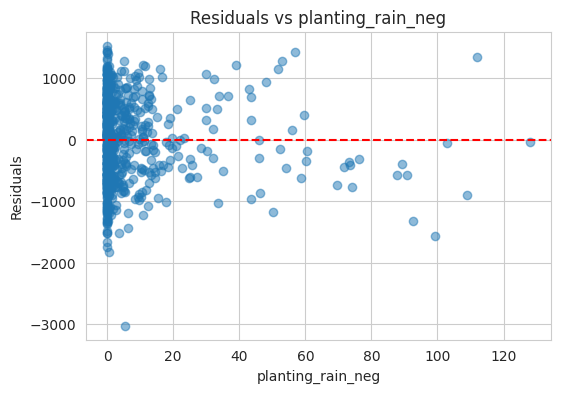

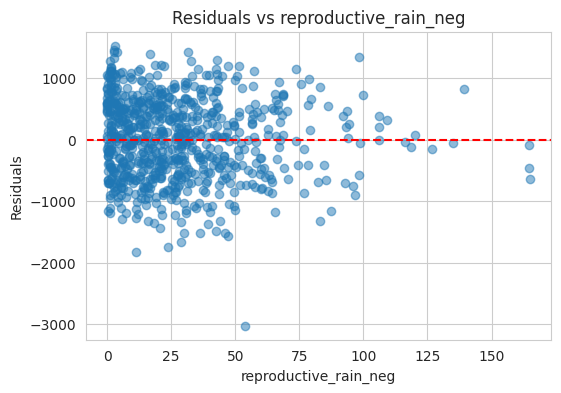

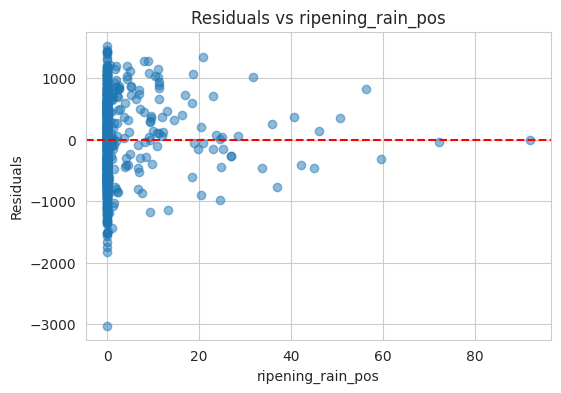

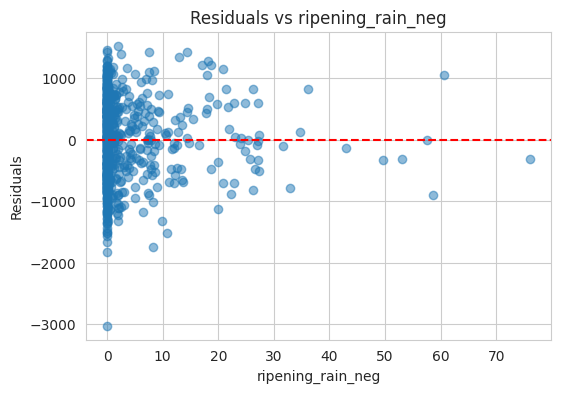

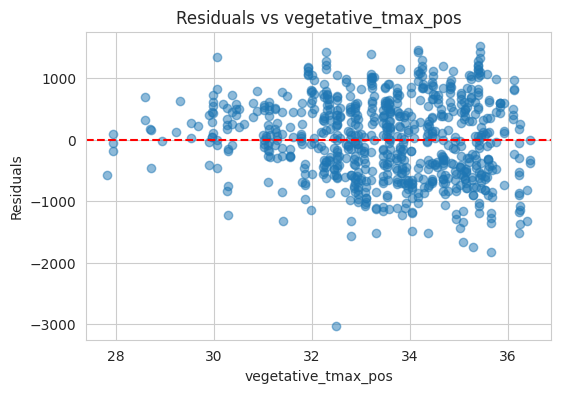

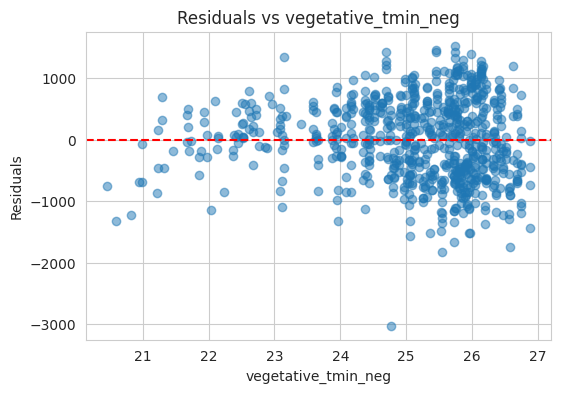


Shapiro-Wilk test: stat=0.9895, p=0.0000
Residuals deviate from normality

RMSE per district (sample period):
District 100: RMSE = 912.164
District 108: RMSE = 716.047
District 113: RMSE = 892.442
District 116: RMSE = 494.594
District 119: RMSE = 360.223
District 122: RMSE = 688.578
District 123: RMSE = 551.531
District 124: RMSE = 625.000
District 125: RMSE = 558.588
District 127: RMSE = 838.703
District 128: RMSE = 581.123
District 137: RMSE = 819.604
District 138: RMSE = 1052.055
District 139: RMSE = 361.286
District 142: RMSE = 272.244
District 144: RMSE = 1023.102
District 160: RMSE = 813.147
District 163: RMSE = 663.680
District 165: RMSE = 483.082
District 172: RMSE = 348.799
District 23: RMSE = 1049.497
District 26: RMSE = 758.227
District 29: RMSE = 977.735
District 36: RMSE = 962.375
District 49: RMSE = 693.261
District 50: RMSE = 566.884
District 52: RMSE = 584.019
District 53: RMSE = 679.408
District 55: RMSE = 373.518
District 57: RMSE = 667.358
District 6: RMSE = 316.000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Step M: Regenerate features in val & forecast (auto) ===

=== Validation (2023) prediction ===


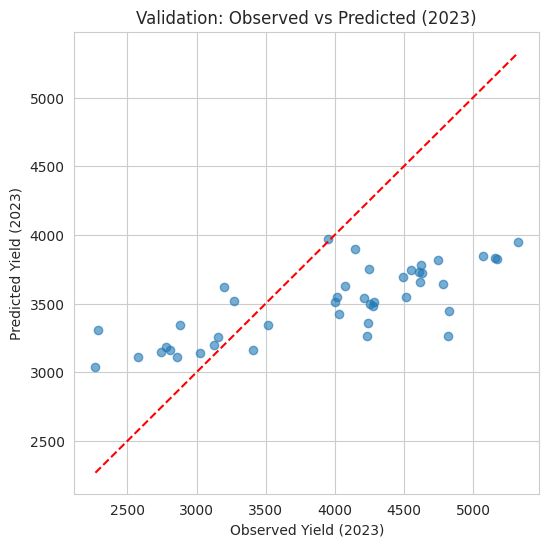

Validation RMSE (2023): 796.589
Saved validation file to validation_2023_actual_vs_predicted.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Forecast (2024-2025) prediction ===
                  yield_predicted
district_id year                 
100         2024      4203.948761
            2025      4338.575203
102         2024      2825.027077
            2025      3089.591474
105         2024      3007.977307
            2025      3138.809001
108         2024      3970.292732
            2025      4169.903209
113         2024      4213.334789
            2025      4381.242295
116         2024      3856.135096
            2025      4051.868540
119         2024      4261.052155
            2025      4384.031986
122         2024      2936.962708
            2025      3143.838605
123         2024      3034.636750
            2025      3281.518631
124         2024      3743.549362
            2025      3831.554979
125         2024      3206.770182
            2025      3349.502968
127         2024      4455.121908
            2025      4360.717245
128         2024      4100.803265
            2025      4156.955243
137    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Pipeline finished. Final variables used: ['final_econ', 'reservoir_intensity', 'planting_rain_pos', 'planting_rain_neg', 'reproductive_rain_neg', 'ripening_rain_pos', 'ripening_rain_neg', 'vegetative_tmax_pos', 'vegetative_tmin_neg']
Feature map keys (sample): ['final_econ', 'reservoir_intensity', 'planting_rain_pos', 'planting_rain_neg', 'reproductive_rain_neg', 'ripening_rain_pos', 'ripening_rain_neg', 'vegetative_tmax_pos', 'vegetative_tmin_neg']


In [ ]:
# =================== FULL FEIS PIPELINE (robust, feature_map integrated) ===================
# NOTE: Run in a single Colab cell.

!pip install linearmodels --quiet

# ------------------- Imports -------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# ------------------- User Config -------------------
ZONE_CLUSTER = 6       # change as needed
P_SIGN = 0.10
VIF_THRESH = 10.0
TRAIN_YEARS = list(range(2005,2023))
VAL_YEAR = 2023
FORECAST_YEARS = [2024, 2025]

# ------------------- Upload Data -------------------
from google.colab import files
print("Upload your CSV file (must include yield_val).")
uploaded = files.upload()
fn = list(uploaded.keys())[0]
df = pd.read_csv(fn)

# ------------------- Standardize Columns -------------------
required_cols = ['district_id','year','zone_cluster','yield_val']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df = df[(df['year'] >= 2005) & (df['year'] <= 2025)].copy()
df['district_id'] = df['district_id'].astype(str)
df['year'] = df['year'].astype(int)
df['zone_cluster'] = df['zone_cluster'].astype(int)

# ------------------- Candidate variable groups (auto-detect) -------------------
econ_candidates_all = [f for f in df.columns if 'econ' in f.lower()]
irrigation_vars_all = [c for c in ['gw_reciprocal','reservoir_intensity','canal_intensity',
                                   'well_intensity','tank_intensity','oth_intensity'] if c in df.columns]
stress_vars_all = [c for c in ['heat_stress','drought'] if c in df.columns]
rain_weeks_all = [f'rf_week{i}' for i in range(20,43) if f'rf_week{i}' in df.columns]
tmax_weeks_all = [f'tmax_week{i}' for i in range(20,43) if f'tmax_week{i}' in df.columns]
tmin_weeks_all = [f'tmin_week{i}' for i in range(20,43) if f'tmin_week{i}' in df.columns]

all_candidates = list(set(econ_candidates_all + irrigation_vars_all +
                          stress_vars_all + rain_weeks_all +
                          tmax_weeks_all + tmin_weeks_all))

# ------------------- Impute Missing Values (within-district ffill/bfill then median) -------------------
if all_candidates:
    df[all_candidates] = df.groupby('district_id')[all_candidates].transform(lambda g: g.ffill().bfill())
    for col in all_candidates:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)

# Keep districts with at least 2 years
district_counts = df.groupby('district_id')['year'].nunique()
df = df[df['district_id'].isin(district_counts[district_counts >= 2].index)]

print("\nData prepared:", df.shape, "years", df['year'].min(), "to", df['year'].max())
print("Zone clusters available:", sorted(df['zone_cluster'].unique()))

# ------------------- Cluster Subset -------------------
cluster = df[df['zone_cluster'] == ZONE_CLUSTER].copy()
if cluster.empty:
    raise ValueError(f"No data for zone_cluster={ZONE_CLUSTER}")

train = cluster[cluster['year'].isin(TRAIN_YEARS)].copy()
val = cluster[cluster['year'] == VAL_YEAR].copy()
forecast_df = cluster[cluster['year'].isin(FORECAST_YEARS)].copy()

if train.empty:
    raise ValueError(f"No training data for zone_cluster={ZONE_CLUSTER}")

print(f"\nWorking on zone_cluster {ZONE_CLUSTER}: train={len(train)}, val={len(val)}, forecast={len(forecast_df)}")

# ------------------- Helper Functions -------------------
def feis_fit(y, X, data):
    """Panel FEIS fit (entity + time effects). X is list of column names in data."""
    try:
        panel = data.set_index(['district_id','year'])
        exog = sm.add_constant(panel[X], has_constant='add')
        mod = PanelOLS(panel[y], exog, entity_effects=True, time_effects=True)
        res = mod.fit(cov_type="robust")
        return res
    except Exception:
        return None

def safe_fit(formula, df):
    try:
        model = sm.OLS.from_formula(formula, df).fit()
        return model
    except Exception:
        return None

# ------------------- Structures to record feature_map & groups -------------------
feature_map = {}
rain_groups = {}
temp_groups = {}
irrig_pos_list, irrig_neg_list = [], []
interaction_kept = []
quad_kept = []

# ------------------- STEP A: Economic Variables -------------------
print("\n=== STEP A: Economic Variable Selection ===")
econ_candidates = econ_candidates_all.copy()
selected_econ = []

for var in econ_candidates:
    if var not in train.columns:
        continue
    res = feis_fit('yield_val', [var], train)
    if res is None:
        continue
    coef = res.params.get(var, np.nan)
    p = res.pvalues.get(var, np.nan)
    print(f" Econ {var}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN) and (coef > 0):
        if not selected_econ:
            selected_econ = [var]
            print(f" -> selected first econ {var}")
        else:
            avg_name = "econ_avg_temp"
            train[avg_name] = train[selected_econ + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', [avg_name], train)
            if res_avg:
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                coef_avg = res_avg.params.get(avg_name, np.nan)
                cur_avg = "econ_avg_current"
                train[cur_avg] = train[selected_econ].mean(axis=1)
                res_current = feis_fit('yield_val', [cur_avg], train)
                p_current = res_current.pvalues.get(cur_avg, np.nan) if res_current else np.nan
                train.drop(columns=[cur_avg], inplace=True, errors='ignore')
                print(f" Averaged {selected_econ + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, vs current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_econ.append(var)
                    print(f" -> kept {var} in econ group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

if selected_econ:
    train['final_econ'] = train[selected_econ].mean(axis=1)
    if not val.empty:
        val['final_econ'] = val[selected_econ].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['final_econ'] = forecast_df[selected_econ].mean(axis=1)
    base_features = ['final_econ']
    feature_map['final_econ'] = list(selected_econ)
else:
    base_features = []
print("Selected economic vars:", selected_econ)

# ------------------- STEP B: GW & Reservoir -------------------
print("\n=== STEP B: GW reciprocal & Reservoir ===")
gw_candidates = ['gw_reciprocal','reservoir_intensity']
for v in gw_candidates:
    if v in train.columns:
        features_to_test = base_features + [v]
        res = feis_fit('yield_val', features_to_test, train)
        if res is None:
            continue
        coef = res.params.get(v, np.nan)
        p = res.pvalues.get(v, np.nan)
        print(f" {v}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(v)
            feature_map[v] = ('raw', v)
            print(f" -> kept {v}")

print("Base features after Step B:", base_features)

# ------------------- STEP C: Rainfall Weekly -------------------
print("\n=== STEP C: Rainfall Weekly Selection ===")
stage_weeks = {
    'planting': list(range(20,29)),
    'vegetative': list(range(29,34)),
    'reproductive': list(range(34,39)),
    'ripening': list(range(39,43))
}

for stage, weeks in stage_weeks.items():
    weekly_cols = [f"rf_week{i}" for i in weeks if f"rf_week{i}" in train.columns]
    if not weekly_cols:
        print(f" No weekly rain cols for {stage}, skipping")
        continue

    print(f"\nTesting {stage} weekly cols: {weekly_cols}")
    pos_candidates, neg_candidates = [], []

    for col in weekly_cols:
        res = feis_fit('yield_val', base_features + [col], train)
        if res is None:
            continue
        coef = res.params.get(col, np.nan)
        p = res.pvalues.get(col, np.nan)
        print(f" {col}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            if coef > 0:
                pos_candidates.append(col)
                print(f"  -> {col} added to positive candidates")
            else:
                neg_candidates.append(col)
                print(f"  -> {col} added to negative candidates")

    # positive sequential averaging
    selected_pos = []
    for var in pos_candidates:
        if not selected_pos:
            selected_pos = [var]
            print(f" -> Selected first positive var for {stage}: {var}")
        else:
            avg_name = f'{stage}_pos_avg_temp'
            train[avg_name] = train[selected_pos + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_pos) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_pos[0]], train)
                    p_current = res_current.pvalues.get(selected_pos[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_pos_avg'
                    train[cur_avg_name] = train[selected_pos].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_pos.append(var)
                    print(f" -> kept {var} in positive group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # negative sequential averaging
    selected_neg = []
    for var in neg_candidates:
        if not selected_neg:
            selected_neg = [var]
            print(f" -> Selected first negative var for {stage}: {var}")
        else:
            avg_name = f'{stage}_neg_avg_temp'
            train[avg_name] = train[selected_neg + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_neg) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_neg[0]], train)
                    p_current = res_current.pvalues.get(selected_neg[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_neg_avg'
                    train[cur_avg_name] = train[selected_neg].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and (p_avg < p_current):
                    selected_neg.append(var)
                    print(f" -> kept {var} in negative group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # Create aggregated variables and record into feature_map
    rain_groups[stage] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

    if selected_pos:
        cname = f"{stage}_rain_pos"
        train[cname] = train[selected_pos].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_pos].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_pos)

    if selected_neg:
        cname = f"{stage}_rain_neg"
        train[cname] = train[selected_neg].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_neg].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_neg)

print("Base features after Step C:", base_features)

# ------------------- STEP D: Temperature Weekly -------------------
print("\n=== STEP D: Temperature Weekly ===")
for temp in ['tmax','tmin']:
    week_cols = [f"{temp}_week{i}" for i in range(20,43) if f"{temp}_week{i}" in train.columns]
    if not week_cols:
        print(f" No weekly {temp} data found, skipping {temp}")
        continue

    for stage, weeks in stage_weeks.items():
        cols = [f"{temp}_week{i}" for i in weeks if f"{temp}_week{i}" in train.columns]
        if not cols:
            continue

        print(f"\nTesting {temp} for stage {stage}: {cols}")
        pos_candidates, neg_candidates = [], []

        for col in cols:
            res = feis_fit('yield_val', base_features + [col], train)
            if res is None:
                continue
            coef = res.params.get(col, np.nan)
            p = res.pvalues.get(col, np.nan)
            print(f" {col}: coef={coef:.6f}, p={p:.4f}")
            if (not np.isnan(p)) and (p < P_SIGN):
                if coef > 0:
                    pos_candidates.append(col)
                    print(f"  -> {col} added to positive candidates")
                else:
                    neg_candidates.append(col)
                    print(f"  -> {col} added to negative candidates")

        # positive sequential averaging
        selected_pos = []
        for var in pos_candidates:
            if not selected_pos:
                selected_pos = [var]
                print(f" -> Selected first positive {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_pos_avg_temp'
                train[avg_name] = train[selected_pos + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_pos] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_pos:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and prev_ok:
                        selected_pos.append(var)
                        print(f" -> kept {var} in positive group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # negative sequential averaging
        selected_neg = []
        for var in neg_candidates:
            if not selected_neg:
                selected_neg = [var]
                print(f" -> Selected first negative {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_neg_avg_temp'
                train[avg_name] = train[selected_neg + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_neg] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_neg:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and prev_ok:
                        selected_neg.append(var)
                        print(f" -> kept {var} in negative group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # Aggregate and record
        key = (stage, temp)
        temp_groups[key] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

        if selected_pos:
            cname = f"{stage}_{temp}_pos"
            train[cname] = train[selected_pos].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_pos].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_pos)

        if selected_neg:
            cname = f"{stage}_{temp}_neg"
            train[cname] = train[selected_neg].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_neg].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_neg)

print("Base features after Step D (Temp):", base_features)

# ------------------- STEP E: Irrigation -------------------
print("\n=== STEP E: Irrigation ===")
irrig_pos_list, irrig_neg_list = [], []
irr_vars = [v for v in ['canal_intensity','well_intensity','tank_intensity','oth_intensity'] if v in train.columns]

for v in irr_vars:
    features_to_test = [f for f in base_features if f not in irrig_pos_list + irrig_neg_list] + [v]
    res = feis_fit('yield_val', features_to_test, train)
    if res is None:
        continue
    coef = res.params.get(v, np.nan)
    p = res.pvalues.get(v, np.nan)
    print(f" {v}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN):
        if coef > 0:
            irrig_pos_list.append(v)
            print(f" -> added to irrigation_pos: {v}")
        else:
            irrig_neg_list.append(v)
            print(f" -> added to irrigation_neg: {v}")

if irrig_pos_list:
    train['irrigation_pos'] = train[irrig_pos_list].mean(axis=1)
    if not val.empty:
        val['irrigation_pos'] = val[irrig_pos_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_pos'] = forecast_df[irrig_pos_list].mean(axis=1)
    base_features.append('irrigation_pos')
    feature_map['irrigation_pos'] = list(irrig_pos_list)

if irrig_neg_list:
    train['irrigation_neg'] = train[irrig_neg_list].mean(axis=1)
    if not val.empty:
        val['irrigation_neg'] = val[irrig_neg_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_neg'] = forecast_df[irrig_neg_list].mean(axis=1)
    base_features.append('irrigation_neg')
    feature_map['irrigation_neg'] = list(irrig_neg_list)

print("Irrigation pos:", irrig_pos_list, "neg:", irrig_neg_list)
print("Base features after irrigation:", base_features)

# ------------------- STEP F: Stress Variables -------------------
print("\n=== STEP F: Stress Variables ===")
for s in ['heat_stress','drought']:
    if s in train.columns:
        res = feis_fit('yield_val', base_features + [s], train)
        if res is None:
            continue
        coef = res.params.get(s, np.nan)
        p = res.pvalues.get(s, np.nan)
        print(f" {s}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(s)
            feature_map[s] = ('raw', s)
            print(f" -> kept {s}")

print("Base features after stress vars:", base_features)

# ------------------- STEP J: Interactions -------------------
print("\n=== STEP J: Interaction testing ===")
current_vars = base_features.copy()

rain_cols = [c for c in current_vars if '_rain_' in c]
irr_cols = [c for c in current_vars if c.startswith('irrigation_')]
reservoir_col = 'reservoir_intensity' if 'reservoir_intensity' in train.columns else None

interaction_candidates = []
for r in rain_cols:
    for i in irr_cols:
        interaction_candidates.append((r, i))
if reservoir_col:
    for r in rain_cols:
        interaction_candidates.append((r, reservoir_col))
    for i in irr_cols:
        interaction_candidates.append((i, reservoir_col))

for var1, var2 in interaction_candidates:
    # guard: both vars must exist in train (sometimes groups missing)
    if var1 not in train.columns or var2 not in train.columns:
        continue
    name = f"{var1}_x_{var2}"
    train[name] = train[var1] * train[var2]
    if not val.empty:
        val[name] = val[var1] * val[var2]
    if not forecast_df.empty:
        forecast_df[name] = forecast_df[var1] * forecast_df[var2]

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [name]), train)
    p_val = res.pvalues.get(name, np.nan) if res is not None else np.nan
    print(f" Interaction {name}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(name)
        interaction_kept.append(name)
        feature_map[name] = ('interaction', var1, var2)
        print(f" -> kept interaction {name}")
    else:
        train.drop(columns=[name], inplace=True, errors='ignore')
        val.drop(columns=[name], inplace=True, errors='ignore')
        forecast_df.drop(columns=[name], inplace=True, errors='ignore')

print("Interactions kept:", interaction_kept)

# ------------------- STEP K: Quadratic Rain -------------------
print("\n=== STEP K: Quadratic rain terms ===")
quad_kept = []
# use current_vars because interactions may have extended it
rain_cols = [c for c in current_vars if '_rain_' in c]
for rcol in rain_cols:
    if rcol not in train.columns:
        continue
    qname = f"{rcol}_sq"
    train[qname] = train[rcol] ** 2
    if not val.empty:
        val[qname] = val[rcol] ** 2
    if not forecast_df.empty:
        forecast_df[qname] = forecast_df[rcol] ** 2

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [qname]), train)
    p_val = res.pvalues.get(qname, np.nan) if res is not None else np.nan
    print(f" Quadratic {qname}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(qname)
        quad_kept.append(qname)
        feature_map[qname] = ('sq', rcol)
        print(f" -> kept quadratic {qname}")
    else:
        train.drop(columns=[qname], inplace=True, errors='ignore')
        val.drop(columns=[qname], inplace=True, errors='ignore')
        forecast_df.drop(columns=[qname], inplace=True, errors='ignore')

print("Quadratic kept:", quad_kept)

# ------------------- STEP L: VIF & p-value pruning -------------------
print("\n=== STEP L: VIF & p-value pruning ===")
final_vars = current_vars.copy()
train_panel = train.set_index(['district_id','year']).sort_index()

def calculate_vif(df, vars_list):
    try:
        X = sm.add_constant(df[vars_list], has_constant='add')
        vif_data = pd.DataFrame()
        vif_data['variable'] = vars_list
        vifs = []
        for i in range(len(vars_list)):
            try:
                vifs.append(variance_inflation_factor(X.values, i+1))
            except Exception:
                vifs.append(np.nan)
        vif_data['VIF'] = vifs
        return vif_data
    except Exception as e:
        return pd.DataFrame({'variable': vars_list, 'VIF': [np.nan]*len(vars_list)})

iteration = 0
while True:
    iteration += 1
    print(f"\nIteration {iteration}: computing VIF")
    vif_df = calculate_vif(train_panel, final_vars)
    print(vif_df)
    # handle all-NaN VIF_df
    if vif_df['VIF'].dropna().empty:
        print("VIFs not available / all NaN; stop VIF pruning.")
        break
    max_vif = vif_df['VIF'].max()
    if max_vif > VIF_THRESH:
        drop_var = vif_df.loc[vif_df['VIF'] == max_vif, 'variable'].values[0]
        print(f" -> dropping {drop_var} due to high VIF {max_vif:.2f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue

    # Fit PanelOLS and check p-values
    X_tmp = sm.add_constant(train_panel[final_vars], has_constant='add')
    y_tmp = train_panel['yield_val']
    try:
        model = PanelOLS(y_tmp, X_tmp, entity_effects=True, time_effects=True).fit(cov_type='robust')
    except Exception as e:
        print(" PanelOLS error during pruning:", e)
        break

    pvals = model.pvalues.drop('const', errors='ignore')
    if (pvals >= P_SIGN).any():
        drop_var = pvals.idxmax()
        print(f" -> dropping {drop_var} due to high p-value {pvals[drop_var]:.4f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue
    else:
        print("All VIFs and p-values OK")
        break

print("\nFinal selected variables (auto-detected):", final_vars)

# ------------------- Final FEIS Model -------------------
print("\n=== Fitting final FEIS model ===")
train_panel = train.set_index(['district_id','year']).sort_index()
# ensure final_vars exist in train_panel (if not, remove missing)
final_vars = [v for v in final_vars if v in train_panel.columns]
X_final = sm.add_constant(train_panel[final_vars], has_constant='add')
y_final = train_panel['yield_val']
res_final = PanelOLS(y_final, X_final, entity_effects=True, time_effects=True).fit(cov_type='robust')
print(res_final.summary)

# ------------------- SAFE Residual Diagnostics & RMSE -------------------
# Build X_full and y_full then determine used rows (no-NaN)
X_full = sm.add_constant(train_panel[final_vars], has_constant='add')
y_full = train_panel['yield_val']
used_mask = X_full.notnull().all(axis=1) & y_full.notnull()
used_index = X_full.index[used_mask]

if len(used_index) == 0:
    raise ValueError("No usable rows for diagnostics after filtering missing values.")

# Fitted using params (only for used_index)
fitted_used = pd.Series(X_full.loc[used_index].dot(res_final.params), index=used_index, name='fitted')

# Create fitted aligned to full train_panel index (NaNs where not available)
fitted = fitted_used.reindex(train_panel.index)

# Residuals (NaN where fitted missing)
residuals = y_full - fitted

print("\nResidual summary statistics (used rows only):")
print(residuals.dropna().describe())

# Plots (drop NaNs where appropriate)
plt.figure(figsize=(6,4))
plt.hist(residuals.dropna(), bins=25, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(fitted.dropna(), residuals.dropna(), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Fitted vs Residuals")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

for var in final_vars:
    if var in X_final.columns:
        plt.figure(figsize=(6,4))
        # align predictor to same index subset
        plt.scatter(X_final[var].loc[fitted.dropna().index], residuals.dropna(), alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f"Residuals vs {var}")
        plt.xlabel(var)
        plt.ylabel("Residuals")
        plt.show()

# Shapiro-Wilk
resid_nonan = residuals.dropna()
if len(resid_nonan) >= 3:
    stat, p_sw = shapiro(resid_nonan)
    print(f"\nShapiro-Wilk test: stat={stat:.4f}, p={p_sw:.4f}")
    print("Residuals roughly normal" if p_sw > 0.05 else "Residuals deviate from normality")
else:
    print("\nNot enough residuals for Shapiro-Wilk test (need >=3).")

# RMSE per district (safe drop NaNs)
rmse_dict = {}
for d in train_panel.index.get_level_values('district_id').unique():
    y_true = y_full.xs(d, level='district_id')
    y_pred = fitted.xs(d, level='district_id')
    df_tmp = pd.concat([y_true, y_pred], axis=1, keys=['y_true','y_pred']).dropna()
    if not df_tmp.empty:
        rmse_dict[d] = np.sqrt(mean_squared_error(df_tmp['y_true'], df_tmp['y_pred']))

print("\nRMSE per district (sample period):")
for d, r in rmse_dict.items():
    print(f"District {d}: RMSE = {r:.3f}")

# Overall RMSE (drop NaNs)
df_all = pd.concat([y_full, fitted], axis=1, keys=['y_true', 'y_pred']).dropna()
overall_rmse = np.sqrt(mean_squared_error(df_all['y_true'], df_all['y_pred']))
print(f"\nOverall RMSE (sample period, used rows): {overall_rmse:.3f}")

# ------------------- Save sample actual vs predicted CSV -------------------
df_sample = df_all.reset_index()[['district_id','year','y_true','y_pred']].rename(columns={'y_true':'yield_actual','y_pred':'yield_predicted'})
out_sample = "sample_actual_vs_predicted.csv"
df_sample.to_csv(out_sample, index=False)
print(f"Saved sample actual vs predicted to {out_sample}")
try:
    files.download(out_sample)
except Exception:
    pass

# ------------------- Feature Regeneration Utility -------------------
def regenerate_features(df_in, feature_map, fill_value=0.0, max_iters=20):
    """Rebuild derived features for df_in using the feature_map.
       Safe: missing raw columns are filled with fill_value (scalar)."""
    df = df_in.copy()
    # prefill missing raw columns referenced in feature_map with fill_value
    for rule in feature_map.values():
        if isinstance(rule, list):
            for c in rule:
                if c not in df.columns:
                    df[c] = fill_value
        elif isinstance(rule, tuple) and rule[0] == 'raw':
            col = rule[1]
            if col not in df.columns:
                df[col] = fill_value

    it = 0
    while it < max_iters:
        it += 1
        changed = False
        for feat, rule in feature_map.items():
            if feat in df.columns:
                continue
            try:
                if isinstance(rule, list):
                    if all([c in df.columns for c in rule]):
                        df[feat] = df[rule].mean(axis=1)
                        changed = True
                elif isinstance(rule, tuple):
                    if rule[0] == 'sq' and rule[1] in df.columns:
                        df[feat] = df[rule[1]] ** 2
                        changed = True
                    elif rule[0] == 'interaction':
                        v1, v2 = rule[1], rule[2]
                        if v1 in df.columns and v2 in df.columns:
                            df[feat] = df[v1] * df[v2]
                            changed = True
                    elif rule[0] == 'raw' and rule[1] in df.columns:
                        df[feat] = df[rule[1]]
                        changed = True
                else:
                    # if rule is string (alias)
                    if isinstance(rule, str) and rule in df.columns:
                        df[feat] = df[rule]
                        changed = True
            except Exception:
                pass
        if not changed:
            break
    return df

# -------------------- Step M: Regenerate features in val & forecast --------------------
print("\n=== Step M: Regenerate features in val & forecast (auto) ===")
if not val.empty:
    val = regenerate_features(val, feature_map)
if not forecast_df.empty:
    forecast_df = regenerate_features(forecast_df, feature_map)

# Ensure all final_vars present in val & forecast (fill with median from train or 0)
for col in final_vars:
    if not val.empty and col not in val.columns:
        val[col] = train[col].median() if col in train.columns else 0.0
    if not forecast_df.empty and col not in forecast_df.columns:
        forecast_df[col] = train[col].median() if col in train.columns else 0.0

# ------------------- Validation (2023) prediction -------------------
print("\n=== Validation (2023) prediction ===")
if not val.empty and VAL_YEAR in val['year'].unique():
    val_panel = val.set_index(['district_id','year']).sort_index()
    X_val = sm.add_constant(val_panel[final_vars], has_constant='add')
    # ensure all params columns exist in X_val
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_val.columns:
            X_val[col] = 0.0
    X_val = X_val[res_final.params.index]  # reorder to match params
    y_val = val_panel['yield_val']
    y_pred_val = pd.Series(X_val.dot(res_final.params), index=X_val.index, name='yield_predicted')

    # align and drop NaNs for RMSE & plotting
    df_val_check = pd.concat([y_val, y_pred_val], axis=1).dropna()
    if df_val_check.empty:
        print("No valid validation rows after alignment (all NaN).")
    else:
        plt.figure(figsize=(6,6))
        plt.scatter(df_val_check.iloc[:,0], df_val_check.iloc[:,1], alpha=0.6)
        mn = min(df_val_check.iloc[:,0].min(), df_val_check.iloc[:,1].min())
        mx = max(df_val_check.iloc[:,0].max(), df_val_check.iloc[:,1].max())
        plt.plot([mn,mx],[mn,mx],'r--')
        plt.xlabel("Observed Yield (2023)")
        plt.ylabel("Predicted Yield (2023)")
        plt.title(f"Validation: Observed vs Predicted ({VAL_YEAR})")
        plt.show()

        val_rmse = np.sqrt(mean_squared_error(df_val_check.iloc[:,0], df_val_check.iloc[:,1]))
        print(f"Validation RMSE (2023): {val_rmse:.3f}")

    # Save validation CSV (actual + predicted)
    df_val_out = df_val_check.reset_index().rename(columns={df_val_check.columns[0]:'yield_actual', df_val_check.columns[1]:'yield_predicted'})
    out_val = "validation_2023_actual_vs_predicted.csv"
    df_val_out.to_csv(out_val, index=False)
    print(f"Saved validation file to {out_val}")
    try:
        files.download(out_val)
    except Exception:
        pass

# ------------------- Forecast (2024-2025) prediction -------------------
print("\n=== Forecast (2024-2025) prediction ===")
if not forecast_df.empty:
    forecast_panel = forecast_df.set_index(['district_id','year']).sort_index()
    X_fore = sm.add_constant(forecast_panel[final_vars], has_constant='add')
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_fore.columns:
            X_fore[col] = 0.0
    X_fore = X_fore[res_final.params.index]
    y_fore_pred = pd.Series(X_fore.dot(res_final.params), index=X_fore.index, name='yield_predicted')

    # attach forecast predictions back to panel
    forecast_out = forecast_panel.copy()
    forecast_out['yield_predicted'] = np.nan
    forecast_out.loc[y_fore_pred.index, 'yield_predicted'] = y_fore_pred.values

    print(forecast_out[['yield_predicted']].dropna().head(40))

    # Save forecast CSV
    df_fore_out = forecast_out.reset_index()[['district_id','year','yield_predicted']]
    out_fore = "forecast_2024_2025_predicted.csv"
    df_fore_out.to_csv(out_fore, index=False)
    print(f"Saved forecast file to {out_fore}")
    try:
        files.download(out_fore)
    except Exception:
        pass

# ------------------- Done -------------------
print("\nPipeline finished. Final variables used:", final_vars)
print("Feature map keys (sample):", list(feature_map.keys())[:40])


<font color ='blue'> <font size ='5'> **Zone_cluster =7**

Upload your CSV file (must include yield_val).


Saving data1.csv to data1 (7).csv

Data prepared: (3612, 209) years 2005 to 2025
Zone clusters available: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Working on zone_cluster 7: train=234, val=13, forecast=26

=== STEP A: Economic Variable Selection ===
 Econ econ_inc_rev1: coef=0.013686, p=0.0043
 -> selected first econ econ_inc_rev1
 Econ econ_inc_rev2: coef=0.012872, p=0.0034
 Averaged ['econ_inc_rev1', 'econ_inc_rev2'] -> coef=0.013288, p=0.0038, vs current p=0.0043
 -> kept econ_inc_rev2 in econ group
 Econ econ_inc_rev3: coef=0.015821, p=0.0016
 Averaged ['econ_inc_rev1', 'econ_inc_rev2', 'econ_inc_rev3'] -> coef=0.014099, p=0.0030, vs current p=0.0038
 -> kept econ_inc_rev3 in econ group
 Econ econ_inc_rev4: coef=0.011813, p=0.0103
 Averaged ['econ_inc_rev1', 'econ_inc_rev2', 'econ_inc_rev3', 'econ_inc_rev4'] -> coef=0.013534, p=0.0043, vs current p=0.0030
 Econ econ_inc_rev5: coef=0.013545, p=0.0059
 Averaged ['econ_inc_rev1', 'econ_inc_rev2',

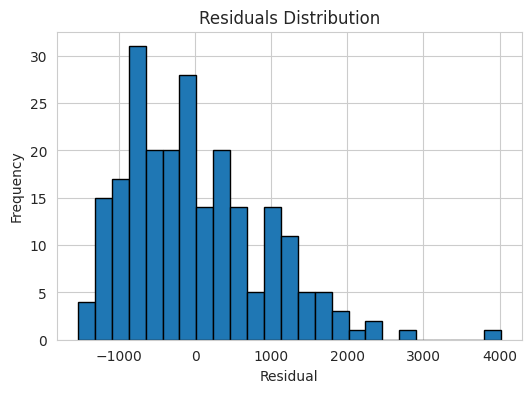

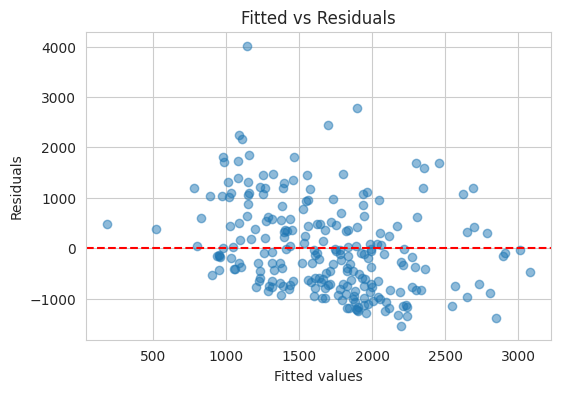

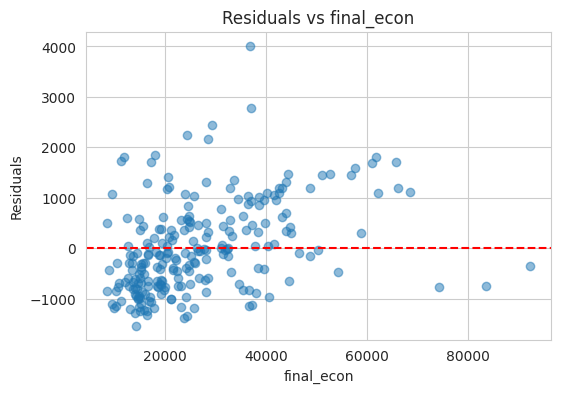

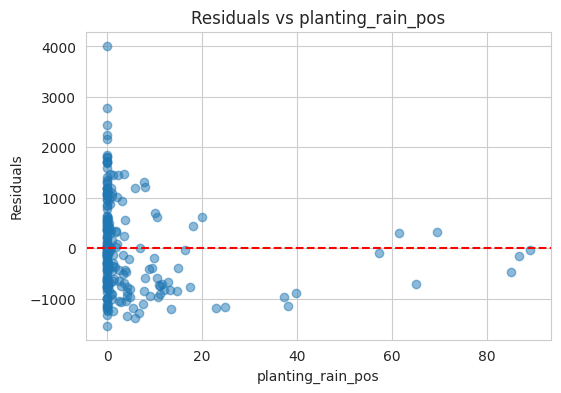

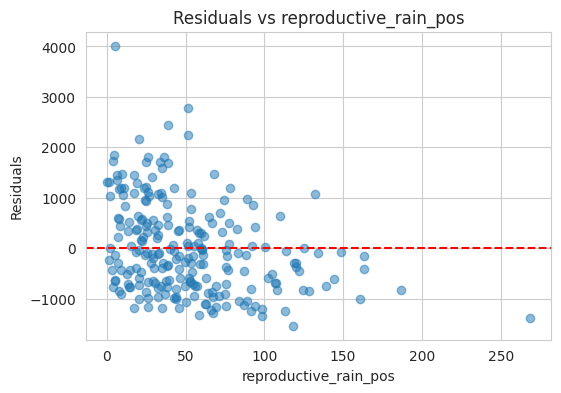

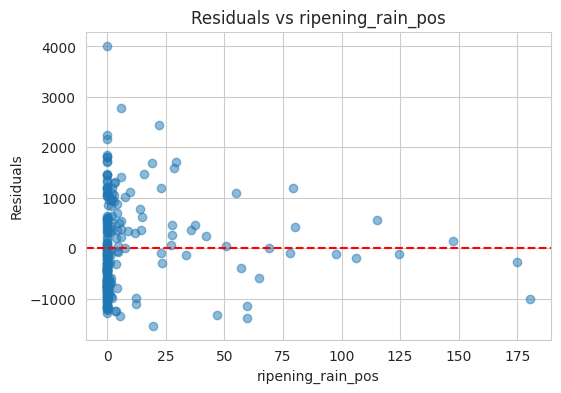

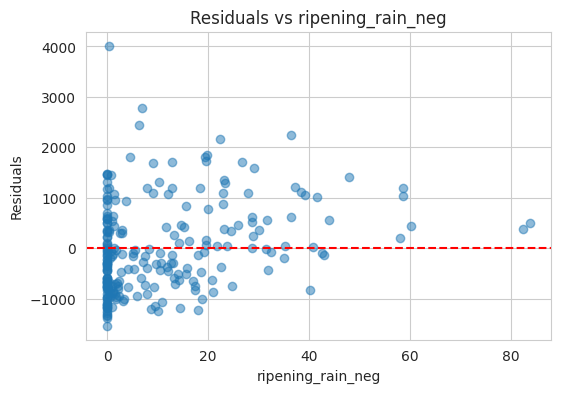

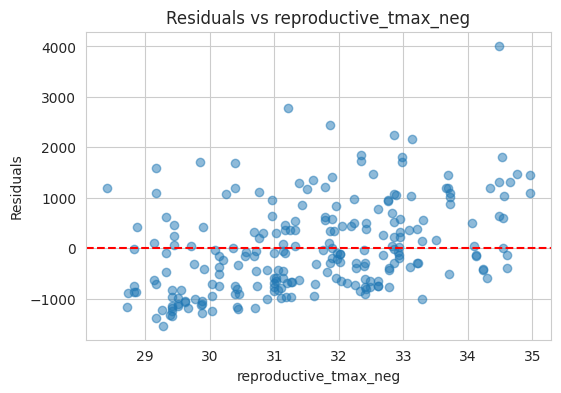

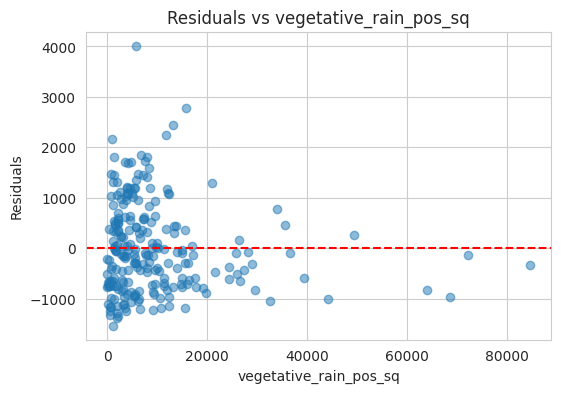


Shapiro-Wilk test: stat=0.9461, p=0.0000
Residuals deviate from normality

RMSE per district (sample period):
District 106: RMSE = 1013.654
District 11: RMSE = 721.875
District 118: RMSE = 1033.810
District 136: RMSE = 1252.175
District 147: RMSE = 994.014
District 150: RMSE = 664.543
District 158: RMSE = 798.551
District 159: RMSE = 1105.989
District 168: RMSE = 743.394
District 17: RMSE = 673.007
District 45: RMSE = 686.039
District 76: RMSE = 856.995
District 91: RMSE = 991.730

Overall RMSE (sample period, used rows): 903.077
Saved sample actual vs predicted to sample_actual_vs_predicted.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Step M: Regenerate features in val & forecast (auto) ===

=== Validation (2023) prediction ===


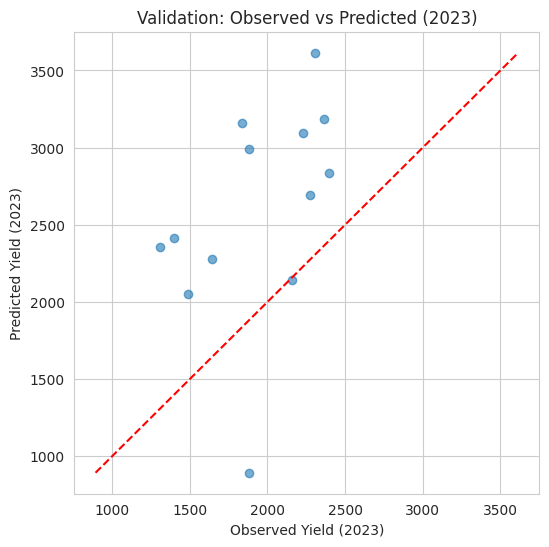

Validation RMSE (2023): 890.687
Saved validation file to validation_2023_actual_vs_predicted.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Forecast (2024-2025) prediction ===
                  yield_predicted
district_id year                 
106         2024      2807.254661
            2025      2274.193232
11          2024      2275.164248
            2025      1965.730202
118         2024      3063.669120
            2025      2559.558113
136         2024      2262.072625
            2025      2103.676847
147         2024      2483.197427
            2025      2171.904469
150         2024      2325.977014
            2025      2036.022365
158         2024      2197.943458
            2025      2065.018250
159         2024      1764.418557
            2025      1828.766565
168         2024      2212.940205
            2025      1897.162098
17          2024      2810.771582
            2025      2198.699705
45          2024      2237.535509
            2025      1945.088064
76          2024      2755.111580
            2025      2372.506775
91          2024      2803.256591
            2025      2349.278602
Saved f

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Pipeline finished. Final variables used: ['final_econ', 'planting_rain_pos', 'reproductive_rain_pos', 'ripening_rain_pos', 'ripening_rain_neg', 'reproductive_tmax_neg', 'vegetative_rain_pos_sq']
Feature map keys (sample): ['final_econ', 'planting_rain_pos', 'reproductive_rain_pos', 'ripening_rain_pos', 'ripening_rain_neg', 'reproductive_tmax_neg', 'vegetative_rain_pos_sq']


In [ ]:
# =================== FULL FEIS PIPELINE (robust, feature_map integrated) ===================
# NOTE: Run in a single Colab cell.

!pip install linearmodels --quiet

# ------------------- Imports -------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# ------------------- User Config -------------------
ZONE_CLUSTER = 7       # change as needed
P_SIGN = 0.10
VIF_THRESH = 10.0
TRAIN_YEARS = list(range(2005,2023))
VAL_YEAR = 2023
FORECAST_YEARS = [2024, 2025]

# ------------------- Upload Data -------------------
from google.colab import files
print("Upload your CSV file (must include yield_val).")
uploaded = files.upload()
fn = list(uploaded.keys())[0]
df = pd.read_csv(fn)

# ------------------- Standardize Columns -------------------
required_cols = ['district_id','year','zone_cluster','yield_val']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df = df[(df['year'] >= 2005) & (df['year'] <= 2025)].copy()
df['district_id'] = df['district_id'].astype(str)
df['year'] = df['year'].astype(int)
df['zone_cluster'] = df['zone_cluster'].astype(int)

# ------------------- Candidate variable groups (auto-detect) -------------------
econ_candidates_all = [f for f in df.columns if 'econ' in f.lower()]
irrigation_vars_all = [c for c in ['gw_reciprocal','reservoir_intensity','canal_intensity',
                                   'well_intensity','tank_intensity','oth_intensity'] if c in df.columns]
stress_vars_all = [c for c in ['heat_stress','drought'] if c in df.columns]
rain_weeks_all = [f'rf_week{i}' for i in range(20,43) if f'rf_week{i}' in df.columns]
tmax_weeks_all = [f'tmax_week{i}' for i in range(20,43) if f'tmax_week{i}' in df.columns]
tmin_weeks_all = [f'tmin_week{i}' for i in range(20,43) if f'tmin_week{i}' in df.columns]

all_candidates = list(set(econ_candidates_all + irrigation_vars_all +
                          stress_vars_all + rain_weeks_all +
                          tmax_weeks_all + tmin_weeks_all))

# ------------------- Impute Missing Values (within-district ffill/bfill then median) -------------------
if all_candidates:
    df[all_candidates] = df.groupby('district_id')[all_candidates].transform(lambda g: g.ffill().bfill())
    for col in all_candidates:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)

# Keep districts with at least 2 years
district_counts = df.groupby('district_id')['year'].nunique()
df = df[df['district_id'].isin(district_counts[district_counts >= 2].index)]

print("\nData prepared:", df.shape, "years", df['year'].min(), "to", df['year'].max())
print("Zone clusters available:", sorted(df['zone_cluster'].unique()))

# ------------------- Cluster Subset -------------------
cluster = df[df['zone_cluster'] == ZONE_CLUSTER].copy()
if cluster.empty:
    raise ValueError(f"No data for zone_cluster={ZONE_CLUSTER}")

train = cluster[cluster['year'].isin(TRAIN_YEARS)].copy()
val = cluster[cluster['year'] == VAL_YEAR].copy()
forecast_df = cluster[cluster['year'].isin(FORECAST_YEARS)].copy()

if train.empty:
    raise ValueError(f"No training data for zone_cluster={ZONE_CLUSTER}")

print(f"\nWorking on zone_cluster {ZONE_CLUSTER}: train={len(train)}, val={len(val)}, forecast={len(forecast_df)}")

# ------------------- Helper Functions -------------------
def feis_fit(y, X, data):
    """Panel FEIS fit (entity + time effects). X is list of column names in data."""
    try:
        panel = data.set_index(['district_id','year'])
        exog = sm.add_constant(panel[X], has_constant='add')
        mod = PanelOLS(panel[y], exog, entity_effects=True, time_effects=True)
        res = mod.fit(cov_type="robust")
        return res
    except Exception:
        return None

def safe_fit(formula, df):
    try:
        model = sm.OLS.from_formula(formula, df).fit()
        return model
    except Exception:
        return None

# ------------------- Structures to record feature_map & groups -------------------
feature_map = {}
rain_groups = {}
temp_groups = {}
irrig_pos_list, irrig_neg_list = [], []
interaction_kept = []
quad_kept = []

# ------------------- STEP A: Economic Variables -------------------
print("\n=== STEP A: Economic Variable Selection ===")
econ_candidates = econ_candidates_all.copy()
selected_econ = []

for var in econ_candidates:
    if var not in train.columns:
        continue
    res = feis_fit('yield_val', [var], train)
    if res is None:
        continue
    coef = res.params.get(var, np.nan)
    p = res.pvalues.get(var, np.nan)
    print(f" Econ {var}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN) and (coef > 0):
        if not selected_econ:
            selected_econ = [var]
            print(f" -> selected first econ {var}")
        else:
            avg_name = "econ_avg_temp"
            train[avg_name] = train[selected_econ + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', [avg_name], train)
            if res_avg:
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                coef_avg = res_avg.params.get(avg_name, np.nan)
                cur_avg = "econ_avg_current"
                train[cur_avg] = train[selected_econ].mean(axis=1)
                res_current = feis_fit('yield_val', [cur_avg], train)
                p_current = res_current.pvalues.get(cur_avg, np.nan) if res_current else np.nan
                train.drop(columns=[cur_avg], inplace=True, errors='ignore')
                print(f" Averaged {selected_econ + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, vs current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_econ.append(var)
                    print(f" -> kept {var} in econ group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

if selected_econ:
    train['final_econ'] = train[selected_econ].mean(axis=1)
    if not val.empty:
        val['final_econ'] = val[selected_econ].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['final_econ'] = forecast_df[selected_econ].mean(axis=1)
    base_features = ['final_econ']
    feature_map['final_econ'] = list(selected_econ)
else:
    base_features = []
print("Selected economic vars:", selected_econ)

# ------------------- STEP B: GW & Reservoir -------------------
print("\n=== STEP B: GW reciprocal & Reservoir ===")
gw_candidates = ['gw_reciprocal','reservoir_intensity']
for v in gw_candidates:
    if v in train.columns:
        features_to_test = base_features + [v]
        res = feis_fit('yield_val', features_to_test, train)
        if res is None:
            continue
        coef = res.params.get(v, np.nan)
        p = res.pvalues.get(v, np.nan)
        print(f" {v}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(v)
            feature_map[v] = ('raw', v)
            print(f" -> kept {v}")

print("Base features after Step B:", base_features)

# ------------------- STEP C: Rainfall Weekly -------------------
print("\n=== STEP C: Rainfall Weekly Selection ===")
stage_weeks = {
    'planting': list(range(20,29)),
    'vegetative': list(range(29,34)),
    'reproductive': list(range(34,39)),
    'ripening': list(range(39,43))
}

for stage, weeks in stage_weeks.items():
    weekly_cols = [f"rf_week{i}" for i in weeks if f"rf_week{i}" in train.columns]
    if not weekly_cols:
        print(f" No weekly rain cols for {stage}, skipping")
        continue

    print(f"\nTesting {stage} weekly cols: {weekly_cols}")
    pos_candidates, neg_candidates = [], []

    for col in weekly_cols:
        res = feis_fit('yield_val', base_features + [col], train)
        if res is None:
            continue
        coef = res.params.get(col, np.nan)
        p = res.pvalues.get(col, np.nan)
        print(f" {col}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            if coef > 0:
                pos_candidates.append(col)
                print(f"  -> {col} added to positive candidates")
            else:
                neg_candidates.append(col)
                print(f"  -> {col} added to negative candidates")

    # positive sequential averaging
    selected_pos = []
    for var in pos_candidates:
        if not selected_pos:
            selected_pos = [var]
            print(f" -> Selected first positive var for {stage}: {var}")
        else:
            avg_name = f'{stage}_pos_avg_temp'
            train[avg_name] = train[selected_pos + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_pos) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_pos[0]], train)
                    p_current = res_current.pvalues.get(selected_pos[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_pos_avg'
                    train[cur_avg_name] = train[selected_pos].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_pos.append(var)
                    print(f" -> kept {var} in positive group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # negative sequential averaging
    selected_neg = []
    for var in neg_candidates:
        if not selected_neg:
            selected_neg = [var]
            print(f" -> Selected first negative var for {stage}: {var}")
        else:
            avg_name = f'{stage}_neg_avg_temp'
            train[avg_name] = train[selected_neg + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_neg) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_neg[0]], train)
                    p_current = res_current.pvalues.get(selected_neg[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_neg_avg'
                    train[cur_avg_name] = train[selected_neg].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and (p_avg < p_current):
                    selected_neg.append(var)
                    print(f" -> kept {var} in negative group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # Create aggregated variables and record into feature_map
    rain_groups[stage] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

    if selected_pos:
        cname = f"{stage}_rain_pos"
        train[cname] = train[selected_pos].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_pos].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_pos)

    if selected_neg:
        cname = f"{stage}_rain_neg"
        train[cname] = train[selected_neg].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_neg].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_neg)

print("Base features after Step C:", base_features)

# ------------------- STEP D: Temperature Weekly -------------------
print("\n=== STEP D: Temperature Weekly ===")
for temp in ['tmax','tmin']:
    week_cols = [f"{temp}_week{i}" for i in range(20,43) if f"{temp}_week{i}" in train.columns]
    if not week_cols:
        print(f" No weekly {temp} data found, skipping {temp}")
        continue

    for stage, weeks in stage_weeks.items():
        cols = [f"{temp}_week{i}" for i in weeks if f"{temp}_week{i}" in train.columns]
        if not cols:
            continue

        print(f"\nTesting {temp} for stage {stage}: {cols}")
        pos_candidates, neg_candidates = [], []

        for col in cols:
            res = feis_fit('yield_val', base_features + [col], train)
            if res is None:
                continue
            coef = res.params.get(col, np.nan)
            p = res.pvalues.get(col, np.nan)
            print(f" {col}: coef={coef:.6f}, p={p:.4f}")
            if (not np.isnan(p)) and (p < P_SIGN):
                if coef > 0:
                    pos_candidates.append(col)
                    print(f"  -> {col} added to positive candidates")
                else:
                    neg_candidates.append(col)
                    print(f"  -> {col} added to negative candidates")

        # positive sequential averaging
        selected_pos = []
        for var in pos_candidates:
            if not selected_pos:
                selected_pos = [var]
                print(f" -> Selected first positive {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_pos_avg_temp'
                train[avg_name] = train[selected_pos + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_pos] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_pos:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and prev_ok:
                        selected_pos.append(var)
                        print(f" -> kept {var} in positive group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # negative sequential averaging
        selected_neg = []
        for var in neg_candidates:
            if not selected_neg:
                selected_neg = [var]
                print(f" -> Selected first negative {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_neg_avg_temp'
                train[avg_name] = train[selected_neg + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_neg] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_neg:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and prev_ok:
                        selected_neg.append(var)
                        print(f" -> kept {var} in negative group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # Aggregate and record
        key = (stage, temp)
        temp_groups[key] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

        if selected_pos:
            cname = f"{stage}_{temp}_pos"
            train[cname] = train[selected_pos].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_pos].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_pos)

        if selected_neg:
            cname = f"{stage}_{temp}_neg"
            train[cname] = train[selected_neg].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_neg].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_neg)

print("Base features after Step D (Temp):", base_features)

# ------------------- STEP E: Irrigation -------------------
print("\n=== STEP E: Irrigation ===")
irrig_pos_list, irrig_neg_list = [], []
irr_vars = [v for v in ['canal_intensity','well_intensity','tank_intensity','oth_intensity'] if v in train.columns]

for v in irr_vars:
    features_to_test = [f for f in base_features if f not in irrig_pos_list + irrig_neg_list] + [v]
    res = feis_fit('yield_val', features_to_test, train)
    if res is None:
        continue
    coef = res.params.get(v, np.nan)
    p = res.pvalues.get(v, np.nan)
    print(f" {v}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN):
        if coef > 0:
            irrig_pos_list.append(v)
            print(f" -> added to irrigation_pos: {v}")
        else:
            irrig_neg_list.append(v)
            print(f" -> added to irrigation_neg: {v}")

if irrig_pos_list:
    train['irrigation_pos'] = train[irrig_pos_list].mean(axis=1)
    if not val.empty:
        val['irrigation_pos'] = val[irrig_pos_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_pos'] = forecast_df[irrig_pos_list].mean(axis=1)
    base_features.append('irrigation_pos')
    feature_map['irrigation_pos'] = list(irrig_pos_list)

if irrig_neg_list:
    train['irrigation_neg'] = train[irrig_neg_list].mean(axis=1)
    if not val.empty:
        val['irrigation_neg'] = val[irrig_neg_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_neg'] = forecast_df[irrig_neg_list].mean(axis=1)
    base_features.append('irrigation_neg')
    feature_map['irrigation_neg'] = list(irrig_neg_list)

print("Irrigation pos:", irrig_pos_list, "neg:", irrig_neg_list)
print("Base features after irrigation:", base_features)

# ------------------- STEP F: Stress Variables -------------------
print("\n=== STEP F: Stress Variables ===")
for s in ['heat_stress','drought']:
    if s in train.columns:
        res = feis_fit('yield_val', base_features + [s], train)
        if res is None:
            continue
        coef = res.params.get(s, np.nan)
        p = res.pvalues.get(s, np.nan)
        print(f" {s}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(s)
            feature_map[s] = ('raw', s)
            print(f" -> kept {s}")

print("Base features after stress vars:", base_features)

# ------------------- STEP J: Interactions -------------------
print("\n=== STEP J: Interaction testing ===")
current_vars = base_features.copy()

rain_cols = [c for c in current_vars if '_rain_' in c]
irr_cols = [c for c in current_vars if c.startswith('irrigation_')]
reservoir_col = 'reservoir_intensity' if 'reservoir_intensity' in train.columns else None

interaction_candidates = []
for r in rain_cols:
    for i in irr_cols:
        interaction_candidates.append((r, i))
if reservoir_col:
    for r in rain_cols:
        interaction_candidates.append((r, reservoir_col))
    for i in irr_cols:
        interaction_candidates.append((i, reservoir_col))

for var1, var2 in interaction_candidates:
    # guard: both vars must exist in train (sometimes groups missing)
    if var1 not in train.columns or var2 not in train.columns:
        continue
    name = f"{var1}_x_{var2}"
    train[name] = train[var1] * train[var2]
    if not val.empty:
        val[name] = val[var1] * val[var2]
    if not forecast_df.empty:
        forecast_df[name] = forecast_df[var1] * forecast_df[var2]

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [name]), train)
    p_val = res.pvalues.get(name, np.nan) if res is not None else np.nan
    print(f" Interaction {name}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(name)
        interaction_kept.append(name)
        feature_map[name] = ('interaction', var1, var2)
        print(f" -> kept interaction {name}")
    else:
        train.drop(columns=[name], inplace=True, errors='ignore')
        val.drop(columns=[name], inplace=True, errors='ignore')
        forecast_df.drop(columns=[name], inplace=True, errors='ignore')

print("Interactions kept:", interaction_kept)

# ------------------- STEP K: Quadratic Rain -------------------
print("\n=== STEP K: Quadratic rain terms ===")
quad_kept = []
# use current_vars because interactions may have extended it
rain_cols = [c for c in current_vars if '_rain_' in c]
for rcol in rain_cols:
    if rcol not in train.columns:
        continue
    qname = f"{rcol}_sq"
    train[qname] = train[rcol] ** 2
    if not val.empty:
        val[qname] = val[rcol] ** 2
    if not forecast_df.empty:
        forecast_df[qname] = forecast_df[rcol] ** 2

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [qname]), train)
    p_val = res.pvalues.get(qname, np.nan) if res is not None else np.nan
    print(f" Quadratic {qname}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(qname)
        quad_kept.append(qname)
        feature_map[qname] = ('sq', rcol)
        print(f" -> kept quadratic {qname}")
    else:
        train.drop(columns=[qname], inplace=True, errors='ignore')
        val.drop(columns=[qname], inplace=True, errors='ignore')
        forecast_df.drop(columns=[qname], inplace=True, errors='ignore')

print("Quadratic kept:", quad_kept)

# ------------------- STEP L: VIF & p-value pruning -------------------
print("\n=== STEP L: VIF & p-value pruning ===")
final_vars = current_vars.copy()
train_panel = train.set_index(['district_id','year']).sort_index()

def calculate_vif(df, vars_list):
    try:
        X = sm.add_constant(df[vars_list], has_constant='add')
        vif_data = pd.DataFrame()
        vif_data['variable'] = vars_list
        vifs = []
        for i in range(len(vars_list)):
            try:
                vifs.append(variance_inflation_factor(X.values, i+1))
            except Exception:
                vifs.append(np.nan)
        vif_data['VIF'] = vifs
        return vif_data
    except Exception as e:
        return pd.DataFrame({'variable': vars_list, 'VIF': [np.nan]*len(vars_list)})

iteration = 0
while True:
    iteration += 1
    print(f"\nIteration {iteration}: computing VIF")
    vif_df = calculate_vif(train_panel, final_vars)
    print(vif_df)
    # handle all-NaN VIF_df
    if vif_df['VIF'].dropna().empty:
        print("VIFs not available / all NaN; stop VIF pruning.")
        break
    max_vif = vif_df['VIF'].max()
    if max_vif > VIF_THRESH:
        drop_var = vif_df.loc[vif_df['VIF'] == max_vif, 'variable'].values[0]
        print(f" -> dropping {drop_var} due to high VIF {max_vif:.2f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue

    # Fit PanelOLS and check p-values
    X_tmp = sm.add_constant(train_panel[final_vars], has_constant='add')
    y_tmp = train_panel['yield_val']
    try:
        model = PanelOLS(y_tmp, X_tmp, entity_effects=True, time_effects=True).fit(cov_type='robust')
    except Exception as e:
        print(" PanelOLS error during pruning:", e)
        break

    pvals = model.pvalues.drop('const', errors='ignore')
    if (pvals >= P_SIGN).any():
        drop_var = pvals.idxmax()
        print(f" -> dropping {drop_var} due to high p-value {pvals[drop_var]:.4f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue
    else:
        print("All VIFs and p-values OK")
        break

print("\nFinal selected variables (auto-detected):", final_vars)

# ------------------- Final FEIS Model -------------------
print("\n=== Fitting final FEIS model ===")
train_panel = train.set_index(['district_id','year']).sort_index()
# ensure final_vars exist in train_panel (if not, remove missing)
final_vars = [v for v in final_vars if v in train_panel.columns]
X_final = sm.add_constant(train_panel[final_vars], has_constant='add')
y_final = train_panel['yield_val']
res_final = PanelOLS(y_final, X_final, entity_effects=True, time_effects=True).fit(cov_type='robust')
print(res_final.summary)

# ------------------- SAFE Residual Diagnostics & RMSE -------------------
# Build X_full and y_full then determine used rows (no-NaN)
X_full = sm.add_constant(train_panel[final_vars], has_constant='add')
y_full = train_panel['yield_val']
used_mask = X_full.notnull().all(axis=1) & y_full.notnull()
used_index = X_full.index[used_mask]

if len(used_index) == 0:
    raise ValueError("No usable rows for diagnostics after filtering missing values.")

# Fitted using params (only for used_index)
fitted_used = pd.Series(X_full.loc[used_index].dot(res_final.params), index=used_index, name='fitted')

# Create fitted aligned to full train_panel index (NaNs where not available)
fitted = fitted_used.reindex(train_panel.index)

# Residuals (NaN where fitted missing)
residuals = y_full - fitted

print("\nResidual summary statistics (used rows only):")
print(residuals.dropna().describe())

# Plots (drop NaNs where appropriate)
plt.figure(figsize=(6,4))
plt.hist(residuals.dropna(), bins=25, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(fitted.dropna(), residuals.dropna(), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Fitted vs Residuals")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

for var in final_vars:
    if var in X_final.columns:
        plt.figure(figsize=(6,4))
        # align predictor to same index subset
        plt.scatter(X_final[var].loc[fitted.dropna().index], residuals.dropna(), alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f"Residuals vs {var}")
        plt.xlabel(var)
        plt.ylabel("Residuals")
        plt.show()

# Shapiro-Wilk
resid_nonan = residuals.dropna()
if len(resid_nonan) >= 3:
    stat, p_sw = shapiro(resid_nonan)
    print(f"\nShapiro-Wilk test: stat={stat:.4f}, p={p_sw:.4f}")
    print("Residuals roughly normal" if p_sw > 0.05 else "Residuals deviate from normality")
else:
    print("\nNot enough residuals for Shapiro-Wilk test (need >=3).")

# RMSE per district (safe drop NaNs)
rmse_dict = {}
for d in train_panel.index.get_level_values('district_id').unique():
    y_true = y_full.xs(d, level='district_id')
    y_pred = fitted.xs(d, level='district_id')
    df_tmp = pd.concat([y_true, y_pred], axis=1, keys=['y_true','y_pred']).dropna()
    if not df_tmp.empty:
        rmse_dict[d] = np.sqrt(mean_squared_error(df_tmp['y_true'], df_tmp['y_pred']))

print("\nRMSE per district (sample period):")
for d, r in rmse_dict.items():
    print(f"District {d}: RMSE = {r:.3f}")

# Overall RMSE (drop NaNs)
df_all = pd.concat([y_full, fitted], axis=1, keys=['y_true', 'y_pred']).dropna()
overall_rmse = np.sqrt(mean_squared_error(df_all['y_true'], df_all['y_pred']))
print(f"\nOverall RMSE (sample period, used rows): {overall_rmse:.3f}")

# ------------------- Save sample actual vs predicted CSV -------------------
df_sample = df_all.reset_index()[['district_id','year','y_true','y_pred']].rename(columns={'y_true':'yield_actual','y_pred':'yield_predicted'})
out_sample = "sample_actual_vs_predicted.csv"
df_sample.to_csv(out_sample, index=False)
print(f"Saved sample actual vs predicted to {out_sample}")
try:
    files.download(out_sample)
except Exception:
    pass

# ------------------- Feature Regeneration Utility -------------------
def regenerate_features(df_in, feature_map, fill_value=0.0, max_iters=20):
    """Rebuild derived features for df_in using the feature_map.
       Safe: missing raw columns are filled with fill_value (scalar)."""
    df = df_in.copy()
    # prefill missing raw columns referenced in feature_map with fill_value
    for rule in feature_map.values():
        if isinstance(rule, list):
            for c in rule:
                if c not in df.columns:
                    df[c] = fill_value
        elif isinstance(rule, tuple) and rule[0] == 'raw':
            col = rule[1]
            if col not in df.columns:
                df[col] = fill_value

    it = 0
    while it < max_iters:
        it += 1
        changed = False
        for feat, rule in feature_map.items():
            if feat in df.columns:
                continue
            try:
                if isinstance(rule, list):
                    if all([c in df.columns for c in rule]):
                        df[feat] = df[rule].mean(axis=1)
                        changed = True
                elif isinstance(rule, tuple):
                    if rule[0] == 'sq' and rule[1] in df.columns:
                        df[feat] = df[rule[1]] ** 2
                        changed = True
                    elif rule[0] == 'interaction':
                        v1, v2 = rule[1], rule[2]
                        if v1 in df.columns and v2 in df.columns:
                            df[feat] = df[v1] * df[v2]
                            changed = True
                    elif rule[0] == 'raw' and rule[1] in df.columns:
                        df[feat] = df[rule[1]]
                        changed = True
                else:
                    # if rule is string (alias)
                    if isinstance(rule, str) and rule in df.columns:
                        df[feat] = df[rule]
                        changed = True
            except Exception:
                pass
        if not changed:
            break
    return df

# -------------------- Step M: Regenerate features in val & forecast --------------------
print("\n=== Step M: Regenerate features in val & forecast (auto) ===")
if not val.empty:
    val = regenerate_features(val, feature_map)
if not forecast_df.empty:
    forecast_df = regenerate_features(forecast_df, feature_map)

# Ensure all final_vars present in val & forecast (fill with median from train or 0)
for col in final_vars:
    if not val.empty and col not in val.columns:
        val[col] = train[col].median() if col in train.columns else 0.0
    if not forecast_df.empty and col not in forecast_df.columns:
        forecast_df[col] = train[col].median() if col in train.columns else 0.0

# ------------------- Validation (2023) prediction -------------------
print("\n=== Validation (2023) prediction ===")
if not val.empty and VAL_YEAR in val['year'].unique():
    val_panel = val.set_index(['district_id','year']).sort_index()
    X_val = sm.add_constant(val_panel[final_vars], has_constant='add')
    # ensure all params columns exist in X_val
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_val.columns:
            X_val[col] = 0.0
    X_val = X_val[res_final.params.index]  # reorder to match params
    y_val = val_panel['yield_val']
    y_pred_val = pd.Series(X_val.dot(res_final.params), index=X_val.index, name='yield_predicted')

    # align and drop NaNs for RMSE & plotting
    df_val_check = pd.concat([y_val, y_pred_val], axis=1).dropna()
    if df_val_check.empty:
        print("No valid validation rows after alignment (all NaN).")
    else:
        plt.figure(figsize=(6,6))
        plt.scatter(df_val_check.iloc[:,0], df_val_check.iloc[:,1], alpha=0.6)
        mn = min(df_val_check.iloc[:,0].min(), df_val_check.iloc[:,1].min())
        mx = max(df_val_check.iloc[:,0].max(), df_val_check.iloc[:,1].max())
        plt.plot([mn,mx],[mn,mx],'r--')
        plt.xlabel("Observed Yield (2023)")
        plt.ylabel("Predicted Yield (2023)")
        plt.title(f"Validation: Observed vs Predicted ({VAL_YEAR})")
        plt.show()

        val_rmse = np.sqrt(mean_squared_error(df_val_check.iloc[:,0], df_val_check.iloc[:,1]))
        print(f"Validation RMSE (2023): {val_rmse:.3f}")

    # Save validation CSV (actual + predicted)
    df_val_out = df_val_check.reset_index().rename(columns={df_val_check.columns[0]:'yield_actual', df_val_check.columns[1]:'yield_predicted'})
    out_val = "validation_2023_actual_vs_predicted.csv"
    df_val_out.to_csv(out_val, index=False)
    print(f"Saved validation file to {out_val}")
    try:
        files.download(out_val)
    except Exception:
        pass

# ------------------- Forecast (2024-2025) prediction -------------------
print("\n=== Forecast (2024-2025) prediction ===")
if not forecast_df.empty:
    forecast_panel = forecast_df.set_index(['district_id','year']).sort_index()
    X_fore = sm.add_constant(forecast_panel[final_vars], has_constant='add')
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_fore.columns:
            X_fore[col] = 0.0
    X_fore = X_fore[res_final.params.index]
    y_fore_pred = pd.Series(X_fore.dot(res_final.params), index=X_fore.index, name='yield_predicted')

    # attach forecast predictions back to panel
    forecast_out = forecast_panel.copy()
    forecast_out['yield_predicted'] = np.nan
    forecast_out.loc[y_fore_pred.index, 'yield_predicted'] = y_fore_pred.values

    print(forecast_out[['yield_predicted']].dropna().head(40))

    # Save forecast CSV
    df_fore_out = forecast_out.reset_index()[['district_id','year','yield_predicted']]
    out_fore = "forecast_2024_2025_predicted.csv"
    df_fore_out.to_csv(out_fore, index=False)
    print(f"Saved forecast file to {out_fore}")
    try:
        files.download(out_fore)
    except Exception:
        pass

# ------------------- Done -------------------
print("\nPipeline finished. Final variables used:", final_vars)
print("Feature map keys (sample):", list(feature_map.keys())[:40])


<font color ='blue'> <font size ='5'> **Zone_cluster =8**

Upload your CSV file (must include yield_val).


Saving data1.csv to data1 (8).csv

Data prepared: (3612, 209) years 2005 to 2025
Zone clusters available: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Working on zone_cluster 8: train=864, val=48, forecast=96

=== STEP A: Economic Variable Selection ===
 Econ econ_inc_rev1: coef=0.015691, p=0.0000
 -> selected first econ econ_inc_rev1
 Econ econ_inc_rev2: coef=0.013585, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev2'] -> coef=0.014671, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev3: coef=0.015601, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev3'] -> coef=0.015965, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev4: coef=0.015014, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev4'] -> coef=0.015633, p=0.0000, vs current p=0.0000
 -> kept econ_inc_rev4 in econ group
 Econ econ_inc_rev5: coef=0.015681, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev4', 'econ_inc_rev5'] -> coef=0.015701, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev6: c

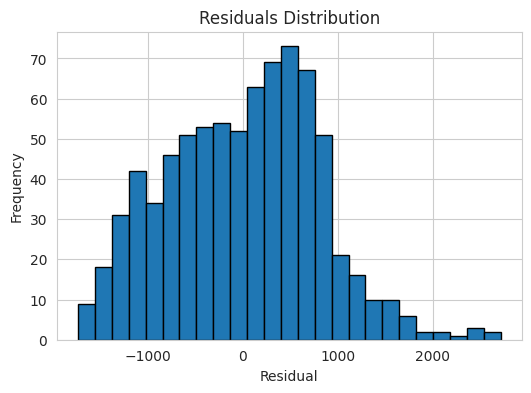

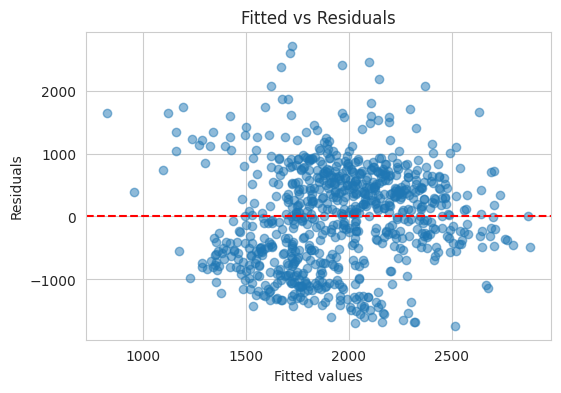

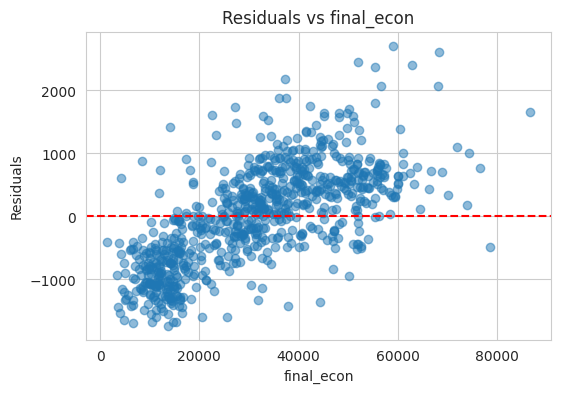

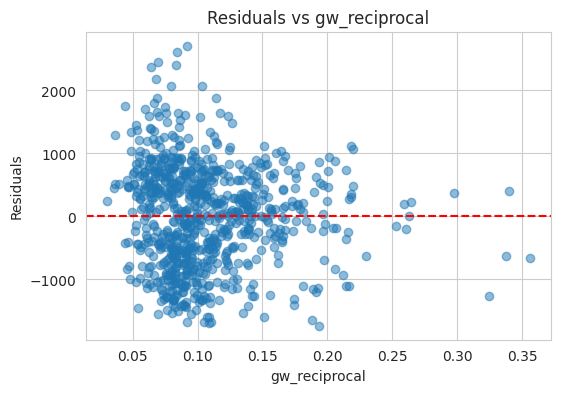

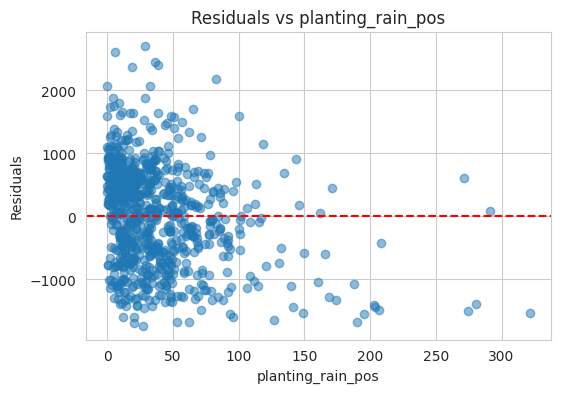

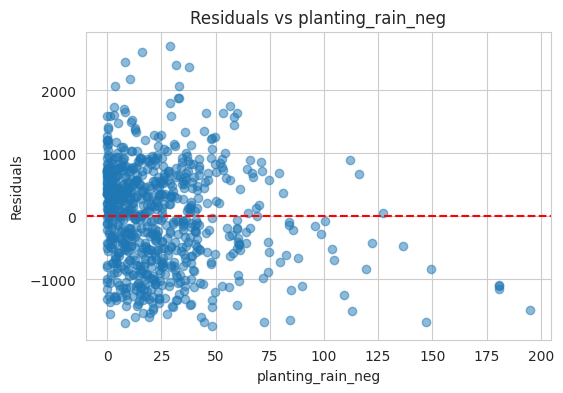

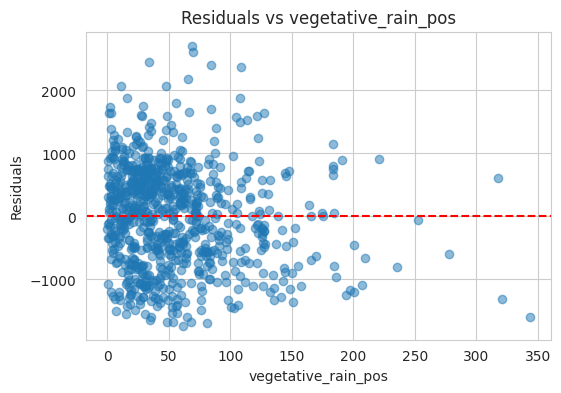

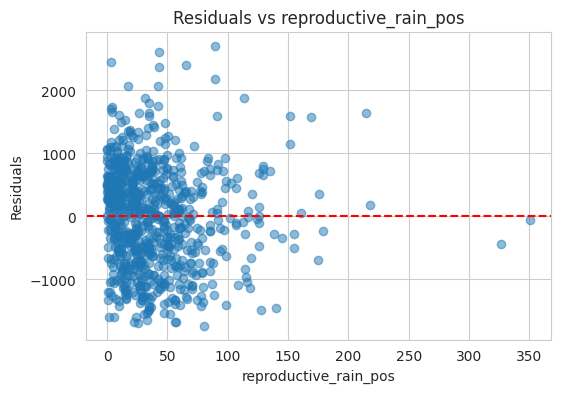

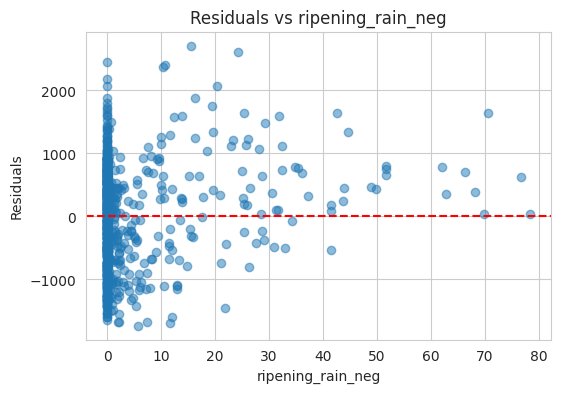

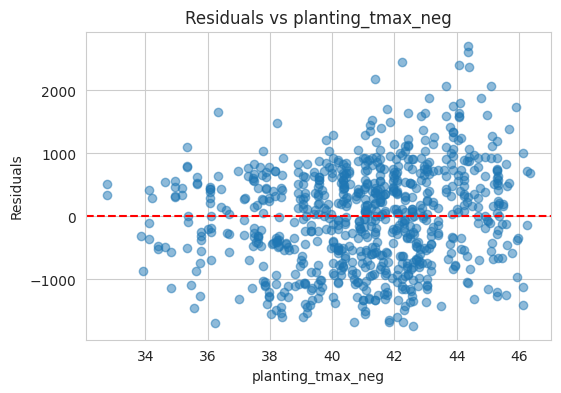

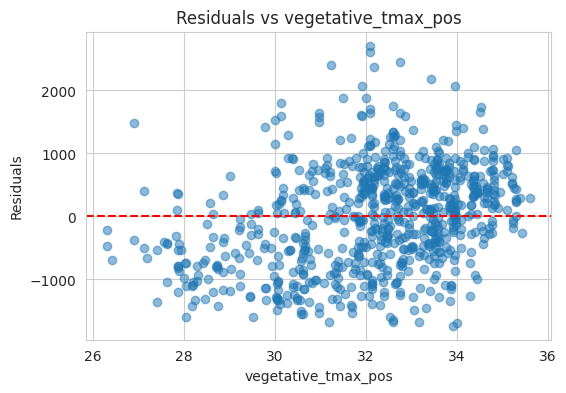

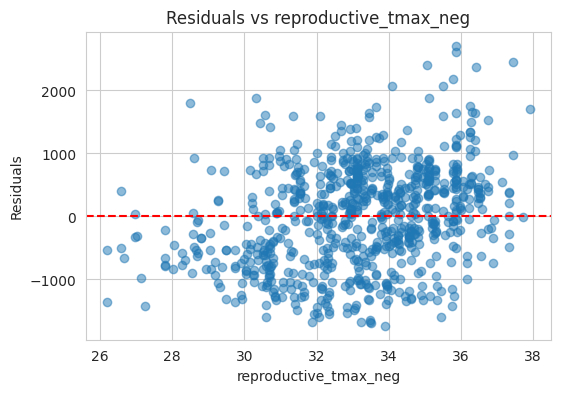

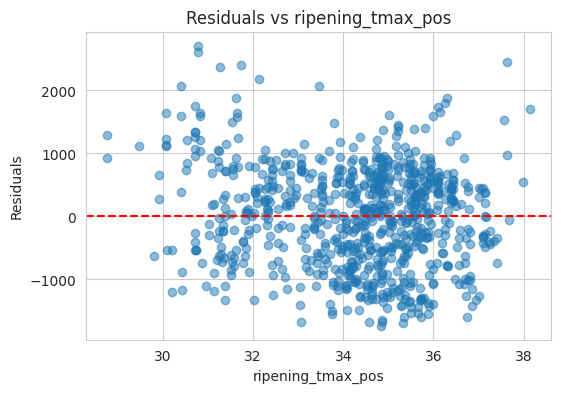

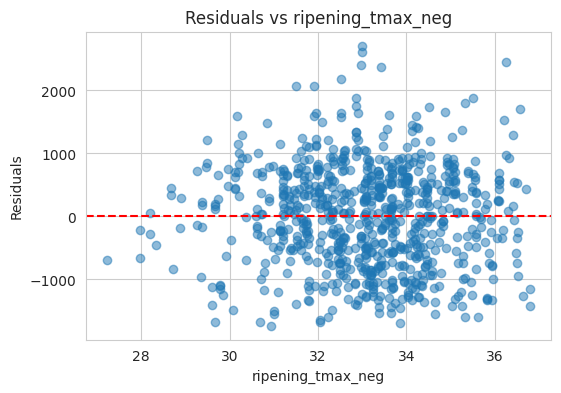

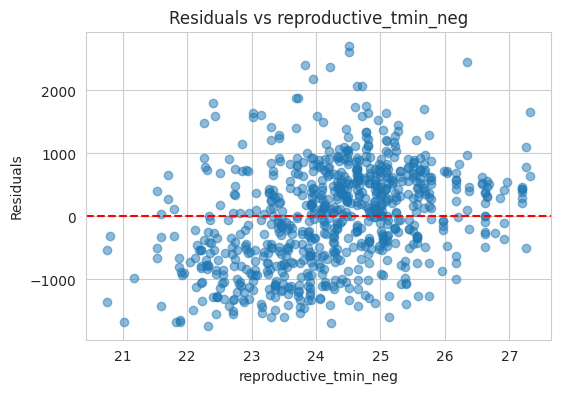

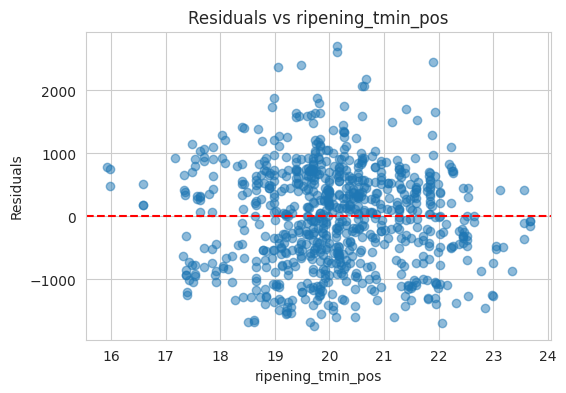

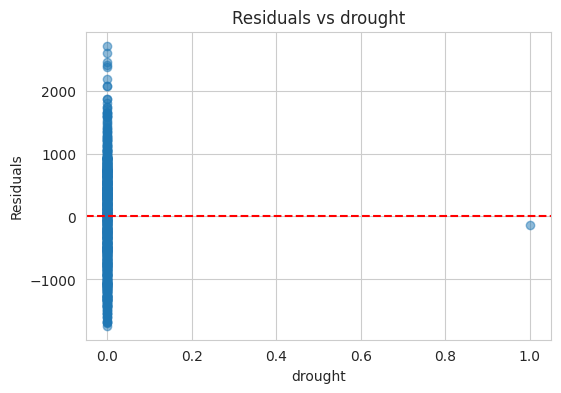


Shapiro-Wilk test: stat=0.9882, p=0.0000
Residuals deviate from normality

RMSE per district (sample period):
District 10: RMSE = 483.465
District 103: RMSE = 687.447
District 104: RMSE = 502.256
District 109: RMSE = 383.356
District 111: RMSE = 747.690
District 115: RMSE = 1018.326
District 12: RMSE = 835.157
District 120: RMSE = 1214.166
District 126: RMSE = 865.103
District 13: RMSE = 940.457
District 132: RMSE = 704.266
District 133: RMSE = 945.018
District 135: RMSE = 965.542
District 140: RMSE = 873.720
District 143: RMSE = 674.653
District 15: RMSE = 686.773
District 153: RMSE = 683.800
District 154: RMSE = 1159.793
District 155: RMSE = 802.918
District 166: RMSE = 1125.636
District 171: RMSE = 806.517
District 2: RMSE = 595.762
District 20: RMSE = 516.242
District 28: RMSE = 1401.568
District 3: RMSE = 466.972
District 30: RMSE = 875.437
District 33: RMSE = 524.860
District 37: RMSE = 999.588
District 39: RMSE = 703.540
District 40: RMSE = 880.276
District 41: RMSE = 635.028
D

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Step M: Regenerate features in val & forecast (auto) ===

=== Validation (2023) prediction ===


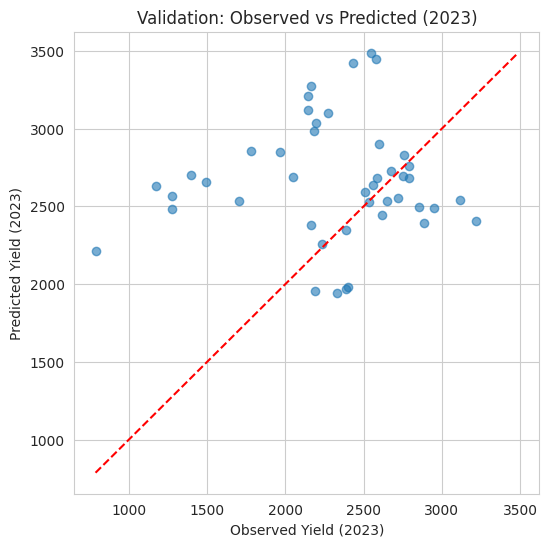

Validation RMSE (2023): 734.216
Saved validation file to validation_2023_actual_vs_predicted.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Forecast (2024-2025) prediction ===
                  yield_predicted
district_id year                 
10          2024      2212.542549
            2025      2628.256474
103         2024      2258.268094
            2025      2657.684555
104         2024      2507.369468
            2025      2930.045256
107         2024      2044.157149
            2025      2648.744264
109         2024      2030.570846
            2025      2710.093188
111         2024      2170.909000
            2025      2651.580209
115         2024      2661.528716
            2025      3139.617638
12          2024      2698.304402
            2025      3123.837174
120         2024      1732.632554
            2025      2477.093858
121         2024      2211.563241
            2025      2657.334620
126         2024      2426.754957
            2025      3071.619993
13          2024      2509.467276
            2025      2812.828784
132         2024      2933.672704
            2025      3161.873635
133    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Pipeline finished. Final variables used: ['final_econ', 'gw_reciprocal', 'planting_rain_pos', 'planting_rain_neg', 'vegetative_rain_pos', 'reproductive_rain_pos', 'ripening_rain_neg', 'planting_tmax_neg', 'vegetative_tmax_pos', 'reproductive_tmax_neg', 'ripening_tmax_pos', 'ripening_tmax_neg', 'reproductive_tmin_neg', 'ripening_tmin_pos', 'drought']
Feature map keys (sample): ['final_econ', 'gw_reciprocal', 'planting_rain_pos', 'planting_rain_neg', 'vegetative_rain_pos', 'reproductive_rain_pos', 'ripening_rain_neg', 'planting_tmax_neg', 'vegetative_tmax_pos', 'reproductive_tmax_neg', 'ripening_tmax_pos', 'ripening_tmax_neg', 'reproductive_tmin_neg', 'ripening_tmin_pos', 'drought']


In [ ]:
# =================== FULL FEIS PIPELINE (robust, feature_map integrated) ===================
# NOTE: Run in a single Colab cell.

!pip install linearmodels --quiet

# ------------------- Imports -------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# ------------------- User Config -------------------
ZONE_CLUSTER = 8       # change as needed
P_SIGN = 0.10
VIF_THRESH = 10.0
TRAIN_YEARS = list(range(2005,2023))
VAL_YEAR = 2023
FORECAST_YEARS = [2024, 2025]

# ------------------- Upload Data -------------------
from google.colab import files
print("Upload your CSV file (must include yield_val).")
uploaded = files.upload()
fn = list(uploaded.keys())[0]
df = pd.read_csv(fn)

# ------------------- Standardize Columns -------------------
required_cols = ['district_id','year','zone_cluster','yield_val']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df = df[(df['year'] >= 2005) & (df['year'] <= 2025)].copy()
df['district_id'] = df['district_id'].astype(str)
df['year'] = df['year'].astype(int)
df['zone_cluster'] = df['zone_cluster'].astype(int)

# ------------------- Candidate variable groups (auto-detect) -------------------
econ_candidates_all = [f for f in df.columns if 'econ' in f.lower()]
irrigation_vars_all = [c for c in ['gw_reciprocal','reservoir_intensity','canal_intensity',
                                   'well_intensity','tank_intensity','oth_intensity'] if c in df.columns]
stress_vars_all = [c for c in ['heat_stress','drought'] if c in df.columns]
rain_weeks_all = [f'rf_week{i}' for i in range(20,43) if f'rf_week{i}' in df.columns]
tmax_weeks_all = [f'tmax_week{i}' for i in range(20,43) if f'tmax_week{i}' in df.columns]
tmin_weeks_all = [f'tmin_week{i}' for i in range(20,43) if f'tmin_week{i}' in df.columns]

all_candidates = list(set(econ_candidates_all + irrigation_vars_all +
                          stress_vars_all + rain_weeks_all +
                          tmax_weeks_all + tmin_weeks_all))

# ------------------- Impute Missing Values (within-district ffill/bfill then median) -------------------
if all_candidates:
    df[all_candidates] = df.groupby('district_id')[all_candidates].transform(lambda g: g.ffill().bfill())
    for col in all_candidates:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)

# Keep districts with at least 2 years
district_counts = df.groupby('district_id')['year'].nunique()
df = df[df['district_id'].isin(district_counts[district_counts >= 2].index)]

print("\nData prepared:", df.shape, "years", df['year'].min(), "to", df['year'].max())
print("Zone clusters available:", sorted(df['zone_cluster'].unique()))

# ------------------- Cluster Subset -------------------
cluster = df[df['zone_cluster'] == ZONE_CLUSTER].copy()
if cluster.empty:
    raise ValueError(f"No data for zone_cluster={ZONE_CLUSTER}")

train = cluster[cluster['year'].isin(TRAIN_YEARS)].copy()
val = cluster[cluster['year'] == VAL_YEAR].copy()
forecast_df = cluster[cluster['year'].isin(FORECAST_YEARS)].copy()

if train.empty:
    raise ValueError(f"No training data for zone_cluster={ZONE_CLUSTER}")

print(f"\nWorking on zone_cluster {ZONE_CLUSTER}: train={len(train)}, val={len(val)}, forecast={len(forecast_df)}")

# ------------------- Helper Functions -------------------
def feis_fit(y, X, data):
    """Panel FEIS fit (entity + time effects). X is list of column names in data."""
    try:
        panel = data.set_index(['district_id','year'])
        exog = sm.add_constant(panel[X], has_constant='add')
        mod = PanelOLS(panel[y], exog, entity_effects=True, time_effects=True)
        res = mod.fit(cov_type="robust")
        return res
    except Exception:
        return None

def safe_fit(formula, df):
    try:
        model = sm.OLS.from_formula(formula, df).fit()
        return model
    except Exception:
        return None

# ------------------- Structures to record feature_map & groups -------------------
feature_map = {}
rain_groups = {}
temp_groups = {}
irrig_pos_list, irrig_neg_list = [], []
interaction_kept = []
quad_kept = []

# ------------------- STEP A: Economic Variables -------------------
print("\n=== STEP A: Economic Variable Selection ===")
econ_candidates = econ_candidates_all.copy()
selected_econ = []

for var in econ_candidates:
    if var not in train.columns:
        continue
    res = feis_fit('yield_val', [var], train)
    if res is None:
        continue
    coef = res.params.get(var, np.nan)
    p = res.pvalues.get(var, np.nan)
    print(f" Econ {var}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN) and (coef > 0):
        if not selected_econ:
            selected_econ = [var]
            print(f" -> selected first econ {var}")
        else:
            avg_name = "econ_avg_temp"
            train[avg_name] = train[selected_econ + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', [avg_name], train)
            if res_avg:
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                coef_avg = res_avg.params.get(avg_name, np.nan)
                cur_avg = "econ_avg_current"
                train[cur_avg] = train[selected_econ].mean(axis=1)
                res_current = feis_fit('yield_val', [cur_avg], train)
                p_current = res_current.pvalues.get(cur_avg, np.nan) if res_current else np.nan
                train.drop(columns=[cur_avg], inplace=True, errors='ignore')
                print(f" Averaged {selected_econ + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, vs current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_econ.append(var)
                    print(f" -> kept {var} in econ group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

if selected_econ:
    train['final_econ'] = train[selected_econ].mean(axis=1)
    if not val.empty:
        val['final_econ'] = val[selected_econ].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['final_econ'] = forecast_df[selected_econ].mean(axis=1)
    base_features = ['final_econ']
    feature_map['final_econ'] = list(selected_econ)
else:
    base_features = []
print("Selected economic vars:", selected_econ)

# ------------------- STEP B: GW & Reservoir -------------------
print("\n=== STEP B: GW reciprocal & Reservoir ===")
gw_candidates = ['gw_reciprocal','reservoir_intensity']
for v in gw_candidates:
    if v in train.columns:
        features_to_test = base_features + [v]
        res = feis_fit('yield_val', features_to_test, train)
        if res is None:
            continue
        coef = res.params.get(v, np.nan)
        p = res.pvalues.get(v, np.nan)
        print(f" {v}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(v)
            feature_map[v] = ('raw', v)
            print(f" -> kept {v}")

print("Base features after Step B:", base_features)

# ------------------- STEP C: Rainfall Weekly -------------------
print("\n=== STEP C: Rainfall Weekly Selection ===")
stage_weeks = {
    'planting': list(range(20,29)),
    'vegetative': list(range(29,34)),
    'reproductive': list(range(34,39)),
    'ripening': list(range(39,43))
}

for stage, weeks in stage_weeks.items():
    weekly_cols = [f"rf_week{i}" for i in weeks if f"rf_week{i}" in train.columns]
    if not weekly_cols:
        print(f" No weekly rain cols for {stage}, skipping")
        continue

    print(f"\nTesting {stage} weekly cols: {weekly_cols}")
    pos_candidates, neg_candidates = [], []

    for col in weekly_cols:
        res = feis_fit('yield_val', base_features + [col], train)
        if res is None:
            continue
        coef = res.params.get(col, np.nan)
        p = res.pvalues.get(col, np.nan)
        print(f" {col}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            if coef > 0:
                pos_candidates.append(col)
                print(f"  -> {col} added to positive candidates")
            else:
                neg_candidates.append(col)
                print(f"  -> {col} added to negative candidates")

    # positive sequential averaging
    selected_pos = []
    for var in pos_candidates:
        if not selected_pos:
            selected_pos = [var]
            print(f" -> Selected first positive var for {stage}: {var}")
        else:
            avg_name = f'{stage}_pos_avg_temp'
            train[avg_name] = train[selected_pos + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_pos) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_pos[0]], train)
                    p_current = res_current.pvalues.get(selected_pos[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_pos_avg'
                    train[cur_avg_name] = train[selected_pos].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_pos.append(var)
                    print(f" -> kept {var} in positive group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # negative sequential averaging
    selected_neg = []
    for var in neg_candidates:
        if not selected_neg:
            selected_neg = [var]
            print(f" -> Selected first negative var for {stage}: {var}")
        else:
            avg_name = f'{stage}_neg_avg_temp'
            train[avg_name] = train[selected_neg + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_neg) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_neg[0]], train)
                    p_current = res_current.pvalues.get(selected_neg[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_neg_avg'
                    train[cur_avg_name] = train[selected_neg].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and (p_avg < p_current):
                    selected_neg.append(var)
                    print(f" -> kept {var} in negative group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # Create aggregated variables and record into feature_map
    rain_groups[stage] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

    if selected_pos:
        cname = f"{stage}_rain_pos"
        train[cname] = train[selected_pos].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_pos].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_pos)

    if selected_neg:
        cname = f"{stage}_rain_neg"
        train[cname] = train[selected_neg].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_neg].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_neg)

print("Base features after Step C:", base_features)

# ------------------- STEP D: Temperature Weekly -------------------
print("\n=== STEP D: Temperature Weekly ===")
for temp in ['tmax','tmin']:
    week_cols = [f"{temp}_week{i}" for i in range(20,43) if f"{temp}_week{i}" in train.columns]
    if not week_cols:
        print(f" No weekly {temp} data found, skipping {temp}")
        continue

    for stage, weeks in stage_weeks.items():
        cols = [f"{temp}_week{i}" for i in weeks if f"{temp}_week{i}" in train.columns]
        if not cols:
            continue

        print(f"\nTesting {temp} for stage {stage}: {cols}")
        pos_candidates, neg_candidates = [], []

        for col in cols:
            res = feis_fit('yield_val', base_features + [col], train)
            if res is None:
                continue
            coef = res.params.get(col, np.nan)
            p = res.pvalues.get(col, np.nan)
            print(f" {col}: coef={coef:.6f}, p={p:.4f}")
            if (not np.isnan(p)) and (p < P_SIGN):
                if coef > 0:
                    pos_candidates.append(col)
                    print(f"  -> {col} added to positive candidates")
                else:
                    neg_candidates.append(col)
                    print(f"  -> {col} added to negative candidates")

        # positive sequential averaging
        selected_pos = []
        for var in pos_candidates:
            if not selected_pos:
                selected_pos = [var]
                print(f" -> Selected first positive {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_pos_avg_temp'
                train[avg_name] = train[selected_pos + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_pos] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_pos:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and prev_ok:
                        selected_pos.append(var)
                        print(f" -> kept {var} in positive group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # negative sequential averaging
        selected_neg = []
        for var in neg_candidates:
            if not selected_neg:
                selected_neg = [var]
                print(f" -> Selected first negative {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_neg_avg_temp'
                train[avg_name] = train[selected_neg + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_neg] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_neg:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and prev_ok:
                        selected_neg.append(var)
                        print(f" -> kept {var} in negative group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # Aggregate and record
        key = (stage, temp)
        temp_groups[key] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

        if selected_pos:
            cname = f"{stage}_{temp}_pos"
            train[cname] = train[selected_pos].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_pos].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_pos)

        if selected_neg:
            cname = f"{stage}_{temp}_neg"
            train[cname] = train[selected_neg].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_neg].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_neg)

print("Base features after Step D (Temp):", base_features)

# ------------------- STEP E: Irrigation -------------------
print("\n=== STEP E: Irrigation ===")
irrig_pos_list, irrig_neg_list = [], []
irr_vars = [v for v in ['canal_intensity','well_intensity','tank_intensity','oth_intensity'] if v in train.columns]

for v in irr_vars:
    features_to_test = [f for f in base_features if f not in irrig_pos_list + irrig_neg_list] + [v]
    res = feis_fit('yield_val', features_to_test, train)
    if res is None:
        continue
    coef = res.params.get(v, np.nan)
    p = res.pvalues.get(v, np.nan)
    print(f" {v}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN):
        if coef > 0:
            irrig_pos_list.append(v)
            print(f" -> added to irrigation_pos: {v}")
        else:
            irrig_neg_list.append(v)
            print(f" -> added to irrigation_neg: {v}")

if irrig_pos_list:
    train['irrigation_pos'] = train[irrig_pos_list].mean(axis=1)
    if not val.empty:
        val['irrigation_pos'] = val[irrig_pos_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_pos'] = forecast_df[irrig_pos_list].mean(axis=1)
    base_features.append('irrigation_pos')
    feature_map['irrigation_pos'] = list(irrig_pos_list)

if irrig_neg_list:
    train['irrigation_neg'] = train[irrig_neg_list].mean(axis=1)
    if not val.empty:
        val['irrigation_neg'] = val[irrig_neg_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_neg'] = forecast_df[irrig_neg_list].mean(axis=1)
    base_features.append('irrigation_neg')
    feature_map['irrigation_neg'] = list(irrig_neg_list)

print("Irrigation pos:", irrig_pos_list, "neg:", irrig_neg_list)
print("Base features after irrigation:", base_features)

# ------------------- STEP F: Stress Variables -------------------
print("\n=== STEP F: Stress Variables ===")
for s in ['heat_stress','drought']:
    if s in train.columns:
        res = feis_fit('yield_val', base_features + [s], train)
        if res is None:
            continue
        coef = res.params.get(s, np.nan)
        p = res.pvalues.get(s, np.nan)
        print(f" {s}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(s)
            feature_map[s] = ('raw', s)
            print(f" -> kept {s}")

print("Base features after stress vars:", base_features)

# ------------------- STEP J: Interactions -------------------
print("\n=== STEP J: Interaction testing ===")
current_vars = base_features.copy()

rain_cols = [c for c in current_vars if '_rain_' in c]
irr_cols = [c for c in current_vars if c.startswith('irrigation_')]
reservoir_col = 'reservoir_intensity' if 'reservoir_intensity' in train.columns else None

interaction_candidates = []
for r in rain_cols:
    for i in irr_cols:
        interaction_candidates.append((r, i))
if reservoir_col:
    for r in rain_cols:
        interaction_candidates.append((r, reservoir_col))
    for i in irr_cols:
        interaction_candidates.append((i, reservoir_col))

for var1, var2 in interaction_candidates:
    # guard: both vars must exist in train (sometimes groups missing)
    if var1 not in train.columns or var2 not in train.columns:
        continue
    name = f"{var1}_x_{var2}"
    train[name] = train[var1] * train[var2]
    if not val.empty:
        val[name] = val[var1] * val[var2]
    if not forecast_df.empty:
        forecast_df[name] = forecast_df[var1] * forecast_df[var2]

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [name]), train)
    p_val = res.pvalues.get(name, np.nan) if res is not None else np.nan
    print(f" Interaction {name}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(name)
        interaction_kept.append(name)
        feature_map[name] = ('interaction', var1, var2)
        print(f" -> kept interaction {name}")
    else:
        train.drop(columns=[name], inplace=True, errors='ignore')
        val.drop(columns=[name], inplace=True, errors='ignore')
        forecast_df.drop(columns=[name], inplace=True, errors='ignore')

print("Interactions kept:", interaction_kept)

# ------------------- STEP K: Quadratic Rain -------------------
print("\n=== STEP K: Quadratic rain terms ===")
quad_kept = []
# use current_vars because interactions may have extended it
rain_cols = [c for c in current_vars if '_rain_' in c]
for rcol in rain_cols:
    if rcol not in train.columns:
        continue
    qname = f"{rcol}_sq"
    train[qname] = train[rcol] ** 2
    if not val.empty:
        val[qname] = val[rcol] ** 2
    if not forecast_df.empty:
        forecast_df[qname] = forecast_df[rcol] ** 2

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [qname]), train)
    p_val = res.pvalues.get(qname, np.nan) if res is not None else np.nan
    print(f" Quadratic {qname}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(qname)
        quad_kept.append(qname)
        feature_map[qname] = ('sq', rcol)
        print(f" -> kept quadratic {qname}")
    else:
        train.drop(columns=[qname], inplace=True, errors='ignore')
        val.drop(columns=[qname], inplace=True, errors='ignore')
        forecast_df.drop(columns=[qname], inplace=True, errors='ignore')

print("Quadratic kept:", quad_kept)

# ------------------- STEP L: VIF & p-value pruning -------------------
print("\n=== STEP L: VIF & p-value pruning ===")
final_vars = current_vars.copy()
train_panel = train.set_index(['district_id','year']).sort_index()

def calculate_vif(df, vars_list):
    try:
        X = sm.add_constant(df[vars_list], has_constant='add')
        vif_data = pd.DataFrame()
        vif_data['variable'] = vars_list
        vifs = []
        for i in range(len(vars_list)):
            try:
                vifs.append(variance_inflation_factor(X.values, i+1))
            except Exception:
                vifs.append(np.nan)
        vif_data['VIF'] = vifs
        return vif_data
    except Exception as e:
        return pd.DataFrame({'variable': vars_list, 'VIF': [np.nan]*len(vars_list)})

iteration = 0
while True:
    iteration += 1
    print(f"\nIteration {iteration}: computing VIF")
    vif_df = calculate_vif(train_panel, final_vars)
    print(vif_df)
    # handle all-NaN VIF_df
    if vif_df['VIF'].dropna().empty:
        print("VIFs not available / all NaN; stop VIF pruning.")
        break
    max_vif = vif_df['VIF'].max()
    if max_vif > VIF_THRESH:
        drop_var = vif_df.loc[vif_df['VIF'] == max_vif, 'variable'].values[0]
        print(f" -> dropping {drop_var} due to high VIF {max_vif:.2f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue

    # Fit PanelOLS and check p-values
    X_tmp = sm.add_constant(train_panel[final_vars], has_constant='add')
    y_tmp = train_panel['yield_val']
    try:
        model = PanelOLS(y_tmp, X_tmp, entity_effects=True, time_effects=True).fit(cov_type='robust')
    except Exception as e:
        print(" PanelOLS error during pruning:", e)
        break

    pvals = model.pvalues.drop('const', errors='ignore')
    if (pvals >= P_SIGN).any():
        drop_var = pvals.idxmax()
        print(f" -> dropping {drop_var} due to high p-value {pvals[drop_var]:.4f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue
    else:
        print("All VIFs and p-values OK")
        break

print("\nFinal selected variables (auto-detected):", final_vars)

# ------------------- Final FEIS Model -------------------
print("\n=== Fitting final FEIS model ===")
train_panel = train.set_index(['district_id','year']).sort_index()
# ensure final_vars exist in train_panel (if not, remove missing)
final_vars = [v for v in final_vars if v in train_panel.columns]
X_final = sm.add_constant(train_panel[final_vars], has_constant='add')
y_final = train_panel['yield_val']
res_final = PanelOLS(y_final, X_final, entity_effects=True, time_effects=True).fit(cov_type='robust')
print(res_final.summary)

# ------------------- SAFE Residual Diagnostics & RMSE -------------------
# Build X_full and y_full then determine used rows (no-NaN)
X_full = sm.add_constant(train_panel[final_vars], has_constant='add')
y_full = train_panel['yield_val']
used_mask = X_full.notnull().all(axis=1) & y_full.notnull()
used_index = X_full.index[used_mask]

if len(used_index) == 0:
    raise ValueError("No usable rows for diagnostics after filtering missing values.")

# Fitted using params (only for used_index)
fitted_used = pd.Series(X_full.loc[used_index].dot(res_final.params), index=used_index, name='fitted')

# Create fitted aligned to full train_panel index (NaNs where not available)
fitted = fitted_used.reindex(train_panel.index)

# Residuals (NaN where fitted missing)
residuals = y_full - fitted

print("\nResidual summary statistics (used rows only):")
print(residuals.dropna().describe())

# Plots (drop NaNs where appropriate)
plt.figure(figsize=(6,4))
plt.hist(residuals.dropna(), bins=25, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(fitted.dropna(), residuals.dropna(), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Fitted vs Residuals")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

for var in final_vars:
    if var in X_final.columns:
        plt.figure(figsize=(6,4))
        # align predictor to same index subset
        plt.scatter(X_final[var].loc[fitted.dropna().index], residuals.dropna(), alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f"Residuals vs {var}")
        plt.xlabel(var)
        plt.ylabel("Residuals")
        plt.show()

# Shapiro-Wilk
resid_nonan = residuals.dropna()
if len(resid_nonan) >= 3:
    stat, p_sw = shapiro(resid_nonan)
    print(f"\nShapiro-Wilk test: stat={stat:.4f}, p={p_sw:.4f}")
    print("Residuals roughly normal" if p_sw > 0.05 else "Residuals deviate from normality")
else:
    print("\nNot enough residuals for Shapiro-Wilk test (need >=3).")

# RMSE per district (safe drop NaNs)
rmse_dict = {}
for d in train_panel.index.get_level_values('district_id').unique():
    y_true = y_full.xs(d, level='district_id')
    y_pred = fitted.xs(d, level='district_id')
    df_tmp = pd.concat([y_true, y_pred], axis=1, keys=['y_true','y_pred']).dropna()
    if not df_tmp.empty:
        rmse_dict[d] = np.sqrt(mean_squared_error(df_tmp['y_true'], df_tmp['y_pred']))

print("\nRMSE per district (sample period):")
for d, r in rmse_dict.items():
    print(f"District {d}: RMSE = {r:.3f}")

# Overall RMSE (drop NaNs)
df_all = pd.concat([y_full, fitted], axis=1, keys=['y_true', 'y_pred']).dropna()
overall_rmse = np.sqrt(mean_squared_error(df_all['y_true'], df_all['y_pred']))
print(f"\nOverall RMSE (sample period, used rows): {overall_rmse:.3f}")

# ------------------- Save sample actual vs predicted CSV -------------------
df_sample = df_all.reset_index()[['district_id','year','y_true','y_pred']].rename(columns={'y_true':'yield_actual','y_pred':'yield_predicted'})
out_sample = "sample_actual_vs_predicted.csv"
df_sample.to_csv(out_sample, index=False)
print(f"Saved sample actual vs predicted to {out_sample}")
try:
    files.download(out_sample)
except Exception:
    pass

# ------------------- Feature Regeneration Utility -------------------
def regenerate_features(df_in, feature_map, fill_value=0.0, max_iters=20):
    """Rebuild derived features for df_in using the feature_map.
       Safe: missing raw columns are filled with fill_value (scalar)."""
    df = df_in.copy()
    # prefill missing raw columns referenced in feature_map with fill_value
    for rule in feature_map.values():
        if isinstance(rule, list):
            for c in rule:
                if c not in df.columns:
                    df[c] = fill_value
        elif isinstance(rule, tuple) and rule[0] == 'raw':
            col = rule[1]
            if col not in df.columns:
                df[col] = fill_value

    it = 0
    while it < max_iters:
        it += 1
        changed = False
        for feat, rule in feature_map.items():
            if feat in df.columns:
                continue
            try:
                if isinstance(rule, list):
                    if all([c in df.columns for c in rule]):
                        df[feat] = df[rule].mean(axis=1)
                        changed = True
                elif isinstance(rule, tuple):
                    if rule[0] == 'sq' and rule[1] in df.columns:
                        df[feat] = df[rule[1]] ** 2
                        changed = True
                    elif rule[0] == 'interaction':
                        v1, v2 = rule[1], rule[2]
                        if v1 in df.columns and v2 in df.columns:
                            df[feat] = df[v1] * df[v2]
                            changed = True
                    elif rule[0] == 'raw' and rule[1] in df.columns:
                        df[feat] = df[rule[1]]
                        changed = True
                else:
                    # if rule is string (alias)
                    if isinstance(rule, str) and rule in df.columns:
                        df[feat] = df[rule]
                        changed = True
            except Exception:
                pass
        if not changed:
            break
    return df

# -------------------- Step M: Regenerate features in val & forecast --------------------
print("\n=== Step M: Regenerate features in val & forecast (auto) ===")
if not val.empty:
    val = regenerate_features(val, feature_map)
if not forecast_df.empty:
    forecast_df = regenerate_features(forecast_df, feature_map)

# Ensure all final_vars present in val & forecast (fill with median from train or 0)
for col in final_vars:
    if not val.empty and col not in val.columns:
        val[col] = train[col].median() if col in train.columns else 0.0
    if not forecast_df.empty and col not in forecast_df.columns:
        forecast_df[col] = train[col].median() if col in train.columns else 0.0

# ------------------- Validation (2023) prediction -------------------
print("\n=== Validation (2023) prediction ===")
if not val.empty and VAL_YEAR in val['year'].unique():
    val_panel = val.set_index(['district_id','year']).sort_index()
    X_val = sm.add_constant(val_panel[final_vars], has_constant='add')
    # ensure all params columns exist in X_val
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_val.columns:
            X_val[col] = 0.0
    X_val = X_val[res_final.params.index]  # reorder to match params
    y_val = val_panel['yield_val']
    y_pred_val = pd.Series(X_val.dot(res_final.params), index=X_val.index, name='yield_predicted')

    # align and drop NaNs for RMSE & plotting
    df_val_check = pd.concat([y_val, y_pred_val], axis=1).dropna()
    if df_val_check.empty:
        print("No valid validation rows after alignment (all NaN).")
    else:
        plt.figure(figsize=(6,6))
        plt.scatter(df_val_check.iloc[:,0], df_val_check.iloc[:,1], alpha=0.6)
        mn = min(df_val_check.iloc[:,0].min(), df_val_check.iloc[:,1].min())
        mx = max(df_val_check.iloc[:,0].max(), df_val_check.iloc[:,1].max())
        plt.plot([mn,mx],[mn,mx],'r--')
        plt.xlabel("Observed Yield (2023)")
        plt.ylabel("Predicted Yield (2023)")
        plt.title(f"Validation: Observed vs Predicted ({VAL_YEAR})")
        plt.show()

        val_rmse = np.sqrt(mean_squared_error(df_val_check.iloc[:,0], df_val_check.iloc[:,1]))
        print(f"Validation RMSE (2023): {val_rmse:.3f}")

    # Save validation CSV (actual + predicted)
    df_val_out = df_val_check.reset_index().rename(columns={df_val_check.columns[0]:'yield_actual', df_val_check.columns[1]:'yield_predicted'})
    out_val = "validation_2023_actual_vs_predicted.csv"
    df_val_out.to_csv(out_val, index=False)
    print(f"Saved validation file to {out_val}")
    try:
        files.download(out_val)
    except Exception:
        pass

# ------------------- Forecast (2024-2025) prediction -------------------
print("\n=== Forecast (2024-2025) prediction ===")
if not forecast_df.empty:
    forecast_panel = forecast_df.set_index(['district_id','year']).sort_index()
    X_fore = sm.add_constant(forecast_panel[final_vars], has_constant='add')
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_fore.columns:
            X_fore[col] = 0.0
    X_fore = X_fore[res_final.params.index]
    y_fore_pred = pd.Series(X_fore.dot(res_final.params), index=X_fore.index, name='yield_predicted')

    # attach forecast predictions back to panel
    forecast_out = forecast_panel.copy()
    forecast_out['yield_predicted'] = np.nan
    forecast_out.loc[y_fore_pred.index, 'yield_predicted'] = y_fore_pred.values

    print(forecast_out[['yield_predicted']].dropna().head(40))

    # Save forecast CSV
    df_fore_out = forecast_out.reset_index()[['district_id','year','yield_predicted']]
    out_fore = "forecast_2024_2025_predicted.csv"
    df_fore_out.to_csv(out_fore, index=False)
    print(f"Saved forecast file to {out_fore}")
    try:
        files.download(out_fore)
    except Exception:
        pass

# ------------------- Done -------------------
print("\nPipeline finished. Final variables used:", final_vars)
print("Feature map keys (sample):", list(feature_map.keys())[:40])


<font color ='blue'> <font size ='5'> **Zone_cluster =9**

Upload your CSV file (must include yield_val).


Saving data1.csv to data1 (9).csv

Data prepared: (3612, 209) years 2005 to 2025
Zone clusters available: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Working on zone_cluster 9: train=306, val=17, forecast=34

=== STEP A: Economic Variable Selection ===
 Econ econ_inc_rev1: coef=0.026746, p=0.0006
 -> selected first econ econ_inc_rev1
 Econ econ_inc_rev2: coef=0.024256, p=0.0008
 Averaged ['econ_inc_rev1', 'econ_inc_rev2'] -> coef=0.025504, p=0.0007, vs current p=0.0006
 Econ econ_inc_rev3: coef=0.027830, p=0.0003
 Averaged ['econ_inc_rev1', 'econ_inc_rev3'] -> coef=0.027488, p=0.0004, vs current p=0.0006
 -> kept econ_inc_rev3 in econ group
 Econ econ_inc_rev4: coef=0.025892, p=0.0007
 Averaged ['econ_inc_rev1', 'econ_inc_rev3', 'econ_inc_rev4'] -> coef=0.027250, p=0.0005, vs current p=0.0004
 Econ econ_inc_rev5: coef=0.026801, p=0.0013
 Averaged ['econ_inc_rev1', 'econ_inc_rev3', 'econ_inc_rev5'] -> coef=0.027434, p=0.0006, vs current p=0.0004
 Econ

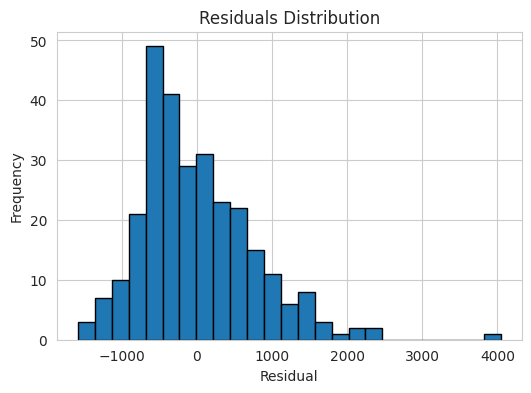

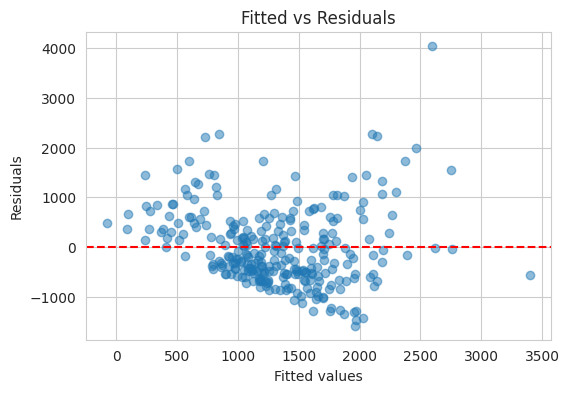

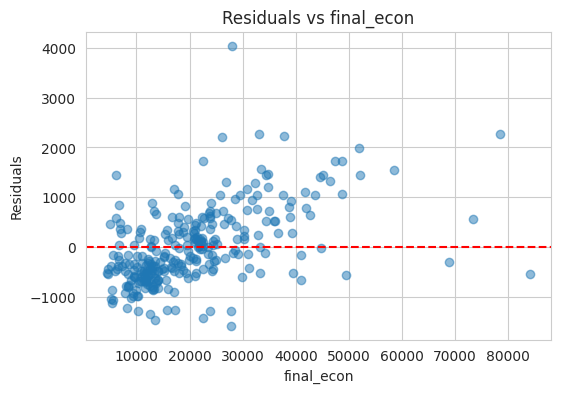

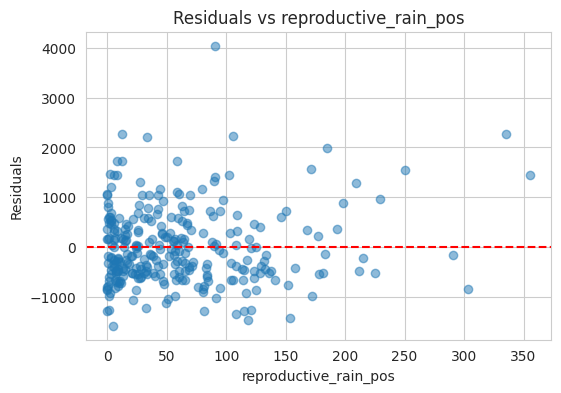

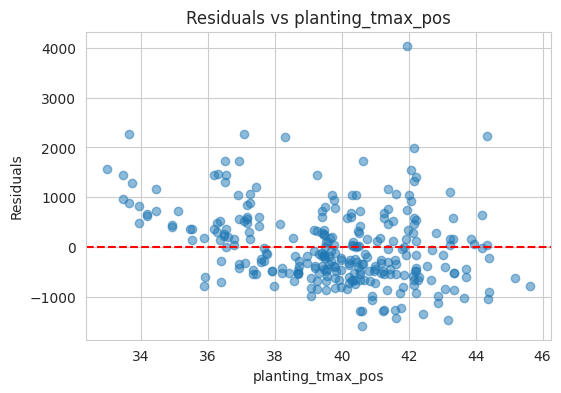

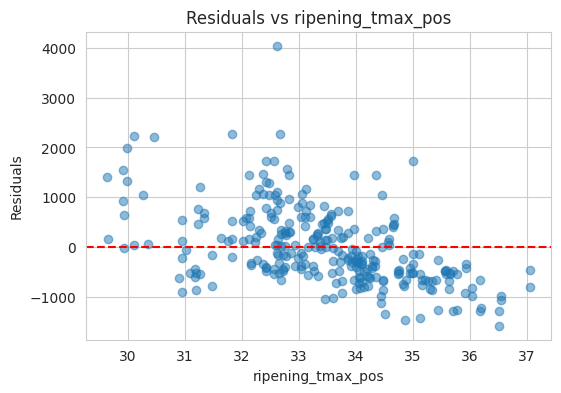

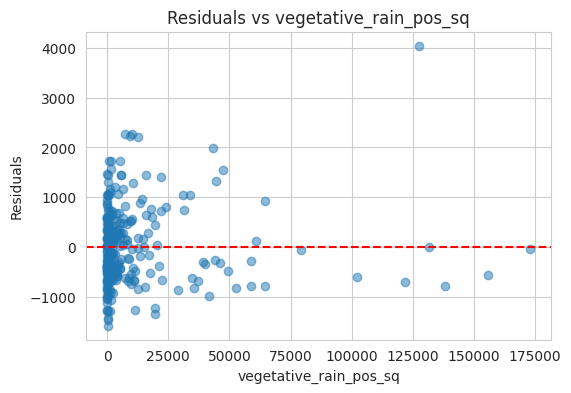


Shapiro-Wilk test: stat=0.9442, p=0.0000
Residuals deviate from normality

RMSE per district (sample period):
District 148: RMSE = 1203.792
District 149: RMSE = 904.132
District 152: RMSE = 788.395
District 24: RMSE = 673.529
District 27: RMSE = 629.046
District 34: RMSE = 486.171
District 38: RMSE = 634.516
District 4: RMSE = 499.515
District 43: RMSE = 600.608
District 44: RMSE = 672.478
District 69: RMSE = 818.027
District 73: RMSE = 1243.623
District 75: RMSE = 661.442
District 80: RMSE = 795.039
District 93: RMSE = 535.875
District 94: RMSE = 633.201

Overall RMSE (sample period, used rows): 769.311
Saved sample actual vs predicted to sample_actual_vs_predicted.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Step M: Regenerate features in val & forecast (auto) ===

=== Validation (2023) prediction ===


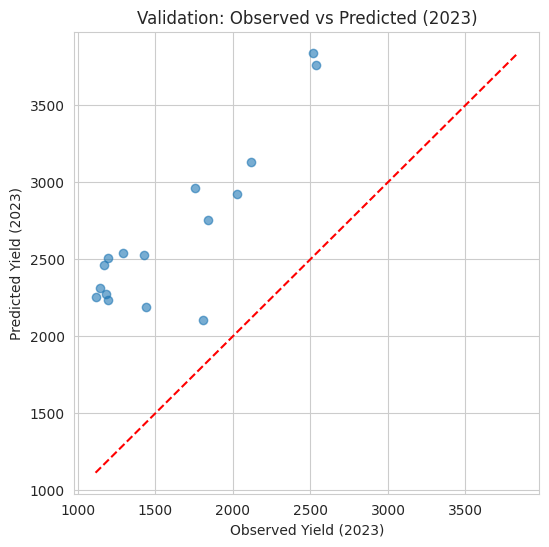

Validation RMSE (2023): 1094.574
Saved validation file to validation_2023_actual_vs_predicted.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Forecast (2024-2025) prediction ===
                  yield_predicted
district_id year                 
1           2024      2292.266124
            2025      2006.094211
148         2024      3044.125844
            2025      2832.336592
149         2024      2727.536448
            2025      2292.205705
152         2024      2245.726317
            2025      2049.117350
24          2024      1858.822170
            2025      1655.154761
27          2024      2594.568847
            2025      2195.970218
34          2024      2243.319366
            2025      1797.185167
38          2024      2549.301264
            2025      2142.716811
4           2024      2275.986217
            2025      1964.461748
43          2024      2324.667923
            2025      1999.720814
44          2024      2477.744944
            2025      2289.479011
69          2024      2845.004591
            2025      2462.447980
73          2024      3099.764802
            2025      2795.508538
75     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Pipeline finished. Final variables used: ['final_econ', 'reproductive_rain_pos', 'planting_tmax_pos', 'ripening_tmax_pos', 'vegetative_rain_pos_sq']
Feature map keys (sample): ['final_econ', 'reproductive_rain_pos', 'planting_tmax_pos', 'ripening_tmax_pos', 'vegetative_rain_pos_sq']


In [ ]:
# =================== FULL FEIS PIPELINE (robust, feature_map integrated) ===================
# NOTE: Run in a single Colab cell.

!pip install linearmodels --quiet

# ------------------- Imports -------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# ------------------- User Config -------------------
ZONE_CLUSTER = 9       # change as needed
P_SIGN = 0.10
VIF_THRESH = 10.0
TRAIN_YEARS = list(range(2005,2023))
VAL_YEAR = 2023
FORECAST_YEARS = [2024, 2025]

# ------------------- Upload Data -------------------
from google.colab import files
print("Upload your CSV file (must include yield_val).")
uploaded = files.upload()
fn = list(uploaded.keys())[0]
df = pd.read_csv(fn)

# ------------------- Standardize Columns -------------------
required_cols = ['district_id','year','zone_cluster','yield_val']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df = df[(df['year'] >= 2005) & (df['year'] <= 2025)].copy()
df['district_id'] = df['district_id'].astype(str)
df['year'] = df['year'].astype(int)
df['zone_cluster'] = df['zone_cluster'].astype(int)

# ------------------- Candidate variable groups (auto-detect) -------------------
econ_candidates_all = [f for f in df.columns if 'econ' in f.lower()]
irrigation_vars_all = [c for c in ['gw_reciprocal','reservoir_intensity','canal_intensity',
                                   'well_intensity','tank_intensity','oth_intensity'] if c in df.columns]
stress_vars_all = [c for c in ['heat_stress','drought'] if c in df.columns]
rain_weeks_all = [f'rf_week{i}' for i in range(20,43) if f'rf_week{i}' in df.columns]
tmax_weeks_all = [f'tmax_week{i}' for i in range(20,43) if f'tmax_week{i}' in df.columns]
tmin_weeks_all = [f'tmin_week{i}' for i in range(20,43) if f'tmin_week{i}' in df.columns]

all_candidates = list(set(econ_candidates_all + irrigation_vars_all +
                          stress_vars_all + rain_weeks_all +
                          tmax_weeks_all + tmin_weeks_all))

# ------------------- Impute Missing Values (within-district ffill/bfill then median) -------------------
if all_candidates:
    df[all_candidates] = df.groupby('district_id')[all_candidates].transform(lambda g: g.ffill().bfill())
    for col in all_candidates:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)

# Keep districts with at least 2 years
district_counts = df.groupby('district_id')['year'].nunique()
df = df[df['district_id'].isin(district_counts[district_counts >= 2].index)]

print("\nData prepared:", df.shape, "years", df['year'].min(), "to", df['year'].max())
print("Zone clusters available:", sorted(df['zone_cluster'].unique()))

# ------------------- Cluster Subset -------------------
cluster = df[df['zone_cluster'] == ZONE_CLUSTER].copy()
if cluster.empty:
    raise ValueError(f"No data for zone_cluster={ZONE_CLUSTER}")

train = cluster[cluster['year'].isin(TRAIN_YEARS)].copy()
val = cluster[cluster['year'] == VAL_YEAR].copy()
forecast_df = cluster[cluster['year'].isin(FORECAST_YEARS)].copy()

if train.empty:
    raise ValueError(f"No training data for zone_cluster={ZONE_CLUSTER}")

print(f"\nWorking on zone_cluster {ZONE_CLUSTER}: train={len(train)}, val={len(val)}, forecast={len(forecast_df)}")

# ------------------- Helper Functions -------------------
def feis_fit(y, X, data):
    """Panel FEIS fit (entity + time effects). X is list of column names in data."""
    try:
        panel = data.set_index(['district_id','year'])
        exog = sm.add_constant(panel[X], has_constant='add')
        mod = PanelOLS(panel[y], exog, entity_effects=True, time_effects=True)
        res = mod.fit(cov_type="robust")
        return res
    except Exception:
        return None

def safe_fit(formula, df):
    try:
        model = sm.OLS.from_formula(formula, df).fit()
        return model
    except Exception:
        return None

# ------------------- Structures to record feature_map & groups -------------------
feature_map = {}
rain_groups = {}
temp_groups = {}
irrig_pos_list, irrig_neg_list = [], []
interaction_kept = []
quad_kept = []

# ------------------- STEP A: Economic Variables -------------------
print("\n=== STEP A: Economic Variable Selection ===")
econ_candidates = econ_candidates_all.copy()
selected_econ = []

for var in econ_candidates:
    if var not in train.columns:
        continue
    res = feis_fit('yield_val', [var], train)
    if res is None:
        continue
    coef = res.params.get(var, np.nan)
    p = res.pvalues.get(var, np.nan)
    print(f" Econ {var}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN) and (coef > 0):
        if not selected_econ:
            selected_econ = [var]
            print(f" -> selected first econ {var}")
        else:
            avg_name = "econ_avg_temp"
            train[avg_name] = train[selected_econ + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', [avg_name], train)
            if res_avg:
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                coef_avg = res_avg.params.get(avg_name, np.nan)
                cur_avg = "econ_avg_current"
                train[cur_avg] = train[selected_econ].mean(axis=1)
                res_current = feis_fit('yield_val', [cur_avg], train)
                p_current = res_current.pvalues.get(cur_avg, np.nan) if res_current else np.nan
                train.drop(columns=[cur_avg], inplace=True, errors='ignore')
                print(f" Averaged {selected_econ + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, vs current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_econ.append(var)
                    print(f" -> kept {var} in econ group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

if selected_econ:
    train['final_econ'] = train[selected_econ].mean(axis=1)
    if not val.empty:
        val['final_econ'] = val[selected_econ].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['final_econ'] = forecast_df[selected_econ].mean(axis=1)
    base_features = ['final_econ']
    feature_map['final_econ'] = list(selected_econ)
else:
    base_features = []
print("Selected economic vars:", selected_econ)

# ------------------- STEP B: GW & Reservoir -------------------
print("\n=== STEP B: GW reciprocal & Reservoir ===")
gw_candidates = ['gw_reciprocal','reservoir_intensity']
for v in gw_candidates:
    if v in train.columns:
        features_to_test = base_features + [v]
        res = feis_fit('yield_val', features_to_test, train)
        if res is None:
            continue
        coef = res.params.get(v, np.nan)
        p = res.pvalues.get(v, np.nan)
        print(f" {v}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(v)
            feature_map[v] = ('raw', v)
            print(f" -> kept {v}")

print("Base features after Step B:", base_features)

# ------------------- STEP C: Rainfall Weekly -------------------
print("\n=== STEP C: Rainfall Weekly Selection ===")
stage_weeks = {
    'planting': list(range(20,29)),
    'vegetative': list(range(29,34)),
    'reproductive': list(range(34,39)),
    'ripening': list(range(39,43))
}

for stage, weeks in stage_weeks.items():
    weekly_cols = [f"rf_week{i}" for i in weeks if f"rf_week{i}" in train.columns]
    if not weekly_cols:
        print(f" No weekly rain cols for {stage}, skipping")
        continue

    print(f"\nTesting {stage} weekly cols: {weekly_cols}")
    pos_candidates, neg_candidates = [], []

    for col in weekly_cols:
        res = feis_fit('yield_val', base_features + [col], train)
        if res is None:
            continue
        coef = res.params.get(col, np.nan)
        p = res.pvalues.get(col, np.nan)
        print(f" {col}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            if coef > 0:
                pos_candidates.append(col)
                print(f"  -> {col} added to positive candidates")
            else:
                neg_candidates.append(col)
                print(f"  -> {col} added to negative candidates")

    # positive sequential averaging
    selected_pos = []
    for var in pos_candidates:
        if not selected_pos:
            selected_pos = [var]
            print(f" -> Selected first positive var for {stage}: {var}")
        else:
            avg_name = f'{stage}_pos_avg_temp'
            train[avg_name] = train[selected_pos + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_pos) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_pos[0]], train)
                    p_current = res_current.pvalues.get(selected_pos[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_pos_avg'
                    train[cur_avg_name] = train[selected_pos].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_pos.append(var)
                    print(f" -> kept {var} in positive group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # negative sequential averaging
    selected_neg = []
    for var in neg_candidates:
        if not selected_neg:
            selected_neg = [var]
            print(f" -> Selected first negative var for {stage}: {var}")
        else:
            avg_name = f'{stage}_neg_avg_temp'
            train[avg_name] = train[selected_neg + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_neg) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_neg[0]], train)
                    p_current = res_current.pvalues.get(selected_neg[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_neg_avg'
                    train[cur_avg_name] = train[selected_neg].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and (p_avg < p_current):
                    selected_neg.append(var)
                    print(f" -> kept {var} in negative group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # Create aggregated variables and record into feature_map
    rain_groups[stage] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

    if selected_pos:
        cname = f"{stage}_rain_pos"
        train[cname] = train[selected_pos].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_pos].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_pos)

    if selected_neg:
        cname = f"{stage}_rain_neg"
        train[cname] = train[selected_neg].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_neg].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_neg)

print("Base features after Step C:", base_features)

# ------------------- STEP D: Temperature Weekly -------------------
print("\n=== STEP D: Temperature Weekly ===")
for temp in ['tmax','tmin']:
    week_cols = [f"{temp}_week{i}" for i in range(20,43) if f"{temp}_week{i}" in train.columns]
    if not week_cols:
        print(f" No weekly {temp} data found, skipping {temp}")
        continue

    for stage, weeks in stage_weeks.items():
        cols = [f"{temp}_week{i}" for i in weeks if f"{temp}_week{i}" in train.columns]
        if not cols:
            continue

        print(f"\nTesting {temp} for stage {stage}: {cols}")
        pos_candidates, neg_candidates = [], []

        for col in cols:
            res = feis_fit('yield_val', base_features + [col], train)
            if res is None:
                continue
            coef = res.params.get(col, np.nan)
            p = res.pvalues.get(col, np.nan)
            print(f" {col}: coef={coef:.6f}, p={p:.4f}")
            if (not np.isnan(p)) and (p < P_SIGN):
                if coef > 0:
                    pos_candidates.append(col)
                    print(f"  -> {col} added to positive candidates")
                else:
                    neg_candidates.append(col)
                    print(f"  -> {col} added to negative candidates")

        # positive sequential averaging
        selected_pos = []
        for var in pos_candidates:
            if not selected_pos:
                selected_pos = [var]
                print(f" -> Selected first positive {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_pos_avg_temp'
                train[avg_name] = train[selected_pos + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_pos] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_pos:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and prev_ok:
                        selected_pos.append(var)
                        print(f" -> kept {var} in positive group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # negative sequential averaging
        selected_neg = []
        for var in neg_candidates:
            if not selected_neg:
                selected_neg = [var]
                print(f" -> Selected first negative {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_neg_avg_temp'
                train[avg_name] = train[selected_neg + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_neg] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_neg:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and prev_ok:
                        selected_neg.append(var)
                        print(f" -> kept {var} in negative group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # Aggregate and record
        key = (stage, temp)
        temp_groups[key] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

        if selected_pos:
            cname = f"{stage}_{temp}_pos"
            train[cname] = train[selected_pos].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_pos].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_pos)

        if selected_neg:
            cname = f"{stage}_{temp}_neg"
            train[cname] = train[selected_neg].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_neg].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_neg)

print("Base features after Step D (Temp):", base_features)

# ------------------- STEP E: Irrigation -------------------
print("\n=== STEP E: Irrigation ===")
irrig_pos_list, irrig_neg_list = [], []
irr_vars = [v for v in ['canal_intensity','well_intensity','tank_intensity','oth_intensity'] if v in train.columns]

for v in irr_vars:
    features_to_test = [f for f in base_features if f not in irrig_pos_list + irrig_neg_list] + [v]
    res = feis_fit('yield_val', features_to_test, train)
    if res is None:
        continue
    coef = res.params.get(v, np.nan)
    p = res.pvalues.get(v, np.nan)
    print(f" {v}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN):
        if coef > 0:
            irrig_pos_list.append(v)
            print(f" -> added to irrigation_pos: {v}")
        else:
            irrig_neg_list.append(v)
            print(f" -> added to irrigation_neg: {v}")

if irrig_pos_list:
    train['irrigation_pos'] = train[irrig_pos_list].mean(axis=1)
    if not val.empty:
        val['irrigation_pos'] = val[irrig_pos_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_pos'] = forecast_df[irrig_pos_list].mean(axis=1)
    base_features.append('irrigation_pos')
    feature_map['irrigation_pos'] = list(irrig_pos_list)

if irrig_neg_list:
    train['irrigation_neg'] = train[irrig_neg_list].mean(axis=1)
    if not val.empty:
        val['irrigation_neg'] = val[irrig_neg_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_neg'] = forecast_df[irrig_neg_list].mean(axis=1)
    base_features.append('irrigation_neg')
    feature_map['irrigation_neg'] = list(irrig_neg_list)

print("Irrigation pos:", irrig_pos_list, "neg:", irrig_neg_list)
print("Base features after irrigation:", base_features)

# ------------------- STEP F: Stress Variables -------------------
print("\n=== STEP F: Stress Variables ===")
for s in ['heat_stress','drought']:
    if s in train.columns:
        res = feis_fit('yield_val', base_features + [s], train)
        if res is None:
            continue
        coef = res.params.get(s, np.nan)
        p = res.pvalues.get(s, np.nan)
        print(f" {s}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(s)
            feature_map[s] = ('raw', s)
            print(f" -> kept {s}")

print("Base features after stress vars:", base_features)

# ------------------- STEP J: Interactions -------------------
print("\n=== STEP J: Interaction testing ===")
current_vars = base_features.copy()

rain_cols = [c for c in current_vars if '_rain_' in c]
irr_cols = [c for c in current_vars if c.startswith('irrigation_')]
reservoir_col = 'reservoir_intensity' if 'reservoir_intensity' in train.columns else None

interaction_candidates = []
for r in rain_cols:
    for i in irr_cols:
        interaction_candidates.append((r, i))
if reservoir_col:
    for r in rain_cols:
        interaction_candidates.append((r, reservoir_col))
    for i in irr_cols:
        interaction_candidates.append((i, reservoir_col))

for var1, var2 in interaction_candidates:
    # guard: both vars must exist in train (sometimes groups missing)
    if var1 not in train.columns or var2 not in train.columns:
        continue
    name = f"{var1}_x_{var2}"
    train[name] = train[var1] * train[var2]
    if not val.empty:
        val[name] = val[var1] * val[var2]
    if not forecast_df.empty:
        forecast_df[name] = forecast_df[var1] * forecast_df[var2]

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [name]), train)
    p_val = res.pvalues.get(name, np.nan) if res is not None else np.nan
    print(f" Interaction {name}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(name)
        interaction_kept.append(name)
        feature_map[name] = ('interaction', var1, var2)
        print(f" -> kept interaction {name}")
    else:
        train.drop(columns=[name], inplace=True, errors='ignore')
        val.drop(columns=[name], inplace=True, errors='ignore')
        forecast_df.drop(columns=[name], inplace=True, errors='ignore')

print("Interactions kept:", interaction_kept)

# ------------------- STEP K: Quadratic Rain -------------------
print("\n=== STEP K: Quadratic rain terms ===")
quad_kept = []
# use current_vars because interactions may have extended it
rain_cols = [c for c in current_vars if '_rain_' in c]
for rcol in rain_cols:
    if rcol not in train.columns:
        continue
    qname = f"{rcol}_sq"
    train[qname] = train[rcol] ** 2
    if not val.empty:
        val[qname] = val[rcol] ** 2
    if not forecast_df.empty:
        forecast_df[qname] = forecast_df[rcol] ** 2

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [qname]), train)
    p_val = res.pvalues.get(qname, np.nan) if res is not None else np.nan
    print(f" Quadratic {qname}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(qname)
        quad_kept.append(qname)
        feature_map[qname] = ('sq', rcol)
        print(f" -> kept quadratic {qname}")
    else:
        train.drop(columns=[qname], inplace=True, errors='ignore')
        val.drop(columns=[qname], inplace=True, errors='ignore')
        forecast_df.drop(columns=[qname], inplace=True, errors='ignore')

print("Quadratic kept:", quad_kept)

# ------------------- STEP L: VIF & p-value pruning -------------------
print("\n=== STEP L: VIF & p-value pruning ===")
final_vars = current_vars.copy()
train_panel = train.set_index(['district_id','year']).sort_index()

def calculate_vif(df, vars_list):
    try:
        X = sm.add_constant(df[vars_list], has_constant='add')
        vif_data = pd.DataFrame()
        vif_data['variable'] = vars_list
        vifs = []
        for i in range(len(vars_list)):
            try:
                vifs.append(variance_inflation_factor(X.values, i+1))
            except Exception:
                vifs.append(np.nan)
        vif_data['VIF'] = vifs
        return vif_data
    except Exception as e:
        return pd.DataFrame({'variable': vars_list, 'VIF': [np.nan]*len(vars_list)})

iteration = 0
while True:
    iteration += 1
    print(f"\nIteration {iteration}: computing VIF")
    vif_df = calculate_vif(train_panel, final_vars)
    print(vif_df)
    # handle all-NaN VIF_df
    if vif_df['VIF'].dropna().empty:
        print("VIFs not available / all NaN; stop VIF pruning.")
        break
    max_vif = vif_df['VIF'].max()
    if max_vif > VIF_THRESH:
        drop_var = vif_df.loc[vif_df['VIF'] == max_vif, 'variable'].values[0]
        print(f" -> dropping {drop_var} due to high VIF {max_vif:.2f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue

    # Fit PanelOLS and check p-values
    X_tmp = sm.add_constant(train_panel[final_vars], has_constant='add')
    y_tmp = train_panel['yield_val']
    try:
        model = PanelOLS(y_tmp, X_tmp, entity_effects=True, time_effects=True).fit(cov_type='robust')
    except Exception as e:
        print(" PanelOLS error during pruning:", e)
        break

    pvals = model.pvalues.drop('const', errors='ignore')
    if (pvals >= P_SIGN).any():
        drop_var = pvals.idxmax()
        print(f" -> dropping {drop_var} due to high p-value {pvals[drop_var]:.4f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue
    else:
        print("All VIFs and p-values OK")
        break

print("\nFinal selected variables (auto-detected):", final_vars)

# ------------------- Final FEIS Model -------------------
print("\n=== Fitting final FEIS model ===")
train_panel = train.set_index(['district_id','year']).sort_index()
# ensure final_vars exist in train_panel (if not, remove missing)
final_vars = [v for v in final_vars if v in train_panel.columns]
X_final = sm.add_constant(train_panel[final_vars], has_constant='add')
y_final = train_panel['yield_val']
res_final = PanelOLS(y_final, X_final, entity_effects=True, time_effects=True).fit(cov_type='robust')
print(res_final.summary)

# ------------------- SAFE Residual Diagnostics & RMSE -------------------
# Build X_full and y_full then determine used rows (no-NaN)
X_full = sm.add_constant(train_panel[final_vars], has_constant='add')
y_full = train_panel['yield_val']
used_mask = X_full.notnull().all(axis=1) & y_full.notnull()
used_index = X_full.index[used_mask]

if len(used_index) == 0:
    raise ValueError("No usable rows for diagnostics after filtering missing values.")

# Fitted using params (only for used_index)
fitted_used = pd.Series(X_full.loc[used_index].dot(res_final.params), index=used_index, name='fitted')

# Create fitted aligned to full train_panel index (NaNs where not available)
fitted = fitted_used.reindex(train_panel.index)

# Residuals (NaN where fitted missing)
residuals = y_full - fitted

print("\nResidual summary statistics (used rows only):")
print(residuals.dropna().describe())

# Plots (drop NaNs where appropriate)
plt.figure(figsize=(6,4))
plt.hist(residuals.dropna(), bins=25, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(fitted.dropna(), residuals.dropna(), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Fitted vs Residuals")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

for var in final_vars:
    if var in X_final.columns:
        plt.figure(figsize=(6,4))
        # align predictor to same index subset
        plt.scatter(X_final[var].loc[fitted.dropna().index], residuals.dropna(), alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f"Residuals vs {var}")
        plt.xlabel(var)
        plt.ylabel("Residuals")
        plt.show()

# Shapiro-Wilk
resid_nonan = residuals.dropna()
if len(resid_nonan) >= 3:
    stat, p_sw = shapiro(resid_nonan)
    print(f"\nShapiro-Wilk test: stat={stat:.4f}, p={p_sw:.4f}")
    print("Residuals roughly normal" if p_sw > 0.05 else "Residuals deviate from normality")
else:
    print("\nNot enough residuals for Shapiro-Wilk test (need >=3).")

# RMSE per district (safe drop NaNs)
rmse_dict = {}
for d in train_panel.index.get_level_values('district_id').unique():
    y_true = y_full.xs(d, level='district_id')
    y_pred = fitted.xs(d, level='district_id')
    df_tmp = pd.concat([y_true, y_pred], axis=1, keys=['y_true','y_pred']).dropna()
    if not df_tmp.empty:
        rmse_dict[d] = np.sqrt(mean_squared_error(df_tmp['y_true'], df_tmp['y_pred']))

print("\nRMSE per district (sample period):")
for d, r in rmse_dict.items():
    print(f"District {d}: RMSE = {r:.3f}")

# Overall RMSE (drop NaNs)
df_all = pd.concat([y_full, fitted], axis=1, keys=['y_true', 'y_pred']).dropna()
overall_rmse = np.sqrt(mean_squared_error(df_all['y_true'], df_all['y_pred']))
print(f"\nOverall RMSE (sample period, used rows): {overall_rmse:.3f}")

# ------------------- Save sample actual vs predicted CSV -------------------
df_sample = df_all.reset_index()[['district_id','year','y_true','y_pred']].rename(columns={'y_true':'yield_actual','y_pred':'yield_predicted'})
out_sample = "sample_actual_vs_predicted.csv"
df_sample.to_csv(out_sample, index=False)
print(f"Saved sample actual vs predicted to {out_sample}")
try:
    files.download(out_sample)
except Exception:
    pass

# ------------------- Feature Regeneration Utility -------------------
def regenerate_features(df_in, feature_map, fill_value=0.0, max_iters=20):
    """Rebuild derived features for df_in using the feature_map.
       Safe: missing raw columns are filled with fill_value (scalar)."""
    df = df_in.copy()
    # prefill missing raw columns referenced in feature_map with fill_value
    for rule in feature_map.values():
        if isinstance(rule, list):
            for c in rule:
                if c not in df.columns:
                    df[c] = fill_value
        elif isinstance(rule, tuple) and rule[0] == 'raw':
            col = rule[1]
            if col not in df.columns:
                df[col] = fill_value

    it = 0
    while it < max_iters:
        it += 1
        changed = False
        for feat, rule in feature_map.items():
            if feat in df.columns:
                continue
            try:
                if isinstance(rule, list):
                    if all([c in df.columns for c in rule]):
                        df[feat] = df[rule].mean(axis=1)
                        changed = True
                elif isinstance(rule, tuple):
                    if rule[0] == 'sq' and rule[1] in df.columns:
                        df[feat] = df[rule[1]] ** 2
                        changed = True
                    elif rule[0] == 'interaction':
                        v1, v2 = rule[1], rule[2]
                        if v1 in df.columns and v2 in df.columns:
                            df[feat] = df[v1] * df[v2]
                            changed = True
                    elif rule[0] == 'raw' and rule[1] in df.columns:
                        df[feat] = df[rule[1]]
                        changed = True
                else:
                    # if rule is string (alias)
                    if isinstance(rule, str) and rule in df.columns:
                        df[feat] = df[rule]
                        changed = True
            except Exception:
                pass
        if not changed:
            break
    return df

# -------------------- Step M: Regenerate features in val & forecast --------------------
print("\n=== Step M: Regenerate features in val & forecast (auto) ===")
if not val.empty:
    val = regenerate_features(val, feature_map)
if not forecast_df.empty:
    forecast_df = regenerate_features(forecast_df, feature_map)

# Ensure all final_vars present in val & forecast (fill with median from train or 0)
for col in final_vars:
    if not val.empty and col not in val.columns:
        val[col] = train[col].median() if col in train.columns else 0.0
    if not forecast_df.empty and col not in forecast_df.columns:
        forecast_df[col] = train[col].median() if col in train.columns else 0.0

# ------------------- Validation (2023) prediction -------------------
print("\n=== Validation (2023) prediction ===")
if not val.empty and VAL_YEAR in val['year'].unique():
    val_panel = val.set_index(['district_id','year']).sort_index()
    X_val = sm.add_constant(val_panel[final_vars], has_constant='add')
    # ensure all params columns exist in X_val
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_val.columns:
            X_val[col] = 0.0
    X_val = X_val[res_final.params.index]  # reorder to match params
    y_val = val_panel['yield_val']
    y_pred_val = pd.Series(X_val.dot(res_final.params), index=X_val.index, name='yield_predicted')

    # align and drop NaNs for RMSE & plotting
    df_val_check = pd.concat([y_val, y_pred_val], axis=1).dropna()
    if df_val_check.empty:
        print("No valid validation rows after alignment (all NaN).")
    else:
        plt.figure(figsize=(6,6))
        plt.scatter(df_val_check.iloc[:,0], df_val_check.iloc[:,1], alpha=0.6)
        mn = min(df_val_check.iloc[:,0].min(), df_val_check.iloc[:,1].min())
        mx = max(df_val_check.iloc[:,0].max(), df_val_check.iloc[:,1].max())
        plt.plot([mn,mx],[mn,mx],'r--')
        plt.xlabel("Observed Yield (2023)")
        plt.ylabel("Predicted Yield (2023)")
        plt.title(f"Validation: Observed vs Predicted ({VAL_YEAR})")
        plt.show()

        val_rmse = np.sqrt(mean_squared_error(df_val_check.iloc[:,0], df_val_check.iloc[:,1]))
        print(f"Validation RMSE (2023): {val_rmse:.3f}")

    # Save validation CSV (actual + predicted)
    df_val_out = df_val_check.reset_index().rename(columns={df_val_check.columns[0]:'yield_actual', df_val_check.columns[1]:'yield_predicted'})
    out_val = "validation_2023_actual_vs_predicted.csv"
    df_val_out.to_csv(out_val, index=False)
    print(f"Saved validation file to {out_val}")
    try:
        files.download(out_val)
    except Exception:
        pass

# ------------------- Forecast (2024-2025) prediction -------------------
print("\n=== Forecast (2024-2025) prediction ===")
if not forecast_df.empty:
    forecast_panel = forecast_df.set_index(['district_id','year']).sort_index()
    X_fore = sm.add_constant(forecast_panel[final_vars], has_constant='add')
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_fore.columns:
            X_fore[col] = 0.0
    X_fore = X_fore[res_final.params.index]
    y_fore_pred = pd.Series(X_fore.dot(res_final.params), index=X_fore.index, name='yield_predicted')

    # attach forecast predictions back to panel
    forecast_out = forecast_panel.copy()
    forecast_out['yield_predicted'] = np.nan
    forecast_out.loc[y_fore_pred.index, 'yield_predicted'] = y_fore_pred.values

    print(forecast_out[['yield_predicted']].dropna().head(40))

    # Save forecast CSV
    df_fore_out = forecast_out.reset_index()[['district_id','year','yield_predicted']]
    out_fore = "forecast_2024_2025_predicted.csv"
    df_fore_out.to_csv(out_fore, index=False)
    print(f"Saved forecast file to {out_fore}")
    try:
        files.download(out_fore)
    except Exception:
        pass

# ------------------- Done -------------------
print("\nPipeline finished. Final variables used:", final_vars)
print("Feature map keys (sample):", list(feature_map.keys())[:40])


Upload your CSV file (must include yield_val).


Saving data1.csv to data1 (16).csv

Data prepared: (3612, 209) years 2005 to 2025
Zone clusters available: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Working on zone_cluster 6: train=810, val=45, forecast=90

=== STEP A: Economic Variable Selection ===
 Econ econ_inc_rev1: coef=0.011246, p=0.0000
 -> selected first econ econ_inc_rev1
 Econ econ_inc_rev2: coef=0.010157, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev2'] -> coef=0.010748, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev3: coef=0.011326, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev3'] -> coef=0.011520, p=0.0000, vs current p=0.0000
 -> kept econ_inc_rev3 in econ group
 Econ econ_inc_rev4: coef=0.009805, p=0.0001
 Averaged ['econ_inc_rev1', 'econ_inc_rev3', 'econ_inc_rev4'] -> coef=0.011247, p=0.0000, vs current p=0.0000
 Econ econ_inc_rev5: coef=0.010766, p=0.0000
 Averaged ['econ_inc_rev1', 'econ_inc_rev3', 'econ_inc_rev5'] -> coef=0.011490, p=0.0000, vs current p=0.0000
 Eco

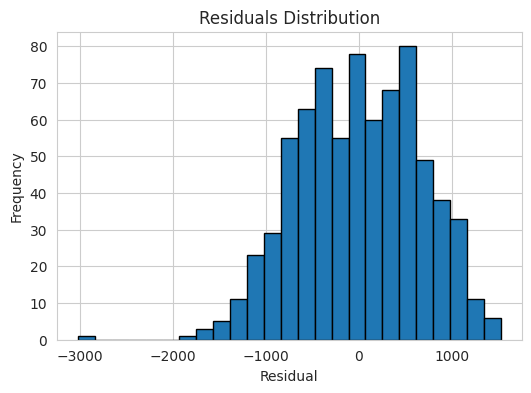

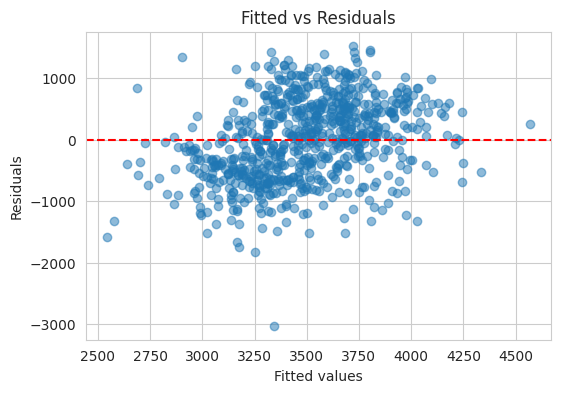

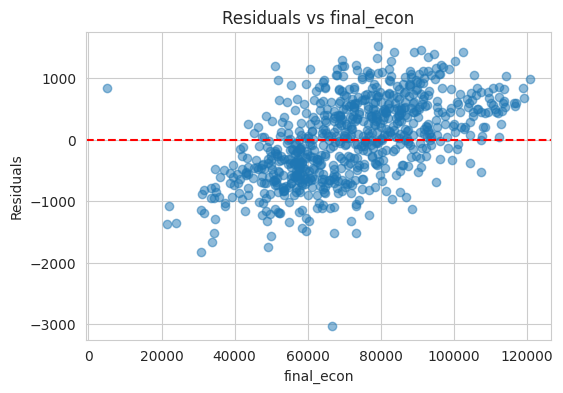

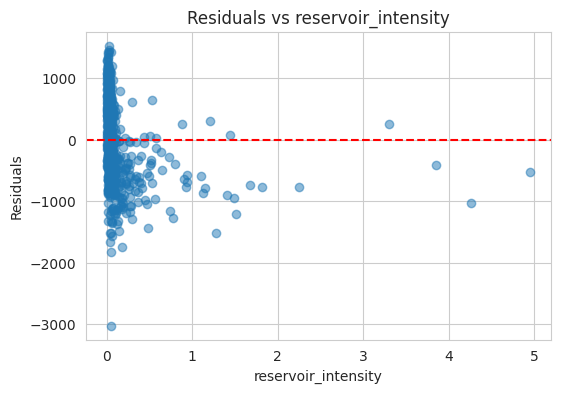

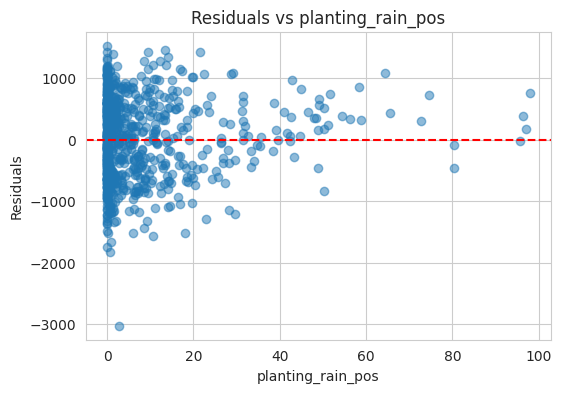

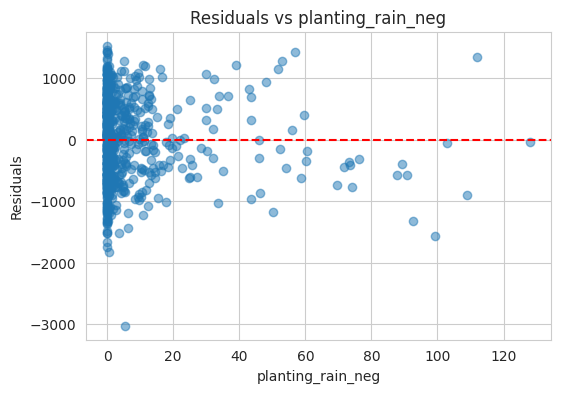

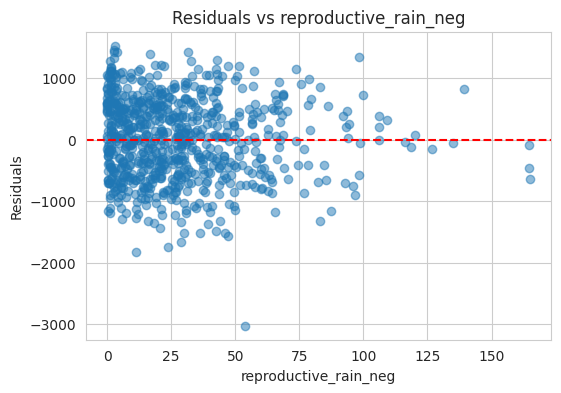

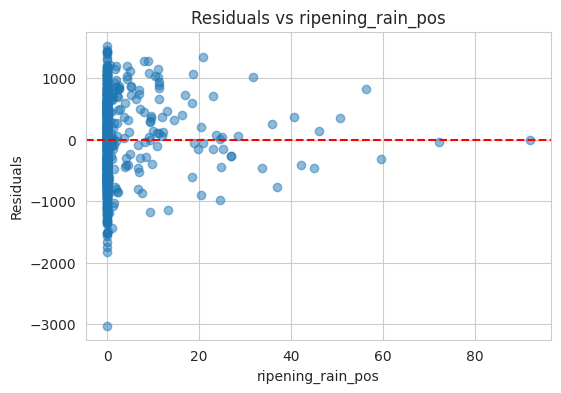

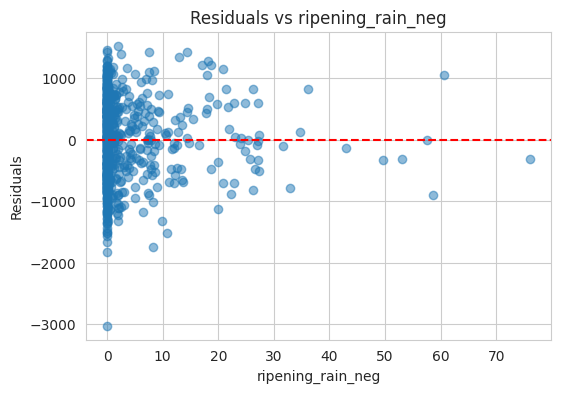

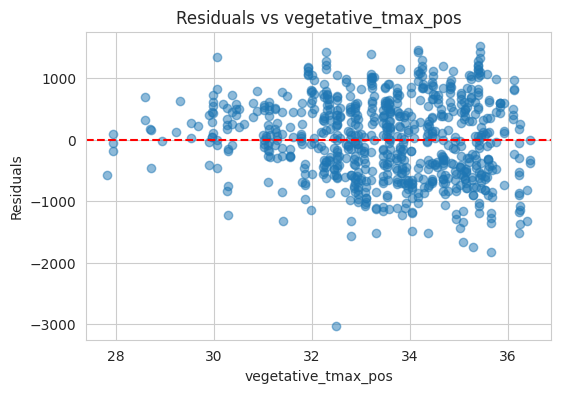

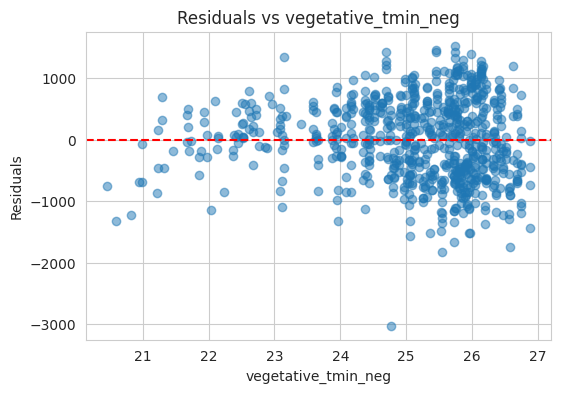


Shapiro-Wilk test: stat=0.9895, p=0.0000
Residuals deviate from normality

RMSE per district (sample period):
District 100: RMSE = 912.164
District 108: RMSE = 716.047
District 113: RMSE = 892.442
District 116: RMSE = 494.594
District 119: RMSE = 360.223
District 122: RMSE = 688.578
District 123: RMSE = 551.531
District 124: RMSE = 625.000
District 125: RMSE = 558.588
District 127: RMSE = 838.703
District 128: RMSE = 581.123
District 137: RMSE = 819.604
District 138: RMSE = 1052.055
District 139: RMSE = 361.286
District 142: RMSE = 272.244
District 144: RMSE = 1023.102
District 160: RMSE = 813.147
District 163: RMSE = 663.680
District 165: RMSE = 483.082
District 172: RMSE = 348.799
District 23: RMSE = 1049.497
District 26: RMSE = 758.227
District 29: RMSE = 977.735
District 36: RMSE = 962.375
District 49: RMSE = 693.261
District 50: RMSE = 566.884
District 52: RMSE = 584.019
District 53: RMSE = 679.408
District 55: RMSE = 373.518
District 57: RMSE = 667.358
District 6: RMSE = 316.000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Step M: Regenerate features in val & forecast (auto) ===

=== Validation (2023) prediction ===


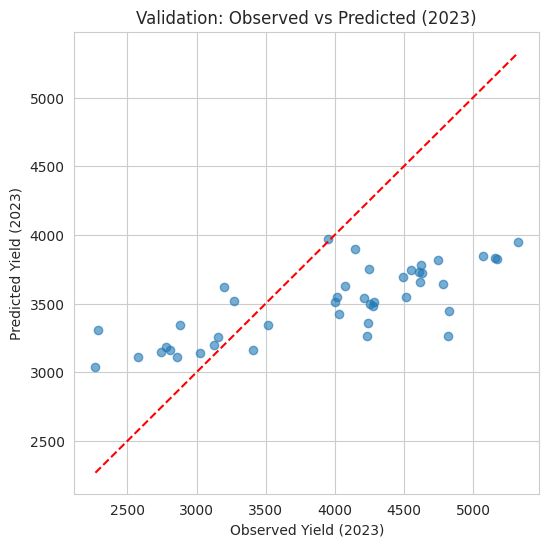

Validation RMSE (2023): 796.589
Saved validation predictions to validation_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Forecast (2024-2025) prediction ===
                  yield_predicted
district_id year                 
100         2024      4203.948761
            2025      4338.575203
102         2024      2825.027077
            2025      3089.591474
105         2024      3007.977307
            2025      3138.809001
108         2024      3970.292732
            2025      4169.903209
113         2024      4213.334789
            2025      4381.242295
116         2024      3856.135096
            2025      4051.868540
119         2024      4261.052155
            2025      4384.031986
122         2024      2936.962708
            2025      3143.838605
123         2024      3034.636750
            2025      3281.518631
124         2024      3743.549362
            2025      3831.554979
125         2024      3206.770182
            2025      3349.502968
127         2024      4455.121908
            2025      4360.717245
128         2024      4100.803265
            2025      4156.955243
137    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Pipeline finished. Final variables used: ['final_econ', 'reservoir_intensity', 'planting_rain_pos', 'planting_rain_neg', 'reproductive_rain_neg', 'ripening_rain_pos', 'ripening_rain_neg', 'vegetative_tmax_pos', 'vegetative_tmin_neg']
Feature map keys (sample): ['final_econ', 'reservoir_intensity', 'planting_rain_pos', 'planting_rain_neg', 'reproductive_rain_neg', 'ripening_rain_pos', 'ripening_rain_neg', 'vegetative_tmax_pos', 'vegetative_tmin_neg']


In [ ]:
# =================== FULL FEIS PIPELINE (robust, feature_map integrated) ===================
# NOTE: Run in a single Colab cell.

!pip install linearmodels --quiet

# ------------------- Imports -------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# ------------------- User Config -------------------
ZONE_CLUSTER = 6       # change as needed
P_SIGN = 0.10
VIF_THRESH = 10.0
TRAIN_YEARS = list(range(2005,2023))
VAL_YEAR = 2023
FORECAST_YEARS = [2024, 2025]

# ------------------- Upload Data -------------------
from google.colab import files
print("Upload your CSV file (must include yield_val).")
uploaded = files.upload()
fn = list(uploaded.keys())[0]
df = pd.read_csv(fn)

# ------------------- Standardize Columns -------------------
required_cols = ['district_id','year','zone_cluster','yield_val']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df = df[(df['year'] >= 2005) & (df['year'] <= 2025)].copy()
df['district_id'] = df['district_id'].astype(str)
df['year'] = df['year'].astype(int)
df['zone_cluster'] = df['zone_cluster'].astype(int)

# ------------------- Candidate variable groups (auto-detect) -------------------
econ_candidates_all = [f for f in df.columns if 'econ' in f.lower()]
irrigation_vars_all = [c for c in ['gw_reciprocal','reservoir_intensity','canal_intensity',
                                   'well_intensity','tank_intensity','oth_intensity'] if c in df.columns]
stress_vars_all = [c for c in ['heat_stress','drought'] if c in df.columns]
rain_weeks_all = [f'rf_week{i}' for i in range(20,43) if f'rf_week{i}' in df.columns]
tmax_weeks_all = [f'tmax_week{i}' for i in range(20,43) if f'tmax_week{i}' in df.columns]
tmin_weeks_all = [f'tmin_week{i}' for i in range(20,43) if f'tmin_week{i}' in df.columns]

all_candidates = list(set(econ_candidates_all + irrigation_vars_all +
                          stress_vars_all + rain_weeks_all +
                          tmax_weeks_all + tmin_weeks_all))

# ------------------- Impute Missing Values (within-district ffill/bfill then median) -------------------
if all_candidates:
    df[all_candidates] = df.groupby('district_id')[all_candidates].transform(lambda g: g.ffill().bfill())
    for col in all_candidates:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)

# Keep districts with at least 2 years
district_counts = df.groupby('district_id')['year'].nunique()
df = df[df['district_id'].isin(district_counts[district_counts >= 2].index)]

print("\nData prepared:", df.shape, "years", df['year'].min(), "to", df['year'].max())
print("Zone clusters available:", sorted(df['zone_cluster'].unique()))

# ------------------- Cluster Subset -------------------
cluster = df[df['zone_cluster'] == ZONE_CLUSTER].copy()
if cluster.empty:
    raise ValueError(f"No data for zone_cluster={ZONE_CLUSTER}")

train = cluster[cluster['year'].isin(TRAIN_YEARS)].copy()
val = cluster[cluster['year'] == VAL_YEAR].copy()
forecast_df = cluster[cluster['year'].isin(FORECAST_YEARS)].copy()

if train.empty:
    raise ValueError(f"No training data for zone_cluster={ZONE_CLUSTER}")

print(f"\nWorking on zone_cluster {ZONE_CLUSTER}: train={len(train)}, val={len(val)}, forecast={len(forecast_df)}")

# ------------------- Helper Functions -------------------
def feis_fit(y, X, data):
    """Panel FEIS fit (entity + time effects). X is list of column names in data."""
    try:
        panel = data.set_index(['district_id','year'])
        exog = sm.add_constant(panel[X], has_constant='add')
        mod = PanelOLS(panel[y], exog, entity_effects=True, time_effects=True)
        res = mod.fit(cov_type="robust")
        return res
    except Exception:
        return None

def safe_fit(formula, df):
    try:
        model = sm.OLS.from_formula(formula, df).fit()
        return model
    except Exception:
        return None

# ------------------- Structures to record feature_map & groups -------------------
feature_map = {}
rain_groups = {}
temp_groups = {}
irrig_pos_list, irrig_neg_list = [], []
interaction_kept = []
quad_kept = []

# ------------------- STEP A: Economic Variables -------------------
print("\n=== STEP A: Economic Variable Selection ===")
econ_candidates = econ_candidates_all.copy()
selected_econ = []

for var in econ_candidates:
    if var not in train.columns:
        continue
    res = feis_fit('yield_val', [var], train)
    if res is None:
        continue
    coef = res.params.get(var, np.nan)
    p = res.pvalues.get(var, np.nan)
    print(f" Econ {var}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN) and (coef > 0):
        if not selected_econ:
            selected_econ = [var]
            print(f" -> selected first econ {var}")
        else:
            avg_name = "econ_avg_temp"
            train[avg_name] = train[selected_econ + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', [avg_name], train)
            if res_avg:
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                coef_avg = res_avg.params.get(avg_name, np.nan)
                cur_avg = "econ_avg_current"
                train[cur_avg] = train[selected_econ].mean(axis=1)
                res_current = feis_fit('yield_val', [cur_avg], train)
                p_current = res_current.pvalues.get(cur_avg, np.nan) if res_current else np.nan
                train.drop(columns=[cur_avg], inplace=True, errors='ignore')
                print(f" Averaged {selected_econ + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, vs current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_econ.append(var)
                    print(f" -> kept {var} in econ group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

if selected_econ:
    train['final_econ'] = train[selected_econ].mean(axis=1)
    if not val.empty:
        val['final_econ'] = val[selected_econ].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['final_econ'] = forecast_df[selected_econ].mean(axis=1)
    base_features = ['final_econ']
    feature_map['final_econ'] = list(selected_econ)
else:
    base_features = []
print("Selected economic vars:", selected_econ)

# ------------------- STEP B: GW & Reservoir -------------------
print("\n=== STEP B: GW reciprocal & Reservoir ===")
gw_candidates = ['gw_reciprocal','reservoir_intensity']
for v in gw_candidates:
    if v in train.columns:
        features_to_test = base_features + [v]
        res = feis_fit('yield_val', features_to_test, train)
        if res is None:
            continue
        coef = res.params.get(v, np.nan)
        p = res.pvalues.get(v, np.nan)
        print(f" {v}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(v)
            feature_map[v] = ('raw', v)
            print(f" -> kept {v}")

print("Base features after Step B:", base_features)

# ------------------- STEP C: Rainfall Weekly -------------------
print("\n=== STEP C: Rainfall Weekly Selection ===")
stage_weeks = {
    'planting': list(range(20,29)),
    'vegetative': list(range(29,34)),
    'reproductive': list(range(34,39)),
    'ripening': list(range(39,43))
}

for stage, weeks in stage_weeks.items():
    weekly_cols = [f"rf_week{i}" for i in weeks if f"rf_week{i}" in train.columns]
    if not weekly_cols:
        print(f" No weekly rain cols for {stage}, skipping")
        continue

    print(f"\nTesting {stage} weekly cols: {weekly_cols}")
    pos_candidates, neg_candidates = [], []

    for col in weekly_cols:
        res = feis_fit('yield_val', base_features + [col], train)
        if res is None:
            continue
        coef = res.params.get(col, np.nan)
        p = res.pvalues.get(col, np.nan)
        print(f" {col}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            if coef > 0:
                pos_candidates.append(col)
                print(f"  -> {col} added to positive candidates")
            else:
                neg_candidates.append(col)
                print(f"  -> {col} added to negative candidates")

    # positive sequential averaging
    selected_pos = []
    for var in pos_candidates:
        if not selected_pos:
            selected_pos = [var]
            print(f" -> Selected first positive var for {stage}: {var}")
        else:
            avg_name = f'{stage}_pos_avg_temp'
            train[avg_name] = train[selected_pos + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_pos) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_pos[0]], train)
                    p_current = res_current.pvalues.get(selected_pos[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_pos_avg'
                    train[cur_avg_name] = train[selected_pos].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and (p_avg < p_current):
                    selected_pos.append(var)
                    print(f" -> kept {var} in positive group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # negative sequential averaging
    selected_neg = []
    for var in neg_candidates:
        if not selected_neg:
            selected_neg = [var]
            print(f" -> Selected first negative var for {stage}: {var}")
        else:
            avg_name = f'{stage}_neg_avg_temp'
            train[avg_name] = train[selected_neg + [var]].mean(axis=1)
            res_avg = feis_fit('yield_val', base_features + [avg_name], train)
            if res_avg:
                coef_avg = res_avg.params.get(avg_name, np.nan)
                p_avg = res_avg.pvalues.get(avg_name, np.nan)
                if len(selected_neg) == 1:
                    res_current = feis_fit('yield_val', base_features + [selected_neg[0]], train)
                    p_current = res_current.pvalues.get(selected_neg[0], np.nan) if res_current else np.nan
                else:
                    cur_avg_name = f'{stage}_current_neg_avg'
                    train[cur_avg_name] = train[selected_neg].mean(axis=1)
                    res_current = feis_fit('yield_val', base_features + [cur_avg_name], train)
                    p_current = res_current.pvalues.get(cur_avg_name, np.nan) if res_current else np.nan
                    train.drop(columns=[cur_avg_name], inplace=True, errors='ignore')
                print(f" {stage} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, current p={p_current:.4f}")
                if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and (p_avg < p_current):
                    selected_neg.append(var)
                    print(f" -> kept {var} in negative group")
            train.drop(columns=[avg_name], inplace=True, errors='ignore')

    # Create aggregated variables and record into feature_map
    rain_groups[stage] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

    if selected_pos:
        cname = f"{stage}_rain_pos"
        train[cname] = train[selected_pos].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_pos].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_pos)

    if selected_neg:
        cname = f"{stage}_rain_neg"
        train[cname] = train[selected_neg].mean(axis=1)
        if not val.empty:
            val[cname] = val[selected_neg].mean(axis=1)
        if not forecast_df.empty:
            forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
        base_features.append(cname)
        feature_map[cname] = list(selected_neg)

print("Base features after Step C:", base_features)

# ------------------- STEP D: Temperature Weekly -------------------
print("\n=== STEP D: Temperature Weekly ===")
for temp in ['tmax','tmin']:
    week_cols = [f"{temp}_week{i}" for i in range(20,43) if f"{temp}_week{i}" in train.columns]
    if not week_cols:
        print(f" No weekly {temp} data found, skipping {temp}")
        continue

    for stage, weeks in stage_weeks.items():
        cols = [f"{temp}_week{i}" for i in weeks if f"{temp}_week{i}" in train.columns]
        if not cols:
            continue

        print(f"\nTesting {temp} for stage {stage}: {cols}")
        pos_candidates, neg_candidates = [], []

        for col in cols:
            res = feis_fit('yield_val', base_features + [col], train)
            if res is None:
                continue
            coef = res.params.get(col, np.nan)
            p = res.pvalues.get(col, np.nan)
            print(f" {col}: coef={coef:.6f}, p={p:.4f}")
            if (not np.isnan(p)) and (p < P_SIGN):
                if coef > 0:
                    pos_candidates.append(col)
                    print(f"  -> {col} added to positive candidates")
                else:
                    neg_candidates.append(col)
                    print(f"  -> {col} added to negative candidates")

        # positive sequential averaging
        selected_pos = []
        for var in pos_candidates:
            if not selected_pos:
                selected_pos = [var]
                print(f" -> Selected first positive {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_pos_avg_temp'
                train[avg_name] = train[selected_pos + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_pos] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_pos:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} pos averaged {selected_pos + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg > 0) and prev_ok:
                        selected_pos.append(var)
                        print(f" -> kept {var} in positive group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # negative sequential averaging
        selected_neg = []
        for var in neg_candidates:
            if not selected_neg:
                selected_neg = [var]
                print(f" -> Selected first negative {temp} var for {stage}: {var}")
            else:
                avg_name = f'{stage}_{temp}_neg_avg_temp'
                train[avg_name] = train[selected_neg + [var]].mean(axis=1)
                features_avg = [f for f in base_features if f not in selected_neg] + [avg_name]
                res_avg = feis_fit('yield_val', features_avg, train)
                if res_avg:
                    coef_avg = res_avg.params.get(avg_name, np.nan)
                    p_avg = res_avg.pvalues.get(avg_name, np.nan)
                    prev_ok = True
                    for prev_var in selected_neg:
                        features_prev = [f for f in base_features if f != prev_var] + [prev_var, avg_name]
                        res_prev = feis_fit('yield_val', features_prev, train)
                        p_prev = res_prev.pvalues.get(prev_var, np.nan) if res_prev else np.nan
                        if np.isnan(p_prev) or p_prev >= P_SIGN:
                            prev_ok = False
                            break
                    print(f" {stage} {temp} neg averaged {selected_neg + [var]} -> coef={coef_avg:.6f}, p={p_avg:.4f}, prev_ok={prev_ok}")
                    if (not np.isnan(p_avg)) and (p_avg < P_SIGN) and (coef_avg < 0) and prev_ok:
                        selected_neg.append(var)
                        print(f" -> kept {var} in negative group")
                train.drop(columns=[avg_name], inplace=True, errors='ignore')

        # Aggregate and record
        key = (stage, temp)
        temp_groups[key] = {'pos': selected_pos.copy(), 'neg': selected_neg.copy()}

        if selected_pos:
            cname = f"{stage}_{temp}_pos"
            train[cname] = train[selected_pos].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_pos].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_pos].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_pos)

        if selected_neg:
            cname = f"{stage}_{temp}_neg"
            train[cname] = train[selected_neg].mean(axis=1)
            if not val.empty:
                val[cname] = val[selected_neg].mean(axis=1)
            if not forecast_df.empty:
                forecast_df[cname] = forecast_df[selected_neg].mean(axis=1)
            base_features.append(cname)
            feature_map[cname] = list(selected_neg)

print("Base features after Step D (Temp):", base_features)

# ------------------- STEP E: Irrigation -------------------
print("\n=== STEP E: Irrigation ===")
irrig_pos_list, irrig_neg_list = [], []
irr_vars = [v for v in ['canal_intensity','well_intensity','tank_intensity','oth_intensity'] if v in train.columns]

for v in irr_vars:
    features_to_test = [f for f in base_features if f not in irrig_pos_list + irrig_neg_list] + [v]
    res = feis_fit('yield_val', features_to_test, train)
    if res is None:
        continue
    coef = res.params.get(v, np.nan)
    p = res.pvalues.get(v, np.nan)
    print(f" {v}: coef={coef:.6f}, p={p:.4f}")
    if (not np.isnan(p)) and (p < P_SIGN):
        if coef > 0:
            irrig_pos_list.append(v)
            print(f" -> added to irrigation_pos: {v}")
        else:
            irrig_neg_list.append(v)
            print(f" -> added to irrigation_neg: {v}")

if irrig_pos_list:
    train['irrigation_pos'] = train[irrig_pos_list].mean(axis=1)
    if not val.empty:
        val['irrigation_pos'] = val[irrig_pos_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_pos'] = forecast_df[irrig_pos_list].mean(axis=1)
    base_features.append('irrigation_pos')
    feature_map['irrigation_pos'] = list(irrig_pos_list)

if irrig_neg_list:
    train['irrigation_neg'] = train[irrig_neg_list].mean(axis=1)
    if not val.empty:
        val['irrigation_neg'] = val[irrig_neg_list].mean(axis=1)
    if not forecast_df.empty:
        forecast_df['irrigation_neg'] = forecast_df[irrig_neg_list].mean(axis=1)
    base_features.append('irrigation_neg')
    feature_map['irrigation_neg'] = list(irrig_neg_list)

print("Irrigation pos:", irrig_pos_list, "neg:", irrig_neg_list)
print("Base features after irrigation:", base_features)

# ------------------- STEP F: Stress Variables -------------------
print("\n=== STEP F: Stress Variables ===")
for s in ['heat_stress','drought']:
    if s in train.columns:
        res = feis_fit('yield_val', base_features + [s], train)
        if res is None:
            continue
        coef = res.params.get(s, np.nan)
        p = res.pvalues.get(s, np.nan)
        print(f" {s}: coef={coef:.6f}, p={p:.4f}")
        if (not np.isnan(p)) and (p < P_SIGN):
            base_features.append(s)
            feature_map[s] = ('raw', s)
            print(f" -> kept {s}")

print("Base features after stress vars:", base_features)

# ------------------- STEP J: Interactions -------------------
print("\n=== STEP J: Interaction testing ===")
current_vars = base_features.copy()

rain_cols = [c for c in current_vars if '_rain_' in c]
irr_cols = [c for c in current_vars if c.startswith('irrigation_')]
reservoir_col = 'reservoir_intensity' if 'reservoir_intensity' in train.columns else None

interaction_candidates = []
for r in rain_cols:
    for i in irr_cols:
        interaction_candidates.append((r, i))
if reservoir_col:
    for r in rain_cols:
        interaction_candidates.append((r, reservoir_col))
    for i in irr_cols:
        interaction_candidates.append((i, reservoir_col))

for var1, var2 in interaction_candidates:
    # guard: both vars must exist in train (sometimes groups missing)
    if var1 not in train.columns or var2 not in train.columns:
        continue
    name = f"{var1}_x_{var2}"
    train[name] = train[var1] * train[var2]
    if not val.empty:
        val[name] = val[var1] * val[var2]
    if not forecast_df.empty:
        forecast_df[name] = forecast_df[var1] * forecast_df[var2]

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [name]), train)
    p_val = res.pvalues.get(name, np.nan) if res is not None else np.nan
    print(f" Interaction {name}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(name)
        interaction_kept.append(name)
        feature_map[name] = ('interaction', var1, var2)
        print(f" -> kept interaction {name}")
    else:
        train.drop(columns=[name], inplace=True, errors='ignore')
        val.drop(columns=[name], inplace=True, errors='ignore')
        forecast_df.drop(columns=[name], inplace=True, errors='ignore')

print("Interactions kept:", interaction_kept)

# ------------------- STEP K: Quadratic Rain -------------------
print("\n=== STEP K: Quadratic rain terms ===")
quad_kept = []
# use current_vars because interactions may have extended it
rain_cols = [c for c in current_vars if '_rain_' in c]
for rcol in rain_cols:
    if rcol not in train.columns:
        continue
    qname = f"{rcol}_sq"
    train[qname] = train[rcol] ** 2
    if not val.empty:
        val[qname] = val[rcol] ** 2
    if not forecast_df.empty:
        forecast_df[qname] = forecast_df[rcol] ** 2

    res = safe_fit("yield_val ~ " + " + ".join(current_vars + [qname]), train)
    p_val = res.pvalues.get(qname, np.nan) if res is not None else np.nan
    print(f" Quadratic {qname}: p={p_val:.4f}")
    if (not np.isnan(p_val)) and (p_val < P_SIGN):
        current_vars.append(qname)
        quad_kept.append(qname)
        feature_map[qname] = ('sq', rcol)
        print(f" -> kept quadratic {qname}")
    else:
        train.drop(columns=[qname], inplace=True, errors='ignore')
        val.drop(columns=[qname], inplace=True, errors='ignore')
        forecast_df.drop(columns=[qname], inplace=True, errors='ignore')

print("Quadratic kept:", quad_kept)

# ------------------- STEP L: VIF & p-value pruning -------------------
print("\n=== STEP L: VIF & p-value pruning ===")
final_vars = current_vars.copy()
train_panel = train.set_index(['district_id','year']).sort_index()

def calculate_vif(df, vars_list):
    try:
        X = sm.add_constant(df[vars_list], has_constant='add')
        vif_data = pd.DataFrame()
        vif_data['variable'] = vars_list
        vifs = []
        for i in range(len(vars_list)):
            try:
                vifs.append(variance_inflation_factor(X.values, i+1))
            except Exception:
                vifs.append(np.nan)
        vif_data['VIF'] = vifs
        return vif_data
    except Exception as e:
        return pd.DataFrame({'variable': vars_list, 'VIF': [np.nan]*len(vars_list)})

iteration = 0
while True:
    iteration += 1
    print(f"\nIteration {iteration}: computing VIF")
    vif_df = calculate_vif(train_panel, final_vars)
    print(vif_df)
    # handle all-NaN VIF_df
    if vif_df['VIF'].dropna().empty:
        print("VIFs not available / all NaN; stop VIF pruning.")
        break
    max_vif = vif_df['VIF'].max()
    if max_vif > VIF_THRESH:
        drop_var = vif_df.loc[vif_df['VIF'] == max_vif, 'variable'].values[0]
        print(f" -> dropping {drop_var} due to high VIF {max_vif:.2f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue

    # Fit PanelOLS and check p-values
    X_tmp = sm.add_constant(train_panel[final_vars], has_constant='add')
    y_tmp = train_panel['yield_val']
    try:
        model = PanelOLS(y_tmp, X_tmp, entity_effects=True, time_effects=True).fit(cov_type='robust')
    except Exception as e:
        print(" PanelOLS error during pruning:", e)
        break

    pvals = model.pvalues.drop('const', errors='ignore')
    if (pvals >= P_SIGN).any():
        drop_var = pvals.idxmax()
        print(f" -> dropping {drop_var} due to high p-value {pvals[drop_var]:.4f}")
        if drop_var in final_vars:
            final_vars.remove(drop_var)
        train_panel.drop(columns=[drop_var], inplace=True, errors='ignore')
        feature_map.pop(drop_var, None)
        continue
    else:
        print("All VIFs and p-values OK")
        break

print("\nFinal selected variables (auto-detected):", final_vars)

# ------------------- Final FEIS Model -------------------
print("\n=== Fitting final FEIS model ===")
train_panel = train.set_index(['district_id','year']).sort_index()
# ensure final_vars exist in train_panel (if not, remove missing)
final_vars = [v for v in final_vars if v in train_panel.columns]
X_final = sm.add_constant(train_panel[final_vars], has_constant='add')
y_final = train_panel['yield_val']
res_final = PanelOLS(y_final, X_final, entity_effects=True, time_effects=True).fit(cov_type='robust')
print(res_final.summary)

# ------------------- SAFE Residual Diagnostics & RMSE -------------------
# Build X_full and y_full then determine used rows (no-NaN)
X_full = sm.add_constant(train_panel[final_vars], has_constant='add')
y_full = train_panel['yield_val']
used_mask = X_full.notnull().all(axis=1) & y_full.notnull()
used_index = X_full.index[used_mask]

if len(used_index) == 0:
    raise ValueError("No usable rows for diagnostics after filtering missing values.")

# Fitted using params (only for used_index)
fitted_used = pd.Series(X_full.loc[used_index].dot(res_final.params), index=used_index, name='fitted')

# Create fitted aligned to full train_panel index (NaNs where not available)
fitted = fitted_used.reindex(train_panel.index)

# Residuals (NaN where fitted missing)
residuals = y_full - fitted

print("\nResidual summary statistics (used rows only):")
print(residuals.dropna().describe())

# Plots (drop NaNs where appropriate)
plt.figure(figsize=(6,4))
plt.hist(residuals.dropna(), bins=25, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(fitted.dropna(), residuals.dropna(), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Fitted vs Residuals")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

for var in final_vars:
    if var in X_final.columns:
        plt.figure(figsize=(6,4))
        # align predictor to same index subset
        plt.scatter(X_final[var].loc[fitted.dropna().index], residuals.dropna(), alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f"Residuals vs {var}")
        plt.xlabel(var)
        plt.ylabel("Residuals")
        plt.show()

# Shapiro-Wilk
resid_nonan = residuals.dropna()
if len(resid_nonan) >= 3:
    stat, p_sw = shapiro(resid_nonan)
    print(f"\nShapiro-Wilk test: stat={stat:.4f}, p={p_sw:.4f}")
    print("Residuals roughly normal" if p_sw > 0.05 else "Residuals deviate from normality")
else:
    print("\nNot enough residuals for Shapiro-Wilk test (need >=3).")

# RMSE per district (safe drop NaNs)
rmse_dict = {}
for d in train_panel.index.get_level_values('district_id').unique():
    y_true = y_full.xs(d, level='district_id')
    y_pred = fitted.xs(d, level='district_id')
    df_tmp = pd.concat([y_true, y_pred], axis=1, keys=['y_true','y_pred']).dropna()
    if not df_tmp.empty:
        rmse_dict[d] = np.sqrt(mean_squared_error(df_tmp['y_true'], df_tmp['y_pred']))

print("\nRMSE per district (sample period):")
for d, r in rmse_dict.items():
    print(f"District {d}: RMSE = {r:.3f}")

# Overall RMSE (drop NaNs)
df_all = pd.concat([y_full, fitted], axis=1, keys=['y_true', 'y_pred']).dropna()
overall_rmse = np.sqrt(mean_squared_error(df_all['y_true'], df_all['y_pred']))
print(f"\nOverall RMSE (sample period, used rows): {overall_rmse:.3f}")

# ------------------- Save sample-period actual vs predicted CSV -------------------
df_out = pd.DataFrame({
    'district_id': train_panel.reset_index()['district_id'],
    'year': train_panel.reset_index()['year'],
    'district': train_panel.reset_index()['district'] if 'district' in train_panel.reset_index().columns else None,
    'state': train_panel.reset_index()['state'] if 'state' in train_panel.reset_index().columns else None,
    'yield_actual': y_final.values,
    'yield_predicted': fitted.values
})

out_file = "sample_predictions.csv"
df_out.to_csv(out_file, index=False)
print(f"Saved sample-period predictions to {out_file}")
try:
    files.download(out_file)
except Exception:
    pass

# ------------------- Feature Regeneration Utility -------------------
def regenerate_features(df_in, feature_map, fill_value=0.0, max_iters=20):
    """Rebuild derived features for df_in using the feature_map.
       Safe: missing raw columns are filled with fill_value (scalar)."""
    df = df_in.copy()
    # prefill missing raw columns referenced in feature_map with fill_value
    for rule in feature_map.values():
        if isinstance(rule, list):
            for c in rule:
                if c not in df.columns:
                    df[c] = fill_value
        elif isinstance(rule, tuple) and rule[0] == 'raw':
            col = rule[1]
            if col not in df.columns:
                df[col] = fill_value

    it = 0
    while it < max_iters:
        it += 1
        changed = False
        for feat, rule in feature_map.items():
            if feat in df.columns:
                continue
            try:
                if isinstance(rule, list):
                    if all([c in df.columns for c in rule]):
                        df[feat] = df[rule].mean(axis=1)
                        changed = True
                elif isinstance(rule, tuple):
                    if rule[0] == 'sq' and rule[1] in df.columns:
                        df[feat] = df[rule[1]] ** 2
                        changed = True
                    elif rule[0] == 'interaction':
                        v1, v2 = rule[1], rule[2]
                        if v1 in df.columns and v2 in df.columns:
                            df[feat] = df[v1] * df[v2]
                            changed = True
                    elif rule[0] == 'raw' and rule[1] in df.columns:
                        df[feat] = df[rule[1]]
                        changed = True
                else:
                    # if rule is string (alias)
                    if isinstance(rule, str) and rule in df.columns:
                        df[feat] = df[rule]
                        changed = True
            except Exception:
                pass
        if not changed:
            break
    return df

# -------------------- Step M: Regenerate features in val & forecast --------------------
print("\n=== Step M: Regenerate features in val & forecast (auto) ===")
if not val.empty:
    val = regenerate_features(val, feature_map)
if not forecast_df.empty:
    forecast_df = regenerate_features(forecast_df, feature_map)

# Ensure all final_vars present in val & forecast (fill with median from train or 0)
for col in final_vars:
    if not val.empty and col not in val.columns:
        val[col] = train[col].median() if col in train.columns else 0.0
    if not forecast_df.empty and col not in forecast_df.columns:
        forecast_df[col] = train[col].median() if col in train.columns else 0.0

# ------------------- Validation (2023) prediction -------------------
print("\n=== Validation (2023) prediction ===")
if not val.empty and VAL_YEAR in val['year'].unique():
    val_panel = val.set_index(['district_id','year']).sort_index()
    X_val = sm.add_constant(val_panel[final_vars], has_constant='add')
    # ensure all params columns exist in X_val
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_val.columns:
            X_val[col] = 0.0
    X_val = X_val[res_final.params.index]  # reorder to match params
    y_val = val_panel['yield_val']
    y_pred_val = pd.Series(X_val.dot(res_final.params), index=X_val.index, name='yield_predicted')

    # align and drop NaNs for RMSE & plotting
    df_val_check = pd.concat([y_val, y_pred_val], axis=1).dropna()
    if df_val_check.empty:
        print("No valid validation rows after alignment (all NaN).")
    else:
        plt.figure(figsize=(6,6))
        plt.scatter(df_val_check.iloc[:,0], df_val_check.iloc[:,1], alpha=0.6)
        mn = min(df_val_check.iloc[:,0].min(), df_val_check.iloc[:,1].min())
        mx = max(df_val_check.iloc[:,0].max(), df_val_check.iloc[:,1].max())
        plt.plot([mn,mx],[mn,mx],'r--')
        plt.xlabel("Observed Yield (2023)")
        plt.ylabel("Predicted Yield (2023)")
        plt.title(f"Validation: Observed vs Predicted ({VAL_YEAR})")
        plt.show()

        val_rmse = np.sqrt(mean_squared_error(df_val_check.iloc[:,0], df_val_check.iloc[:,1]))
        print(f"Validation RMSE (2023): {val_rmse:.3f}")

# ------------------- Save validation (2023) actual vs predicted CSV -------------------
if not val.empty and VAL_YEAR in val['year'].unique():
    val_panel = val.set_index(['district_id','year']).sort_index()
    X_val = sm.add_constant(val_panel[final_vars], has_constant='add')
    y_val = val_panel['yield_val'] if 'yield_val' in val_panel.columns else None

    val_pred = pd.Series(X_val.dot(res_final.params), index=val_panel.index, name='yield_predicted')

    val_out = val_panel.reset_index()[['district_id','year']].copy()
    if 'district' in val.columns:
        val_out['district'] = val_out['district_id'].map(val.set_index('district_id')['district'])
    if 'state' in val.columns:
        val_out['state'] = val_out['district_id'].map(val.set_index('district_id')['state'])

    val_out['yield_predicted'] = val_pred.values
    if y_val is not None:
        val_out['yield_actual'] = y_val.values

    out_val = "validation_predictions.csv"
    val_out.to_csv(out_val, index=False)
    print(f"Saved validation predictions to {out_val}")
    try:
        files.download(out_val)
    except Exception:
        pass

# ------------------- Forecast (2024-2025) prediction -------------------
print("\n=== Forecast (2024-2025) prediction ===")
if not forecast_df.empty:
    forecast_panel = forecast_df.set_index(['district_id','year']).sort_index()
    X_fore = sm.add_constant(forecast_panel[final_vars], has_constant='add')
    for col in res_final.params.index:
        if col == 'const':
            continue
        if col not in X_fore.columns:
            X_fore[col] = 0.0
    X_fore = X_fore[res_final.params.index]
    y_fore_pred = pd.Series(X_fore.dot(res_final.params), index=X_fore.index, name='yield_predicted')

    # attach forecast predictions back to panel
    forecast_out = forecast_panel.copy()
    forecast_out['yield_predicted'] = np.nan
    forecast_out.loc[y_fore_pred.index, 'yield_predicted'] = y_fore_pred.values

    print(forecast_out[['yield_predicted']].dropna().head(40))

# ------------------- Save forecast (2024–2025) CSV -------------------
if not forecast_df.empty:
    forecast_panel = forecast_df.set_index(['district_id','year']).sort_index()
    X_forecast = sm.add_constant(forecast_panel[final_vars], has_constant='add')
    forecast_pred = pd.Series(X_forecast.dot(res_final.params),
                              index=forecast_panel.index, name='yield_forecasted')

    forecast_out = pd.DataFrame({
        'district_id': forecast_panel.index.get_level_values('district_id'),
        'year': forecast_panel.index.get_level_values('year'),
        'yield_forecasted': forecast_pred.values
    })

    # merge back district + state safely (no uniqueness assumption)
    forecast_out = forecast_out.merge(
        df[['district_id','district','state']].drop_duplicates(),
        on='district_id', how='left'
    )

    out_forecast = "forecast_predictions.csv"
    forecast_out.to_csv(out_forecast, index=False)
    print(f"Saved forecast predictions to {out_forecast}")
    try:
        files.download(out_forecast)
    except Exception:
        pass


# ------------------- Done -------------------
print("\nPipeline finished. Final variables used:", final_vars)
print("Feature map keys (sample):", list(feature_map.keys())[:40])
